<div align="center">
  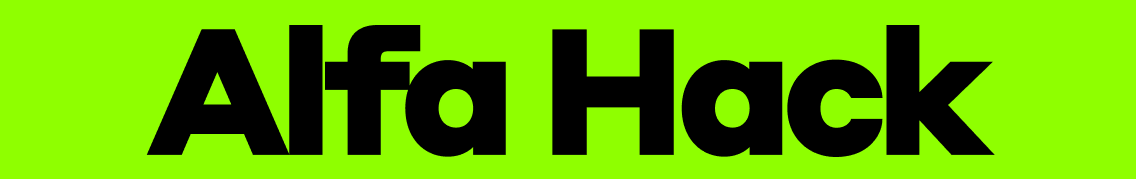
</div>

## Установка библиотек и импорт данных

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.0 MB/s eta 0:00:00


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.6 MB/s eta 0:00:00


In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN
from collections import Counter

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import os

import optuna

from warnings import filterwarnings
filterwarnings('ignore')

Подключаемся в Google Drive, чтобы работать с файлами из Google Colaboratory

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Скачка сырых данных

Указываем путь к корневым папкам с данными test и train

__Обратите внимание:__ если вы создали папку с названием отличным от _"Хакатон Альфа-банка. Кейс 1"_, то необходимо поменять путь к директории и ссылки ниже

In [ ]:
# Путь к папке с тренировочными данными
path_train = '/content/drive/MyDrive/Хакатон Альфа-банка. Кейс 1/train'
# Путь к папке с тестовыми данными
path_test = '/content/drive/MyDrive/Хакатон Альфа-банка. Кейс 1/test'

Получим список файлов в каждой из папок с данными

In [ ]:
print(*[f'Список файлов в репозитории {x.split("/")[-1]}: {sorted(os.listdir(x), key=lambda x: len(x))}' for x in [path_train, path_test]], sep='\n')

Список файлов в репозитории train: ['train_4.csv', 'train_9.csv', 'train_5.csv', 'train_6.csv', 'train_8.csv', 'train_2.csv', 'train_7.csv', 'train_3.csv', 'train_1.csv', 'train_10.csv']
Список файлов в репозитории test: ['test_6.csv', 'test_8.csv', 'test_1.csv', 'test_5.csv', 'test_4.csv', 'test_2.csv', 'test_3.csv', 'test_7.csv', 'test_9.csv', 'test_10.csv']


Объединим тренировочные и тестовые данные в единые датасеты train и test

In [ ]:
# Получим список путей к файлам в папке train
filenames_train = glob.glob(path_train + "/*.csv")

# Создадим список для записи считанных файлов train
data_files_train = []

# Считаем все файлы train и добавим их в список
for filename in filenames_train:
    data_files_train.append(pd.read_csv(filename))

# Объединим тренировочные данные в единый датасет
data_train = pd.concat(data_files_train, ignore_index=True)

# Выведем информацию о размерности полученных тренировочных данных
display('Размерность полных тренировочных данных составляет: {} строка и {} столбец'.format(*data_train.shape))

# Выведем первые 5 строк тренировочных данных
display(data_train.head())

# Удостоверимся, что перед нами данные только из выборки train
data_train['smpl'].value_counts(dropna=False)

'Размерность полных тренировочных данных составляет: 38731 строка и 421 столбец'

,target,smpl,id,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_409,feature_410,feature_411,feature_412,feature_413,feature_414,feature_415,feature_416,feature_417,feature_418
0,0,train,11619,-0.803605,1.373680,1.0,-0.147178,-1.135569,-0.829743,-0.688879,...,2.002449,1.139800,1.0,0.299604,0.739050,-0.870988,-1.643177,0.259418,3.224089,-0.905515
1,0,train,11620,-2.066605,-1.666932,0.0,0.087665,0.316779,0.918004,-0.143202,...,-2.153467,-0.122552,0.0,0.978408,-0.335446,0.698805,1.920243,0.397668,-0.979179,-1.496148
2,0,train,11621,-1.419976,0.570124,0.0,3.117520,-1.767073,1.087783,1.596354,...,0.541124,-2.008305,0.0,0.437926,-0.052971,1.839667,1.872591,0.065527,1.620158,0.235264
3,0,train,11622,0.241241,-1.165185,0.0,-0.946474,0.288386,0.908839,1.049859,...,-0.298835,0.239494,0.0,-0.797018,-0.289733,0.836043,0.675707,0.293216,0.566113,0.311053
4,0,train,11623,-0.062594,0.446797,0.0,-0.039862,0.305150,-0.087690,-0.157288,...,-0.910352,-0.607310,0.0,1.142165,-1.211827,-0.241350,-0.354882,-1.209285,0.545290,0.092345


,count
smpl,
train,38731


In [ ]:
# Получим список путей к файлам в папке test
filenames_test = glob.glob(path_test + "/*.csv")

# Создадим список для записи считанных файлов test
data_files_test = []

# Считаем все файлы test и добавим их в список
for filename in filenames_test:
    data_files_test.append(pd.read_csv(filename))

# Объединим тестовые данные в единый датасет
data_test = pd.concat(data_files_test, ignore_index=True)

# Выведем информацию о размерности полученных тестовых данных
display('Размерность полных тестовых данных составляет: {} строк и {} столбцов'.format(*data_test.shape))

# Выведем первые 5 строк тестовых данных
display(data_test.head())

# Удостоверимся, что перед нами данные только из выборки test
data_test['smpl'].value_counts(dropna=False)

'Размерность полных тестовых данных составляет: 19826 строк и 420 столбцов'

,smpl,id,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_409,feature_410,feature_411,feature_412,feature_413,feature_414,feature_415,feature_416,feature_417,feature_418
0,test,48641,-0.693207,1.028065,1.0,-1.950657,-1.069576,-0.207907,-0.901771,-1.766137,...,0.969714,-0.463177,1.0,-0.128931,-0.478766,-1.254737,-1.676629,-0.783663,-1.373582,-0.954945
1,test,48642,-1.070053,0.012978,0.0,0.116074,0.220002,-0.132557,0.497531,0.749232,...,-0.067262,0.355127,0.0,-0.919300,1.089020,-0.511555,-0.234425,-1.350664,-0.087941,0.681846
2,test,48643,0.329789,1.483965,0.0,-0.000365,1.486131,-0.051990,1.074513,0.652608,...,0.203382,0.685827,0.0,0.023634,-0.881966,1.079665,0.127598,1.663637,0.354686,0.775070
3,test,48644,0.205746,1.959737,1.0,-1.761253,-1.098213,-0.224695,-0.934671,0.902866,...,-0.582833,-1.193138,0.0,0.113583,-0.507730,-1.099649,-0.724977,0.002072,-0.004418,-0.054258
4,test,48645,1.177594,-1.353919,0.0,2.761329,0.607158,0.548091,0.392070,-0.542383,...,2.948859,1.252978,0.0,-0.786127,0.905075,0.367629,0.869076,-0.860033,-1.302164,0.110121


,count
smpl,
test,19826


# Подбор модели на сырых данных

In [ ]:
X = data_train.drop(['target', 'smpl'], axis=1)
y = data_train['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, stratify=y, test_size=0.3)

## Baseline model

In [ ]:
# Обучим модель на тренировочной части тренировочных данных
gbdt_clf = HistGradientBoostingClassifier(min_samples_leaf=1,
                                          max_depth=20,
                                          max_iter=125,
                                          random_state=42).fit(X_train, y_train)

# Получим предсказание с вероятностями для валидационной части тренировочного датасета
y_pred = gbdt_clf.predict_proba(X_val)

# Переведем предсказание в формат Series
y_pred_series = pd.Series(y_pred[:, 1])

# Высчитаем метрику roc-auc по валидационным данным
print(f'Метрика roc-auc на валидационных данных имеет значение: {roc_auc_score(y_val, y_pred_series)}')

Метрика roc-auc на валидационных данных имеет значение: 0.7508514870902561


## Загрузка готовых (уже поделённых) данных

In [ ]:
train_raw = pd.read_csv('/content/drive/MyDrive/Хакатон Альфа-банка. Кейс 1/train (train val) processed/train_raw.csv').drop('Unnamed: 0', axis=1)
val_raw = pd.read_csv('/content/drive/MyDrive/Хакатон Альфа-банка. Кейс 1/val (train val) processed/val_raw.csv').drop('Unnamed: 0', axis=1)

In [ ]:
train_raw

,id,feature_1,feature_2,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_11,...,feature_375_3.0,feature_375_4.0,feature_375_5.0,feature_383_0.0,feature_383_1.0,feature_396_1.0,feature_396_2.0,feature_411_0.0,feature_411_1.0,target
0,18528,-0.929533,-0.087657,-0.266736,-0.325690,-0.737559,-0.764311,-1.363869,-0.472380,1.304781,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0
1,25985,-1.610432,-1.159588,-0.263746,-0.530598,-1.434444,-0.750561,-1.157461,-1.878024,0.187424,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0
2,16308,0.666124,-1.828877,-1.549235,-0.768044,-0.849521,1.462194,0.492319,-0.358055,0.396696,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
3,36645,-2.497979,-1.402859,-0.752793,1.639469,-0.702706,-0.771861,1.122613,0.386784,0.850490,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0
4,32358,-0.327321,0.479599,0.741337,0.702061,1.382356,0.323255,-0.288256,-1.055095,0.950498,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27106,12895,-0.096211,-0.387367,-1.030483,-2.959146,-1.274279,-1.030227,0.477975,-1.011551,0.313167,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0
27107,26786,-1.520131,1.522591,-1.075535,-0.720633,1.672649,1.956666,-1.724499,0.963200,0.111294,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
27108,24241,0.938202,1.138889,0.993833,0.989746,0.664317,0.336471,-1.457132,0.383232,1.000996,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
27109,23961,-0.300127,-2.218951,0.436842,0.171838,0.173702,0.062911,-1.064367,1.494637,-0.838321,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0


In [ ]:
X_train = train_raw.drop(['id', 'target'], axis=1)
y_train = train_raw['target']
X_val = val_raw.drop(['id', 'target'], axis=1)
y_val = val_raw['target']

## sklearn Gradient Boosting

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier

In [ ]:
def objective(trial):

    params = {
        "loss": "log_loss",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "max_iter": trial.suggest_int("max_iter", 50, 100),
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 10, 50),
        "max_depth": trial.suggest_int("max_depth", 4, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 20, 200),
        "l2_regularization": trial.suggest_float("l2_regularization", 1e-8, 1.0),
        "max_features": trial.suggest_float("max_features", 0.1, 1),
        "verbose": 0,
        "random_state": 42
    }

    model = HistGradientBoostingClassifier(**params)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_val)
    return roc_auc_score(y_val, y_pred[:, 1])


In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: {}".format(len(study.trials)))

[I 2024-11-12 12:10:57,751] A new study created in memory with name: no-name-291aa373-0727-4d1e-a57e-fb4e1a010537
[I 2024-11-12 12:11:12,376] Trial 0 finished with value: 0.769616367468273 and parameters: {'learning_rate': 0.036972081597181475, 'max_iter': 76, 'max_leaf_nodes': 35, 'max_depth': 17, 'min_samples_leaf': 137, 'l2_regularization': 0.3669316741389863, 'max_features': 0.6407649980929726}. Best is trial 0 with value: 0.769616367468273.
[I 2024-11-12 12:11:21,684] Trial 1 finished with value: 0.765086230128056 and parameters: {'learning_rate': 0.10282438265294663, 'max_iter': 67, 'max_leaf_nodes': 48, 'max_depth': 15, 'min_samples_leaf': 143, 'l2_regularization': 0.8104858378100054, 'max_features': 0.39562354553321544}. Best is trial 0 with value: 0.769616367468273.
[I 2024-11-12 12:11:26,640] Trial 2 finished with value: 0.7279782575661952 and parameters: {'learning_rate': 0.19066661344067123, 'max_iter': 90, 'max_leaf_nodes': 31, 'max_depth': 16, 'min_samples_leaf': 185, 'l2

Number of finished trials: 100


In [ ]:
print("Best trial:")
trial = study.best_trial

print("Value: {}".format(trial.value))

print("Params: ")
for key, value in trial.params.items():
    print("{}: {}".format(key, value))

Best trial:
Value: 0.7781731390117221
Params: 
learning_rate: 0.03234969910581977
max_iter: 88
max_leaf_nodes: 37
max_depth: 14
min_samples_leaf: 62
l2_regularization: 0.2711575788720302
max_features: 0.7678777768877801


In [ ]:
params = {
    'learning_rate': 0.03636804923112538,
    'max_iter': 87,
    'max_leaf_nodes': 22,
    'max_depth': 13,
    'min_samples_leaf': 72,
    'l2_regularization': 0.8021124651847891,
    'max_features': 0.10111636089617387
}

grad_boosting = HistGradientBoostingClassifier(**params, random_state=42, class_weight='balanced').fit(X_train, y_train)

y_pred = grad_boosting.predict_proba(X_val)
print(f'ROC-AUC: {roc_auc_score(y_val, y_pred[:, 1])}')

ROC-AUC: 0.7602605281010734


## XGBoost

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xg_boosting = XGBClassifier(random_state=42).fit(X_train, y_train)

y_pred_xg = xg_boosting.predict_proba(X_val)
print(f'ROC-AUC: {roc_auc_score(y_val, y_pred_xg[:, 1])}')

ROC-AUC: 0.7200985030170199


In [ ]:
def objective(trial):

    param = {
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 2, 15),
        'subsample': trial.suggest_discrete_uniform('subsample', 0.6, 1.0, 0.05),
        'n_estimators': trial.suggest_int('n_estimators', 1000, 10000, 100),
        'eta': trial.suggest_discrete_uniform('eta', 0.01, 0.1, 0.01),
        'reg_alpha': trial.suggest_int('reg_alpha', 1, 50),
        'reg_lambda': trial.suggest_int('reg_lambda', 5, 100),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 20),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train)

    y_pred_lb = model.predict_proba(X_val)
    return roc_auc_score(y_val, y_pred_lb[:, 1])


In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Number of finished trials: {}".format(len(study.trials)))

[I 2024-11-12 11:54:47,730] A new study created in memory with name: no-name-e445a37c-661b-498d-9c14-6e2d640708ee
[I 2024-11-12 11:56:10,269] Trial 0 finished with value: 0.7670732941310242 and parameters: {'learning_rate': 0.13505497822054116, 'max_depth': 5, 'subsample': 0.85, 'n_estimators': 7200, 'eta': 0.04, 'reg_alpha': 3, 'reg_lambda': 87, 'min_child_weight': 12, 'colsample_bytree': 0.8435358822614358}. Best is trial 0 with value: 0.7670732941310242.
[I 2024-11-12 11:57:27,810] Trial 1 finished with value: 0.7670732941310242 and parameters: {'learning_rate': 0.0683503976216835, 'max_depth': 4, 'subsample': 1.0, 'n_estimators': 1700, 'eta': 0.05, 'reg_alpha': 5, 'reg_lambda': 96, 'min_child_weight': 18, 'colsample_bytree': 0.6091712445236246}. Best is trial 0 with value: 0.7670732941310242.
[I 2024-11-12 11:58:44,411] Trial 2 finished with value: 0.7670732941310242 and parameters: {'learning_rate': 0.09352008297828641, 'max_depth': 3, 'subsample': 0.7, 'n_estimators': 8800, 'eta'

KeyboardInterrupt: 

In [ ]:
print("Best trial:")
trial = study.best_trial

print("Value: {}".format(trial.value))

print("Params: ")
for key, value in trial.params.items():
    print("{}: {}".format(key, value))

## LightGBM

In [ ]:
from lightgbm import LGBMClassifier

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
light_boosting = LGBMClassifier(random_seed=42).fit(X=X_train, y=y_train,
                                                    eval_set=[(X_val, y_val)],
                                                    eval_metric='auc')

y_pred_lb = light_boosting.predict_proba(X_val)
print(f'ROC-AUC: {roc_auc_score(y_val, y_pred_lb[:, 1])}')

[LightGBM] [Info] Number of positive: 590, number of negative: 26521
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.186370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97565
[LightGBM] [Info] Number of data points in the train set: 27111, number of used features: 419
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.021762 -> initscore=-3.805570
[LightGBM] [Info] Start training from score -3.805570
ROC-AUC: 0.7584857490878353


In [ ]:
def objective(trial):

    params = {
        "objective": "binary",
        "eval_metric": "log_loss",
        "verbosity": -1,
        "n_estimators": 12500,
        "subsample": trial.suggest_float("subsample", 0.1, 1),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 1.0),
        "scale_pos_weight": trial.suggest_int("scale_pos_weight", 1, 6),
        "early_stopping_round": 300,
        "random_state": 42,
        "num_leaves": trial.suggest_int("num_leaves", 16, 200),
        "max_depth": trial.suggest_int("max_depth", 4, 20),
        "min_child_samples": trial.suggest_int("min_child_samples", 25, 200),
    }

    model = LGBMClassifier(**params)
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              eval_metric='auc'
              )

    y_pred_lb = model.predict_proba(X_val)
    return roc_auc_score(y_val, y_pred_lb[:, 1])


In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: {}".format(len(study.trials)))

[I 2024-11-07 17:47:08,663] A new study created in memory with name: no-name-0572b7d2-4d82-4b96-bf5f-13733bfd129b
[I 2024-11-07 17:47:27,235] Trial 0 finished with value: 0.6801642366033567 and parameters: {'subsample': 0.29885678141529737, 'learning_rate': 0.16423627678288868, 'colsample_bytree': 0.13108217588574536, 'reg_alpha': 0.002700456190998565, 'reg_lambda': 0.30621656390147267, 'scale_pos_weight': 5, 'num_leaves': 127, 'max_depth': 15, 'min_child_samples': 53}. Best is trial 0 with value: 0.6801642366033567.
[I 2024-11-07 17:48:13,027] Trial 1 finished with value: 0.7479938981539724 and parameters: {'subsample': 0.6882013013196148, 'learning_rate': 0.07364341055105889, 'colsample_bytree': 0.5198711477168727, 'reg_alpha': 0.08200729214400339, 'reg_lambda': 0.13044125681770827, 'scale_pos_weight': 4, 'num_leaves': 172, 'max_depth': 11, 'min_child_samples': 59}. Best is trial 1 with value: 0.7479938981539724.
[I 2024-11-07 17:48:39,140] Trial 2 finished with value: 0.738226354564

Number of finished trials: 100


In [ ]:
print("Best trial:")
trial = study.best_trial

print("Value: {}".format(trial.value))

print("Params: ")
for key, value in trial.params.items():
    print("{}: {}".format(key, value))

Best trial:
Value: 0.7934381857752715
Params: 
subsample: 0.48748724047206654
learning_rate: 0.033840417964290125
colsample_bytree: 0.5782285251273777
reg_alpha: 0.1351536043430544
reg_lambda: 0.31900045174209063
scale_pos_weight: 5
num_leaves: 27
max_depth: 9
min_child_samples: 99


In [ ]:
params = {
    'subsample': 0.48748724047206654,
    'learning_rate': 0.033840417964290125,
    'colsample_bytree': 0.5782285251273777,
    'reg_alpha': 0.1351536043430544,
    'reg_lambda': 0.31900045174209063,
    'scale_pos_weight': 5,
    'num_leaves': 27,
    'max_depth': 9,
    'min_child_samples': 99
}

light_boosting_best = LGBMClassifier(**params, random_seed=42).fit(X=X_train, y=y_train,
                                                    eval_set=[(X_val, y_val)],
                                                    eval_metric='auc')

y_pred_lb_best = light_boosting_best.predict_proba(X_val)
print(f'ROC-AUC: {roc_auc_score(y_val, y_pred_lb_best[:, 1])}')

ROC-AUC: 0.7628914015364496


## CatBoost

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
cat_boosting = CatBoostClassifier(random_seed=42).fit(X_train, y_train,
                                                      eval_set=(X_val, y_val),
                                                      early_stopping_rounds=20)

y_pred_cb = cat_boosting.predict_proba(X_val)
print(f'ROC-AUC: {roc_auc_score(y_val, y_pred_cb[:, 1])}')

Learning rate set to 0.071597
0:	learn: 0.5705311	test: 0.5707950	best: 0.5707950 (0)	total: 203ms	remaining: 3m 22s
1:	learn: 0.4737005	test: 0.4739690	best: 0.4739690 (1)	total: 340ms	remaining: 2m 49s
2:	learn: 0.3976732	test: 0.3979150	best: 0.3979150 (2)	total: 482ms	remaining: 2m 40s
3:	learn: 0.3355583	test: 0.3359947	best: 0.3359947 (3)	total: 616ms	remaining: 2m 33s
4:	learn: 0.2885013	test: 0.2889054	best: 0.2889054 (4)	total: 765ms	remaining: 2m 32s
5:	learn: 0.2512045	test: 0.2518192	best: 0.2518192 (5)	total: 924ms	remaining: 2m 33s
6:	learn: 0.2217410	test: 0.2224547	best: 0.2224547 (6)	total: 1.07s	remaining: 2m 31s
7:	learn: 0.1976524	test: 0.1984759	best: 0.1984759 (7)	total: 1.2s	remaining: 2m 29s
8:	learn: 0.1798585	test: 0.1807646	best: 0.1807646 (8)	total: 1.38s	remaining: 2m 31s
9:	learn: 0.1654574	test: 0.1664044	best: 0.1664044 (9)	total: 1.52s	remaining: 2m 30s
10:	learn: 0.1538450	test: 0.1549151	best: 0.1549151 (10)	total: 1.66s	remaining: 2m 29s
11:	learn: 0

In [ ]:
def objective(trial):

    params = {
        "iterations": trial.suggest_int("iterations", 100, 200),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        "random_strength": trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 10.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "random_state": 42,
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train,
              eval_set=(X_val, y_val),
              early_stopping_rounds=20)

    y_pred_lb = model.predict_proba(X_val)
    return roc_auc_score(y_val, y_pred_lb[:, 1])


In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: {}".format(len(study.trials)))

[I 2024-11-08 13:08:48,426] A new study created in memory with name: no-name-c5a02444-04f8-4b13-b876-c766d2232fdd


0:	learn: 0.6352991	test: 0.6354873	best: 0.6354873 (0)	total: 295ms	remaining: 57.5s
1:	learn: 0.5820979	test: 0.5825264	best: 0.5825264 (1)	total: 505ms	remaining: 49s
2:	learn: 0.5359041	test: 0.5365148	best: 0.5365148 (2)	total: 713ms	remaining: 45.9s
3:	learn: 0.4928023	test: 0.4935284	best: 0.4935284 (3)	total: 944ms	remaining: 45.3s
4:	learn: 0.4549251	test: 0.4559024	best: 0.4559024 (4)	total: 1.16s	remaining: 44.2s
5:	learn: 0.4225433	test: 0.4237027	best: 0.4237027 (5)	total: 1.37s	remaining: 43.3s
6:	learn: 0.3918898	test: 0.3931829	best: 0.3931829 (6)	total: 1.57s	remaining: 42.5s
7:	learn: 0.3658499	test: 0.3672366	best: 0.3672366 (7)	total: 1.76s	remaining: 41.4s
8:	learn: 0.3415252	test: 0.3430640	best: 0.3430640 (8)	total: 1.98s	remaining: 41.2s
9:	learn: 0.3197151	test: 0.3213282	best: 0.3213282 (9)	total: 2.19s	remaining: 40.7s
10:	learn: 0.2989919	test: 0.3007465	best: 0.3007465 (10)	total: 2.4s	remaining: 40.4s
11:	learn: 0.2805698	test: 0.2824870	best: 0.2824870 (1

[I 2024-11-08 13:09:37,497] Trial 0 finished with value: 0.7528453316948618 and parameters: {'iterations': 196, 'depth': 7, 'l2_leaf_reg': 0.05672378801160457, 'bootstrap_type': 'Bayesian', 'random_strength': 1.663650445839868e-05, 'bagging_temperature': 0.9296070041168014, 'od_type': 'Iter', 'od_wait': 44}. Best is trial 0 with value: 0.7528453316948618.


191:	learn: 0.0696218	test: 0.0959354	best: 0.0959039 (171)	total: 47.1s	remaining: 982ms
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.09590394045
bestIteration = 171

Shrink model to first 172 iterations.
0:	learn: 0.6395976	test: 0.6396851	best: 0.6396851 (0)	total: 101ms	remaining: 12.5s
1:	learn: 0.5911106	test: 0.5912859	best: 0.5912859 (1)	total: 184ms	remaining: 11.3s
2:	learn: 0.5470714	test: 0.5472655	best: 0.5472655 (2)	total: 263ms	remaining: 10.7s
3:	learn: 0.5070187	test: 0.5071912	best: 0.5071912 (3)	total: 347ms	remaining: 10.5s
4:	learn: 0.4705302	test: 0.4707594	best: 0.4707594 (4)	total: 443ms	remaining: 10.6s
5:	learn: 0.4375615	test: 0.4378556	best: 0.4378556 (5)	total: 527ms	remaining: 10.4s
6:	learn: 0.4076432	test: 0.4079126	best: 0.4079126 (6)	total: 618ms	remaining: 10.4s
7:	learn: 0.3789952	test: 0.3791649	best: 0.3791649 (7)	total: 699ms	remaining: 10.2s
8:	learn: 0.3543718	test: 0.3545905	best: 0.3545905 (8)	total: 781ms	remaining: 10.

[I 2024-11-08 13:09:53,069] Trial 1 finished with value: 0.7003742544380775 and parameters: {'iterations': 125, 'depth': 5, 'l2_leaf_reg': 0.00022528633621181384, 'bootstrap_type': 'Bayesian', 'random_strength': 1.7031516185506645e-07, 'bagging_temperature': 9.501585477027936, 'od_type': 'IncToDec', 'od_wait': 46}. Best is trial 0 with value: 0.7528453316948618.


124:	learn: 0.1057497	test: 0.1024273	best: 0.1024178 (123)	total: 14.1s	remaining: 0us

bestTest = 0.1024177772
bestIteration = 123

Shrink model to first 124 iterations.
0:	learn: 0.6398387	test: 0.6399446	best: 0.6399446 (0)	total: 106ms	remaining: 20.6s
1:	learn: 0.5912784	test: 0.5913686	best: 0.5913686 (1)	total: 215ms	remaining: 20.9s
2:	learn: 0.5467553	test: 0.5470718	best: 0.5470718 (2)	total: 341ms	remaining: 22s
3:	learn: 0.5065995	test: 0.5069349	best: 0.5069349 (3)	total: 443ms	remaining: 21.3s
4:	learn: 0.4701765	test: 0.4705072	best: 0.4705072 (4)	total: 564ms	remaining: 21.5s
5:	learn: 0.4373502	test: 0.4376356	best: 0.4376356 (5)	total: 690ms	remaining: 21.8s
6:	learn: 0.4074454	test: 0.4077333	best: 0.4077333 (6)	total: 804ms	remaining: 21.7s
7:	learn: 0.3804226	test: 0.3807442	best: 0.3807442 (7)	total: 926ms	remaining: 21.8s
8:	learn: 0.3558244	test: 0.3561239	best: 0.3561239 (8)	total: 1.03s	remaining: 21.3s
9:	learn: 0.3328973	test: 0.3332174	best: 0.3332174 (9)	

[I 2024-11-08 13:10:08,868] Trial 2 finished with value: 0.6751768433065551 and parameters: {'iterations': 196, 'depth': 4, 'l2_leaf_reg': 1.494481510103265e-07, 'bootstrap_type': 'Bayesian', 'random_strength': 8.631882287147647e-05, 'bagging_temperature': 6.8979365995806985, 'od_type': 'Iter', 'od_wait': 50}. Best is trial 0 with value: 0.7528453316948618.


0:	learn: 0.6406978	test: 0.6408799	best: 0.6408799 (0)	total: 854ms	remaining: 2m 37s
1:	learn: 0.5933412	test: 0.5936256	best: 0.5936256 (1)	total: 1.45s	remaining: 2m 13s
2:	learn: 0.5497200	test: 0.5500384	best: 0.5500384 (2)	total: 2.01s	remaining: 2m 2s
3:	learn: 0.5100479	test: 0.5103939	best: 0.5103939 (3)	total: 2.64s	remaining: 2m
4:	learn: 0.4733328	test: 0.4736490	best: 0.4736490 (4)	total: 3.31s	remaining: 1m 59s
5:	learn: 0.4395742	test: 0.4398535	best: 0.4398535 (5)	total: 3.75s	remaining: 1m 52s
6:	learn: 0.4097988	test: 0.4100862	best: 0.4100862 (6)	total: 4.1s	remaining: 1m 44s
7:	learn: 0.3827045	test: 0.3829686	best: 0.3829686 (7)	total: 4.45s	remaining: 1m 39s
8:	learn: 0.3576938	test: 0.3579686	best: 0.3579686 (8)	total: 4.8s	remaining: 1m 34s
9:	learn: 0.3356921	test: 0.3359928	best: 0.3359928 (9)	total: 5.15s	remaining: 1m 30s
10:	learn: 0.3155259	test: 0.3158672	best: 0.3158672 (10)	total: 5.5s	remaining: 1m 27s
11:	learn: 0.2969391	test: 0.2972820	best: 0.2972

[I 2024-11-08 13:11:28,069] Trial 3 finished with value: 0.7372426457420778 and parameters: {'iterations': 186, 'depth': 8, 'l2_leaf_reg': 37.73675584480313, 'bootstrap_type': 'Bayesian', 'random_strength': 0.024218887935884215, 'bagging_temperature': 4.69014824701293, 'od_type': 'IncToDec', 'od_wait': 23}. Best is trial 0 with value: 0.7528453316948618.


0:	learn: 0.6390679	test: 0.6392453	best: 0.6392453 (0)	total: 253ms	remaining: 47.3s
1:	learn: 0.5898152	test: 0.5900309	best: 0.5900309 (1)	total: 427ms	remaining: 39.7s
2:	learn: 0.5450715	test: 0.5453364	best: 0.5453364 (2)	total: 581ms	remaining: 35.8s
3:	learn: 0.5043589	test: 0.5046697	best: 0.5046697 (3)	total: 680ms	remaining: 31.3s
4:	learn: 0.4662319	test: 0.4664591	best: 0.4664591 (4)	total: 773ms	remaining: 28.3s
5:	learn: 0.4337601	test: 0.4339792	best: 0.4339792 (5)	total: 820ms	remaining: 24.9s
6:	learn: 0.4035003	test: 0.4036655	best: 0.4036655 (6)	total: 922ms	remaining: 23.8s
7:	learn: 0.3759355	test: 0.3761645	best: 0.3761645 (7)	total: 1.02s	remaining: 22.9s
8:	learn: 0.3511856	test: 0.3515098	best: 0.3515098 (8)	total: 1.12s	remaining: 22.2s
9:	learn: 0.3290849	test: 0.3294534	best: 0.3294534 (9)	total: 1.23s	remaining: 21.9s
10:	learn: 0.3076240	test: 0.3082749	best: 0.3082749 (10)	total: 1.33s	remaining: 21.4s
11:	learn: 0.2894590	test: 0.2902100	best: 0.2902100

[I 2024-11-08 13:11:50,614] Trial 4 finished with value: 0.7565517128669044 and parameters: {'iterations': 188, 'depth': 5, 'l2_leaf_reg': 2.4014136407008502e-05, 'bootstrap_type': 'Bayesian', 'random_strength': 0.3949488007848245, 'bagging_temperature': 0.02403942992302066, 'od_type': 'IncToDec', 'od_wait': 28}. Best is trial 4 with value: 0.7565517128669044.


187:	learn: 0.0789400	test: 0.0954645	best: 0.0954295 (170)	total: 20.2s	remaining: 0us

bestTest = 0.09542949242
bestIteration = 170

Shrink model to first 171 iterations.
0:	learn: 0.6379070	test: 0.6380375	best: 0.6380375 (0)	total: 76.8ms	remaining: 7.75s
1:	learn: 0.5896000	test: 0.5897495	best: 0.5897495 (1)	total: 135ms	remaining: 6.76s
2:	learn: 0.5457742	test: 0.5459100	best: 0.5459100 (2)	total: 193ms	remaining: 6.36s
3:	learn: 0.5059352	test: 0.5060697	best: 0.5060697 (3)	total: 249ms	remaining: 6.1s
4:	learn: 0.4696643	test: 0.4698102	best: 0.4698102 (4)	total: 312ms	remaining: 6.06s
5:	learn: 0.4366285	test: 0.4367904	best: 0.4367904 (5)	total: 386ms	remaining: 6.18s
6:	learn: 0.4067559	test: 0.4069107	best: 0.4069107 (6)	total: 444ms	remaining: 6.02s
7:	learn: 0.3788317	test: 0.3790051	best: 0.3790051 (7)	total: 502ms	remaining: 5.9s
8:	learn: 0.3543051	test: 0.3544515	best: 0.3544515 (8)	total: 565ms	remaining: 5.83s
9:	learn: 0.3322550	test: 0.3324271	best: 0.3324271 (9

[I 2024-11-08 13:12:00,422] Trial 5 finished with value: 0.7215074772649903 and parameters: {'iterations': 102, 'depth': 4, 'l2_leaf_reg': 8.769522143852012e-07, 'bootstrap_type': 'Bayesian', 'random_strength': 1.816935731400114e-07, 'bagging_temperature': 3.6692136327736877, 'od_type': 'Iter', 'od_wait': 49}. Best is trial 4 with value: 0.7565517128669044.


101:	learn: 0.1034687	test: 0.1025482	best: 0.1025482 (101)	total: 8.28s	remaining: 0us

bestTest = 0.1025482424
bestIteration = 101

0:	learn: 0.6398133	test: 0.6399164	best: 0.6399164 (0)	total: 104ms	remaining: 10.4s
1:	learn: 0.5906710	test: 0.5908217	best: 0.5908217 (1)	total: 189ms	remaining: 9.35s
2:	learn: 0.5466589	test: 0.5468098	best: 0.5468098 (2)	total: 273ms	remaining: 8.93s
3:	learn: 0.5061641	test: 0.5064041	best: 0.5064041 (3)	total: 358ms	remaining: 8.68s
4:	learn: 0.4697085	test: 0.4699593	best: 0.4699593 (4)	total: 442ms	remaining: 8.49s
5:	learn: 0.4368584	test: 0.4371268	best: 0.4371268 (5)	total: 524ms	remaining: 8.3s
6:	learn: 0.4069916	test: 0.4072328	best: 0.4072328 (6)	total: 610ms	remaining: 8.19s
7:	learn: 0.3792465	test: 0.3794155	best: 0.3794155 (7)	total: 690ms	remaining: 8.03s
8:	learn: 0.3545984	test: 0.3548217	best: 0.3548217 (8)	total: 770ms	remaining: 7.87s
9:	learn: 0.3323480	test: 0.3326128	best: 0.3326128 (9)	total: 858ms	remaining: 7.81s
10:	lea

[I 2024-11-08 13:12:10,928] Trial 6 finished with value: 0.7048275449597354 and parameters: {'iterations': 101, 'depth': 5, 'l2_leaf_reg': 2.910969056994611e-07, 'bootstrap_type': 'Bayesian', 'random_strength': 4.010432295081619, 'bagging_temperature': 9.27836462678743, 'od_type': 'Iter', 'od_wait': 14}. Best is trial 4 with value: 0.7565517128669044.


0:	learn: 0.6328186	test: 0.6334013	best: 0.6334013 (0)	total: 1.95s	remaining: 3m 41s
1:	learn: 0.5788423	test: 0.5799759	best: 0.5799759 (1)	total: 3.56s	remaining: 3m 21s
2:	learn: 0.5342733	test: 0.5356909	best: 0.5356909 (2)	total: 4.69s	remaining: 2m 55s
3:	learn: 0.4923637	test: 0.4939236	best: 0.4939236 (3)	total: 5.83s	remaining: 2m 41s
4:	learn: 0.4561267	test: 0.4579524	best: 0.4579524 (4)	total: 6.99s	remaining: 2m 33s
5:	learn: 0.4228728	test: 0.4249829	best: 0.4249829 (5)	total: 8.13s	remaining: 2m 27s
6:	learn: 0.3907444	test: 0.3931365	best: 0.3931365 (6)	total: 9.27s	remaining: 2m 23s
7:	learn: 0.3623502	test: 0.3650947	best: 0.3650947 (7)	total: 10.4s	remaining: 2m 19s
8:	learn: 0.3372349	test: 0.3403483	best: 0.3403483 (8)	total: 11.6s	remaining: 2m 16s
9:	learn: 0.3148215	test: 0.3181418	best: 0.3181418 (9)	total: 12.7s	remaining: 2m 13s
10:	learn: 0.2946299	test: 0.2983749	best: 0.2983749 (10)	total: 14.7s	remaining: 2m 19s
11:	learn: 0.2758779	test: 0.2799120	best

[I 2024-11-08 13:14:50,482] Trial 7 finished with value: 0.7438160043757482 and parameters: {'iterations': 115, 'depth': 10, 'l2_leaf_reg': 0.010308877412855919, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0041490046442469565, 'bagging_temperature': 1.7639503554031133, 'od_type': 'Iter', 'od_wait': 50}. Best is trial 4 with value: 0.7565517128669044.


114:	learn: 0.0721816	test: 0.0982647	best: 0.0982647 (114)	total: 2m 36s	remaining: 0us

bestTest = 0.09826465329
bestIteration = 114

0:	learn: 0.6378344	test: 0.6381764	best: 0.6381764 (0)	total: 1.14s	remaining: 2m 23s
1:	learn: 0.5876582	test: 0.5881501	best: 0.5881501 (1)	total: 2.3s	remaining: 2m 23s
2:	learn: 0.5437324	test: 0.5442737	best: 0.5442737 (2)	total: 3.44s	remaining: 2m 22s
3:	learn: 0.5036555	test: 0.5042587	best: 0.5042587 (3)	total: 4.59s	remaining: 2m 21s
4:	learn: 0.4668179	test: 0.4675945	best: 0.4675945 (4)	total: 5.74s	remaining: 2m 20s
5:	learn: 0.4341192	test: 0.4350437	best: 0.4350437 (5)	total: 7.43s	remaining: 2m 29s
6:	learn: 0.4033832	test: 0.4044000	best: 0.4044000 (6)	total: 9.52s	remaining: 2m 43s
7:	learn: 0.3760012	test: 0.3771053	best: 0.3771053 (7)	total: 11.4s	remaining: 2m 50s
8:	learn: 0.3499834	test: 0.3510830	best: 0.3510830 (8)	total: 12.6s	remaining: 2m 45s
9:	learn: 0.3277105	test: 0.3289242	best: 0.3289242 (9)	total: 13.8s	remaining: 2m

[I 2024-11-08 13:17:43,609] Trial 8 finished with value: 0.7365162520589559 and parameters: {'iterations': 127, 'depth': 10, 'l2_leaf_reg': 3.8456261015907094, 'bootstrap_type': 'Bayesian', 'random_strength': 2.981835224450629e-06, 'bagging_temperature': 2.7755663855030632, 'od_type': 'IncToDec', 'od_wait': 39}. Best is trial 4 with value: 0.7565517128669044.


126:	learn: 0.0880300	test: 0.0989754	best: 0.0989739 (125)	total: 2m 51s	remaining: 0us

bestTest = 0.09897389138
bestIteration = 125

Shrink model to first 126 iterations.
0:	learn: 0.6391425	test: 0.6393670	best: 0.6393670 (0)	total: 1.3s	remaining: 3m 7s
1:	learn: 0.5902434	test: 0.5906040	best: 0.5906040 (1)	total: 2.35s	remaining: 2m 48s
2:	learn: 0.5455652	test: 0.5460100	best: 0.5460100 (2)	total: 3.41s	remaining: 2m 41s
3:	learn: 0.5046428	test: 0.5051987	best: 0.5051987 (3)	total: 4.44s	remaining: 2m 36s
4:	learn: 0.4668064	test: 0.4673779	best: 0.4673779 (4)	total: 5.62s	remaining: 2m 37s
5:	learn: 0.4333780	test: 0.4340392	best: 0.4340392 (5)	total: 6.28s	remaining: 2m 25s
6:	learn: 0.4030222	test: 0.4037074	best: 0.4037074 (6)	total: 6.91s	remaining: 2m 16s
7:	learn: 0.3759026	test: 0.3766477	best: 0.3766477 (7)	total: 7.57s	remaining: 2m 9s
8:	learn: 0.3503174	test: 0.3512072	best: 0.3512072 (8)	total: 8.25s	remaining: 2m 4s
9:	learn: 0.3282328	test: 0.3292252	best: 0.329

[I 2024-11-08 13:19:34,633] Trial 9 finished with value: 0.7020554959210334 and parameters: {'iterations': 145, 'depth': 9, 'l2_leaf_reg': 0.03434880614658284, 'bootstrap_type': 'Bayesian', 'random_strength': 6.215788382742307e-06, 'bagging_temperature': 7.111006864556948, 'od_type': 'IncToDec', 'od_wait': 18}. Best is trial 4 with value: 0.7565517128669044.


0:	learn: 0.6372153	test: 0.6376195	best: 0.6376195 (0)	total: 325ms	remaining: 56.1s
1:	learn: 0.5875490	test: 0.5879272	best: 0.5879272 (1)	total: 457ms	remaining: 39.3s
2:	learn: 0.5428057	test: 0.5431027	best: 0.5431027 (2)	total: 587ms	remaining: 33.5s
3:	learn: 0.5019003	test: 0.5021262	best: 0.5021262 (3)	total: 713ms	remaining: 30.3s
4:	learn: 0.4658363	test: 0.4660594	best: 0.4660594 (4)	total: 849ms	remaining: 28.7s
5:	learn: 0.4327703	test: 0.4330108	best: 0.4330108 (5)	total: 984ms	remaining: 27.6s
6:	learn: 0.4021062	test: 0.4024582	best: 0.4024582 (6)	total: 1.11s	remaining: 26.6s
7:	learn: 0.3752796	test: 0.3756743	best: 0.3756743 (7)	total: 1.24s	remaining: 25.7s
8:	learn: 0.3505312	test: 0.3510423	best: 0.3510423 (8)	total: 1.39s	remaining: 25.5s
9:	learn: 0.3286274	test: 0.3291959	best: 0.3291959 (9)	total: 1.53s	remaining: 25s
10:	learn: 0.3085582	test: 0.3091991	best: 0.3091991 (10)	total: 1.65s	remaining: 24.5s
11:	learn: 0.2904695	test: 0.2911793	best: 0.2911793 (

[I 2024-11-08 13:20:01,812] Trial 10 finished with value: 0.7056669486701501 and parameters: {'iterations': 174, 'depth': 6, 'l2_leaf_reg': 4.2465142720983754e-05, 'bootstrap_type': 'Bayesian', 'random_strength': 7.661735839608433, 'bagging_temperature': 6.365217556222943, 'od_type': 'IncToDec', 'od_wait': 32}. Best is trial 4 with value: 0.7565517128669044.


0:	learn: 0.6376054	test: 0.6381243	best: 0.6381243 (0)	total: 588ms	remaining: 1m 38s
1:	learn: 0.5856323	test: 0.5863303	best: 0.5863303 (1)	total: 977ms	remaining: 1m 21s
2:	learn: 0.5397404	test: 0.5406581	best: 0.5406581 (2)	total: 1.36s	remaining: 1m 14s
3:	learn: 0.4990377	test: 0.5001478	best: 0.5001478 (3)	total: 1.76s	remaining: 1m 12s
4:	learn: 0.4611853	test: 0.4623609	best: 0.4623609 (4)	total: 2.14s	remaining: 1m 9s
5:	learn: 0.4275617	test: 0.4291163	best: 0.4291163 (5)	total: 2.55s	remaining: 1m 8s
6:	learn: 0.3959207	test: 0.3977421	best: 0.3977421 (6)	total: 2.95s	remaining: 1m 7s
7:	learn: 0.3677226	test: 0.3696806	best: 0.3696806 (7)	total: 3.32s	remaining: 1m 6s
8:	learn: 0.3433080	test: 0.3455288	best: 0.3455288 (8)	total: 3.55s	remaining: 1m 2s
9:	learn: 0.3199643	test: 0.3223088	best: 0.3223088 (9)	total: 3.78s	remaining: 59.7s
10:	learn: 0.2993473	test: 0.3016475	best: 0.3016475 (10)	total: 3.99s	remaining: 56.9s
11:	learn: 0.2816697	test: 0.2839680	best: 0.283

[I 2024-11-08 13:20:46,348] Trial 11 finished with value: 0.7584360246758264 and parameters: {'iterations': 168, 'depth': 7, 'l2_leaf_reg': 0.10999852170150505, 'bootstrap_type': 'Bayesian', 'random_strength': 0.09493311313235067, 'bagging_temperature': 0.17324801942497747, 'od_type': 'Iter', 'od_wait': 32}. Best is trial 11 with value: 0.7584360246758264.


0:	learn: 0.6353236	test: 0.6359948	best: 0.6359948 (0)	total: 496ms	remaining: 1m 22s
1:	learn: 0.5817574	test: 0.5827254	best: 0.5827254 (1)	total: 909ms	remaining: 1m 15s
2:	learn: 0.5344942	test: 0.5357225	best: 0.5357225 (2)	total: 1.3s	remaining: 1m 11s
3:	learn: 0.4930921	test: 0.4945780	best: 0.4945780 (3)	total: 1.68s	remaining: 1m 8s
4:	learn: 0.4548621	test: 0.4564315	best: 0.4564315 (4)	total: 2.1s	remaining: 1m 8s
5:	learn: 0.4197938	test: 0.4220049	best: 0.4220049 (5)	total: 2.52s	remaining: 1m 7s
6:	learn: 0.3879572	test: 0.3904630	best: 0.3904630 (6)	total: 2.93s	remaining: 1m 6s
7:	learn: 0.3607479	test: 0.3635508	best: 0.3635508 (7)	total: 3.31s	remaining: 1m 5s
8:	learn: 0.3369643	test: 0.3398464	best: 0.3398464 (8)	total: 3.7s	remaining: 1m 5s
9:	learn: 0.3138804	test: 0.3170412	best: 0.3170412 (9)	total: 4.11s	remaining: 1m 4s
10:	learn: 0.2936118	test: 0.2970411	best: 0.2970411 (10)	total: 4.5s	remaining: 1m 3s
11:	learn: 0.2758881	test: 0.2794054	best: 0.2794054 

[I 2024-11-08 13:21:26,025] Trial 12 finished with value: 0.7352707076966087 and parameters: {'iterations': 167, 'depth': 7, 'l2_leaf_reg': 1.595916143053648e-05, 'bootstrap_type': 'Bayesian', 'random_strength': 0.05280514244615854, 'bagging_temperature': 0.20938006288184693, 'od_type': 'IncToDec', 'od_wait': 30}. Best is trial 11 with value: 0.7584360246758264.


145:	learn: 0.0614268	test: 0.0973504	best: 0.0972462 (125)	total: 38s	remaining: 5.47s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.0972461928
bestIteration = 125

Shrink model to first 126 iterations.
0:	learn: 0.6384405	test: 0.6386717	best: 0.6386717 (0)	total: 198ms	remaining: 31.5s
1:	learn: 0.5877588	test: 0.5880894	best: 0.5880894 (1)	total: 332ms	remaining: 26.3s
2:	learn: 0.5428284	test: 0.5434412	best: 0.5434412 (2)	total: 478ms	remaining: 25s
3:	learn: 0.5006883	test: 0.5013725	best: 0.5013725 (3)	total: 614ms	remaining: 23.9s
4:	learn: 0.4625591	test: 0.4631729	best: 0.4631729 (4)	total: 763ms	remaining: 23.6s
5:	learn: 0.4274558	test: 0.4281743	best: 0.4281743 (5)	total: 904ms	remaining: 23.2s
6:	learn: 0.3973739	test: 0.3982203	best: 0.3982203 (6)	total: 1.07s	remaining: 23.3s
7:	learn: 0.3690053	test: 0.3699378	best: 0.3699378 (7)	total: 1.22s	remaining: 23.2s
8:	learn: 0.3448076	test: 0.3457103	best: 0.3457103 (8)	total: 1.36s	remaining: 22.8s
9:

[I 2024-11-08 13:21:53,169] Trial 13 finished with value: 0.7351955994938543 and parameters: {'iterations': 160, 'depth': 6, 'l2_leaf_reg': 1.0120728890299103e-08, 'bootstrap_type': 'Bayesian', 'random_strength': 0.3061652249562993, 'bagging_temperature': 1.9215812574235618, 'od_type': 'Iter', 'od_wait': 29}. Best is trial 11 with value: 0.7584360246758264.


159:	learn: 0.1054503	test: 0.0986536	best: 0.0986398 (148)	total: 25.5s	remaining: 0us

bestTest = 0.09863981045
bestIteration = 148

Shrink model to first 149 iterations.
0:	learn: 0.6312132	test: 0.6313295	best: 0.6313295 (0)	total: 534ms	remaining: 1m 35s
1:	learn: 0.5771146	test: 0.5774806	best: 0.5774806 (1)	total: 901ms	remaining: 1m 19s
2:	learn: 0.5296840	test: 0.5303014	best: 0.5303014 (2)	total: 1.26s	remaining: 1m 13s
3:	learn: 0.4854706	test: 0.4869867	best: 0.4869867 (3)	total: 1.63s	remaining: 1m 11s
4:	learn: 0.4474543	test: 0.4495280	best: 0.4495280 (4)	total: 1.99s	remaining: 1m 9s
5:	learn: 0.4135900	test: 0.4159819	best: 0.4159819 (5)	total: 2.36s	remaining: 1m 8s
6:	learn: 0.3834064	test: 0.3862416	best: 0.3862416 (6)	total: 2.71s	remaining: 1m 6s
7:	learn: 0.3554044	test: 0.3585197	best: 0.3585197 (7)	total: 3.07s	remaining: 1m 5s
8:	learn: 0.3301784	test: 0.3339594	best: 0.3339594 (8)	total: 3.44s	remaining: 1m 5s
9:	learn: 0.3085160	test: 0.3125941	best: 0.31259

[I 2024-11-08 13:23:03,003] Trial 14 finished with value: 0.7455640087055971 and parameters: {'iterations': 179, 'depth': 8, 'l2_leaf_reg': 0.0020831780728870226, 'bootstrap_type': 'Bayesian', 'random_strength': 0.001320349809523657, 'bagging_temperature': 0.011955758366868725, 'od_type': 'Iter', 'od_wait': 38}. Best is trial 11 with value: 0.7584360246758264.


163:	learn: 0.0504094	test: 0.0989281	best: 0.0986409 (143)	total: 1m 8s	remaining: 6.24s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.09864086257
bestIteration = 143

Shrink model to first 144 iterations.
0:	learn: 0.6389881	test: 0.6391439	best: 0.6391439 (0)	total: 306ms	remaining: 45.6s
1:	learn: 0.5892663	test: 0.5895084	best: 0.5895084 (1)	total: 568ms	remaining: 42.1s
2:	learn: 0.5450249	test: 0.5452784	best: 0.5452784 (2)	total: 826ms	remaining: 40.5s
3:	learn: 0.5033669	test: 0.5037061	best: 0.5037061 (3)	total: 1.07s	remaining: 38.9s
4:	learn: 0.4672407	test: 0.4675951	best: 0.4675951 (4)	total: 1.33s	remaining: 38.5s
5:	learn: 0.4343321	test: 0.4347133	best: 0.4347133 (5)	total: 1.56s	remaining: 37.6s
6:	learn: 0.4034737	test: 0.4038546	best: 0.4038546 (6)	total: 1.84s	remaining: 37.6s
7:	learn: 0.3766746	test: 0.3771526	best: 0.3771526 (7)	total: 2.07s	remaining: 36.8s
8:	learn: 0.3518531	test: 0.3524035	best: 0.3524035 (8)	total: 2.3s	remaining: 36s


[I 2024-11-08 13:23:28,710] Trial 15 finished with value: 0.7196096042527934 and parameters: {'iterations': 150, 'depth': 6, 'l2_leaf_reg': 0.10220326841401045, 'bootstrap_type': 'Bayesian', 'random_strength': 0.48342362412667167, 'bagging_temperature': 3.3178916862698133, 'od_type': 'IncToDec', 'od_wait': 25}. Best is trial 11 with value: 0.7584360246758264.


0:	learn: 0.6392876	test: 0.6393672	best: 0.6393672 (0)	total: 123ms	remaining: 19.8s
1:	learn: 0.5906610	test: 0.5907750	best: 0.5907750 (1)	total: 216ms	remaining: 17.2s
2:	learn: 0.5463089	test: 0.5464712	best: 0.5464712 (2)	total: 310ms	remaining: 16.4s
3:	learn: 0.5058332	test: 0.5060070	best: 0.5060070 (3)	total: 420ms	remaining: 16.6s
4:	learn: 0.4681637	test: 0.4683944	best: 0.4683944 (4)	total: 518ms	remaining: 16.3s
5:	learn: 0.4355223	test: 0.4357332	best: 0.4357332 (5)	total: 560ms	remaining: 14.6s
6:	learn: 0.4056836	test: 0.4059409	best: 0.4059409 (6)	total: 669ms	remaining: 14.8s
7:	learn: 0.3785952	test: 0.3788474	best: 0.3788474 (7)	total: 768ms	remaining: 14.8s
8:	learn: 0.3525925	test: 0.3528665	best: 0.3528665 (8)	total: 877ms	remaining: 14.9s
9:	learn: 0.3296325	test: 0.3299115	best: 0.3299115 (9)	total: 983ms	remaining: 14.9s
10:	learn: 0.3095031	test: 0.3098774	best: 0.3098774 (10)	total: 1.08s	remaining: 14.8s
11:	learn: 0.2905845	test: 0.2909316	best: 0.2909316

[I 2024-11-08 13:23:47,376] Trial 16 finished with value: 0.7542344857226608 and parameters: {'iterations': 162, 'depth': 5, 'l2_leaf_reg': 1.8994695639673602, 'bootstrap_type': 'Bayesian', 'random_strength': 0.25700643506012427, 'bagging_temperature': 1.6294519176930755, 'od_type': 'Iter', 'od_wait': 35}. Best is trial 11 with value: 0.7584360246758264.


160:	learn: 0.0920011	test: 0.0976614	best: 0.0976614 (160)	total: 17s	remaining: 106ms
161:	learn: 0.0919236	test: 0.0976243	best: 0.0976243 (161)	total: 17.1s	remaining: 0us

bestTest = 0.09762431847
bestIteration = 161

0:	learn: 0.6388892	test: 0.6391002	best: 0.6391002 (0)	total: 479ms	remaining: 1m 28s
1:	learn: 0.5884287	test: 0.5890787	best: 0.5890787 (1)	total: 880ms	remaining: 1m 20s
2:	learn: 0.5419348	test: 0.5426329	best: 0.5426329 (2)	total: 1.42s	remaining: 1m 26s
3:	learn: 0.5018125	test: 0.5025083	best: 0.5025083 (3)	total: 2.05s	remaining: 1m 33s
4:	learn: 0.4633604	test: 0.4641655	best: 0.4641655 (4)	total: 2.66s	remaining: 1m 36s
5:	learn: 0.4294344	test: 0.4303222	best: 0.4303222 (5)	total: 3.3s	remaining: 1m 38s
6:	learn: 0.3997739	test: 0.4006246	best: 0.4006246 (6)	total: 3.91s	remaining: 1m 40s
7:	learn: 0.3726893	test: 0.3735786	best: 0.3735786 (7)	total: 4.5s	remaining: 1m 40s
8:	learn: 0.3473085	test: 0.3484048	best: 0.3484048 (8)	total: 5.13s	remaining: 1m 

[I 2024-11-08 13:25:05,479] Trial 17 finished with value: 0.6908855848234141 and parameters: {'iterations': 186, 'depth': 8, 'l2_leaf_reg': 5.799175749552723e-06, 'bootstrap_type': 'Bayesian', 'random_strength': 0.006151728296412152, 'bagging_temperature': 4.825252125500109, 'od_type': 'IncToDec', 'od_wait': 23}. Best is trial 11 with value: 0.7584360246758264.


185:	learn: 0.0852235	test: 0.1008256	best: 0.1007559 (169)	total: 1m 16s	remaining: 0us

bestTest = 0.1007559471
bestIteration = 169

Shrink model to first 170 iterations.
0:	learn: 0.6361454	test: 0.6363249	best: 0.6363249 (0)	total: 303ms	remaining: 41.2s
1:	learn: 0.5846265	test: 0.5849178	best: 0.5849178 (1)	total: 555ms	remaining: 37.5s
2:	learn: 0.5381344	test: 0.5385364	best: 0.5385364 (2)	total: 802ms	remaining: 35.8s
3:	learn: 0.4953562	test: 0.4958294	best: 0.4958294 (3)	total: 1.03s	remaining: 34.4s
4:	learn: 0.4580972	test: 0.4586975	best: 0.4586975 (4)	total: 1.26s	remaining: 33.4s
5:	learn: 0.4230072	test: 0.4236320	best: 0.4236320 (5)	total: 1.5s	remaining: 32.9s
6:	learn: 0.3924571	test: 0.3933583	best: 0.3933583 (6)	total: 1.75s	remaining: 32.6s
7:	learn: 0.3650535	test: 0.3660594	best: 0.3660594 (7)	total: 2.02s	remaining: 32.6s
8:	learn: 0.3400700	test: 0.3412223	best: 0.3412223 (8)	total: 2.18s	remaining: 30.9s
9:	learn: 0.3185754	test: 0.3199267	best: 0.3199267 (9

[I 2024-11-08 13:25:29,611] Trial 18 finished with value: 0.7516919339701535 and parameters: {'iterations': 137, 'depth': 6, 'l2_leaf_reg': 0.0008119842000525897, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0005818642974136034, 'bagging_temperature': 0.903934566044498, 'od_type': 'Iter', 'od_wait': 18}. Best is trial 11 with value: 0.7584360246758264.


136:	learn: 0.0889079	test: 0.1001096	best: 0.0988602 (130)	total: 21.5s	remaining: 0us

bestTest = 0.09886020347
bestIteration = 130

Shrink model to first 131 iterations.
0:	learn: 0.6386318	test: 0.6388453	best: 0.6388453 (0)	total: 310ms	remaining: 53.3s
1:	learn: 0.5882045	test: 0.5885334	best: 0.5885334 (1)	total: 527ms	remaining: 45s
2:	learn: 0.5433393	test: 0.5438094	best: 0.5438094 (2)	total: 744ms	remaining: 42.1s
3:	learn: 0.5030141	test: 0.5037232	best: 0.5037232 (3)	total: 963ms	remaining: 40.7s
4:	learn: 0.4661832	test: 0.4669891	best: 0.4669891 (4)	total: 1.18s	remaining: 39.7s
5:	learn: 0.4328027	test: 0.4337066	best: 0.4337066 (5)	total: 1.43s	remaining: 39.7s
6:	learn: 0.4025812	test: 0.4036096	best: 0.4036096 (6)	total: 1.66s	remaining: 39.3s
7:	learn: 0.3749506	test: 0.3760393	best: 0.3760393 (7)	total: 1.9s	remaining: 39.3s
8:	learn: 0.3503418	test: 0.3515602	best: 0.3515602 (8)	total: 2.13s	remaining: 38.8s
9:	learn: 0.3282430	test: 0.3294841	best: 0.3294841 (9)	

[I 2024-11-08 13:26:14,519] Trial 19 finished with value: 0.7404528259635148 and parameters: {'iterations': 173, 'depth': 7, 'l2_leaf_reg': 0.9767805499338612, 'bootstrap_type': 'Bayesian', 'random_strength': 1.62328492301219, 'bagging_temperature': 2.621274743781057, 'od_type': 'IncToDec', 'od_wait': 40}. Best is trial 11 with value: 0.7584360246758264.


172:	learn: 0.0892400	test: 0.0983320	best: 0.0983320 (172)	total: 43.3s	remaining: 0us

bestTest = 0.09833195638
bestIteration = 172

0:	learn: 0.6352375	test: 0.6354630	best: 0.6354630 (0)	total: 945ms	remaining: 2m 28s
1:	learn: 0.5849854	test: 0.5854190	best: 0.5854190 (1)	total: 1.58s	remaining: 2m 3s
2:	learn: 0.5403801	test: 0.5409778	best: 0.5409778 (2)	total: 2.21s	remaining: 1m 54s
3:	learn: 0.4984068	test: 0.4992099	best: 0.4992099 (3)	total: 2.85s	remaining: 1m 49s
4:	learn: 0.4607759	test: 0.4617150	best: 0.4617150 (4)	total: 3.5s	remaining: 1m 46s
5:	learn: 0.4274730	test: 0.4285604	best: 0.4285604 (5)	total: 4.14s	remaining: 1m 44s
6:	learn: 0.3967286	test: 0.3980648	best: 0.3980648 (6)	total: 5.24s	remaining: 1m 53s
7:	learn: 0.3695352	test: 0.3710679	best: 0.3710679 (7)	total: 6.38s	remaining: 1m 59s
8:	learn: 0.3446071	test: 0.3464120	best: 0.3464120 (8)	total: 7.42s	remaining: 2m 2s
9:	learn: 0.3224498	test: 0.3243423	best: 0.3243423 (9)	total: 8.52s	remaining: 2m 6s

[I 2024-11-08 13:27:31,737] Trial 20 finished with value: 0.6849412573878132 and parameters: {'iterations': 158, 'depth': 9, 'l2_leaf_reg': 0.00019359980596384032, 'bootstrap_type': 'Bayesian', 'random_strength': 0.031746928742771026, 'bagging_temperature': 3.9623615734174216, 'od_type': 'Iter', 'od_wait': 27}. Best is trial 11 with value: 0.7584360246758264.


100:	learn: 0.0992155	test: 0.1276552	best: 0.1032354 (80)	total: 1m 15s	remaining: 42.7s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.1032354269
bestIteration = 80

Shrink model to first 81 iterations.
0:	learn: 0.6392855	test: 0.6393649	best: 0.6393649 (0)	total: 119ms	remaining: 18.7s
1:	learn: 0.5906984	test: 0.5908699	best: 0.5908699 (1)	total: 236ms	remaining: 18.4s
2:	learn: 0.5454590	test: 0.5456399	best: 0.5456399 (2)	total: 349ms	remaining: 18s
3:	learn: 0.5048886	test: 0.5051211	best: 0.5051211 (3)	total: 448ms	remaining: 17.2s
4:	learn: 0.4673270	test: 0.4675682	best: 0.4675682 (4)	total: 539ms	remaining: 16.5s
5:	learn: 0.4328621	test: 0.4331095	best: 0.4331095 (5)	total: 642ms	remaining: 16.3s
6:	learn: 0.4024177	test: 0.4026799	best: 0.4026799 (6)	total: 735ms	remaining: 15.9s
7:	learn: 0.3753886	test: 0.3756612	best: 0.3756612 (7)	total: 824ms	remaining: 15.4s
8:	learn: 0.3510225	test: 0.3512521	best: 0.3512521 (8)	total: 946ms	remaining: 15.7s
9:

[I 2024-11-08 13:27:50,088] Trial 21 finished with value: 0.7531325510257659 and parameters: {'iterations': 158, 'depth': 5, 'l2_leaf_reg': 0.8513285502835309, 'bootstrap_type': 'Bayesian', 'random_strength': 0.21745642008336802, 'bagging_temperature': 1.2881471170387593, 'od_type': 'Iter', 'od_wait': 34}. Best is trial 11 with value: 0.7584360246758264.


156:	learn: 0.0899248	test: 0.0970128	best: 0.0969996 (154)	total: 16.7s	remaining: 106ms
157:	learn: 0.0898866	test: 0.0970176	best: 0.0969996 (154)	total: 16.8s	remaining: 0us

bestTest = 0.09699957801
bestIteration = 154

Shrink model to first 155 iterations.
0:	learn: 0.6402425	test: 0.6403624	best: 0.6403624 (0)	total: 181ms	remaining: 33.3s
1:	learn: 0.5922937	test: 0.5924858	best: 0.5924858 (1)	total: 313ms	remaining: 28.6s
2:	learn: 0.5485779	test: 0.5487338	best: 0.5487338 (2)	total: 449ms	remaining: 27.2s
3:	learn: 0.5087486	test: 0.5089146	best: 0.5089146 (3)	total: 583ms	remaining: 26.4s
4:	learn: 0.4728919	test: 0.4730128	best: 0.4730128 (4)	total: 707ms	remaining: 25.4s
5:	learn: 0.4402571	test: 0.4403748	best: 0.4403748 (5)	total: 838ms	remaining: 25s
6:	learn: 0.4092922	test: 0.4094188	best: 0.4094188 (6)	total: 1s	remaining: 25.5s
7:	learn: 0.3822867	test: 0.3823955	best: 0.3823955 (7)	total: 1.14s	remaining: 25.3s
8:	learn: 0.3573194	test: 0.3574585	best: 0.3574585 (8

[I 2024-11-08 13:28:08,119] Trial 22 finished with value: 0.7699884312504368 and parameters: {'iterations': 185, 'depth': 4, 'l2_leaf_reg': 41.908934567221195, 'bootstrap_type': 'Bayesian', 'random_strength': 1.0185873933930931, 'bagging_temperature': 0.07905389090228632, 'od_type': 'Iter', 'od_wait': 36}. Best is trial 22 with value: 0.7699884312504368.


184:	learn: 0.0912258	test: 0.0950326	best: 0.0950301 (183)	total: 16.1s	remaining: 0us

bestTest = 0.09503013535
bestIteration = 183

Shrink model to first 184 iterations.
0:	learn: 0.6411759	test: 0.6413046	best: 0.6413046 (0)	total: 160ms	remaining: 29.6s
1:	learn: 0.5940189	test: 0.5942290	best: 0.5942290 (1)	total: 283ms	remaining: 26.1s
2:	learn: 0.5506694	test: 0.5508287	best: 0.5508287 (2)	total: 424ms	remaining: 25.9s
3:	learn: 0.5112247	test: 0.5114204	best: 0.5114204 (3)	total: 551ms	remaining: 25.1s
4:	learn: 0.4757772	test: 0.4759401	best: 0.4759401 (4)	total: 696ms	remaining: 25.2s
5:	learn: 0.4434772	test: 0.4436527	best: 0.4436527 (5)	total: 827ms	remaining: 24.8s
6:	learn: 0.4132254	test: 0.4134006	best: 0.4134006 (6)	total: 994ms	remaining: 25.4s
7:	learn: 0.3864634	test: 0.3866109	best: 0.3866109 (7)	total: 1.09s	remaining: 24.2s
8:	learn: 0.3615527	test: 0.3617301	best: 0.3617301 (8)	total: 1.16s	remaining: 22.8s
9:	learn: 0.3389928	test: 0.3391498	best: 0.3391498 (

[I 2024-11-08 13:28:26,967] Trial 23 finished with value: 0.7659614493240435 and parameters: {'iterations': 186, 'depth': 4, 'l2_leaf_reg': 93.43114185548998, 'bootstrap_type': 'Bayesian', 'random_strength': 2.0428874361505795, 'bagging_temperature': 0.1529369510487465, 'od_type': 'Iter', 'od_wait': 36}. Best is trial 22 with value: 0.7699884312504368.


0:	learn: 0.6411892	test: 0.6412816	best: 0.6412816 (0)	total: 79.8ms	remaining: 15.8s
1:	learn: 0.5940571	test: 0.5942196	best: 0.5942196 (1)	total: 146ms	remaining: 14.4s
2:	learn: 0.5507130	test: 0.5508279	best: 0.5508279 (2)	total: 210ms	remaining: 13.7s
3:	learn: 0.5112713	test: 0.5114268	best: 0.5114268 (3)	total: 277ms	remaining: 13.5s
4:	learn: 0.4758292	test: 0.4759531	best: 0.4759531 (4)	total: 362ms	remaining: 14.1s
5:	learn: 0.4435325	test: 0.4436716	best: 0.4436716 (5)	total: 426ms	remaining: 13.7s
6:	learn: 0.4132908	test: 0.4134315	best: 0.4134315 (6)	total: 505ms	remaining: 13.8s
7:	learn: 0.3865330	test: 0.3866480	best: 0.3866480 (7)	total: 588ms	remaining: 14s
8:	learn: 0.3616214	test: 0.3617686	best: 0.3617686 (8)	total: 654ms	remaining: 13.8s
9:	learn: 0.3389611	test: 0.3391048	best: 0.3391048 (9)	total: 720ms	remaining: 13.6s
10:	learn: 0.3185877	test: 0.3187611	best: 0.3187611 (10)	total: 810ms	remaining: 13.9s
11:	learn: 0.3003649	test: 0.3005514	best: 0.3005514 

[I 2024-11-08 13:28:44,094] Trial 24 finished with value: 0.7387827116217077 and parameters: {'iterations': 199, 'depth': 4, 'l2_leaf_reg': 94.1917716192767, 'bootstrap_type': 'Bayesian', 'random_strength': 2.069203930480385, 'bagging_temperature': 2.458256632297335, 'od_type': 'Iter', 'od_wait': 42}. Best is trial 22 with value: 0.7699884312504368.


198:	learn: 0.0987229	test: 0.0992038	best: 0.0992037 (197)	total: 15.6s	remaining: 0us

bestTest = 0.09920367372
bestIteration = 197

Shrink model to first 198 iterations.
0:	learn: 0.6399076	test: 0.6400380	best: 0.6400380 (0)	total: 83.7ms	remaining: 14.9s
1:	learn: 0.5915308	test: 0.5917106	best: 0.5917106 (1)	total: 149ms	remaining: 13.2s
2:	learn: 0.5475588	test: 0.5477167	best: 0.5477167 (2)	total: 213ms	remaining: 12.5s
3:	learn: 0.5074834	test: 0.5076284	best: 0.5076284 (3)	total: 281ms	remaining: 12.3s
4:	learn: 0.4711668	test: 0.4712531	best: 0.4712531 (4)	total: 350ms	remaining: 12.2s
5:	learn: 0.4382860	test: 0.4383523	best: 0.4383523 (5)	total: 413ms	remaining: 11.9s
6:	learn: 0.4071655	test: 0.4072480	best: 0.4072480 (6)	total: 497ms	remaining: 12.2s
7:	learn: 0.3801571	test: 0.3802258	best: 0.3802258 (7)	total: 584ms	remaining: 12.5s
8:	learn: 0.3551149	test: 0.3552166	best: 0.3552166 (8)	total: 649ms	remaining: 12.3s
9:	learn: 0.3326292	test: 0.3327235	best: 0.3327235 

[I 2024-11-08 13:29:01,283] Trial 25 finished with value: 0.7296821010546096 and parameters: {'iterations': 179, 'depth': 4, 'l2_leaf_reg': 13.207961823094804, 'bootstrap_type': 'Bayesian', 'random_strength': 9.893737342193692, 'bagging_temperature': 0.7636505897274483, 'od_type': 'Iter', 'od_wait': 35}. Best is trial 22 with value: 0.7699884312504368.


178:	learn: 0.0974639	test: 0.0990068	best: 0.0990039 (177)	total: 15.6s	remaining: 0us

bestTest = 0.09900389798
bestIteration = 177

Shrink model to first 178 iterations.
0:	learn: 0.6377810	test: 0.6380035	best: 0.6380035 (0)	total: 83.5ms	remaining: 15.8s
1:	learn: 0.5895177	test: 0.5897671	best: 0.5897671 (1)	total: 151ms	remaining: 14.2s
2:	learn: 0.5456559	test: 0.5458825	best: 0.5458825 (2)	total: 216ms	remaining: 13.5s
3:	learn: 0.5037076	test: 0.5038465	best: 0.5038465 (3)	total: 296ms	remaining: 13.8s
4:	learn: 0.4675431	test: 0.4676196	best: 0.4676196 (4)	total: 359ms	remaining: 13.3s
5:	learn: 0.4330591	test: 0.4330730	best: 0.4330730 (5)	total: 438ms	remaining: 13.4s
6:	learn: 0.4017404	test: 0.4017504	best: 0.4017504 (6)	total: 521ms	remaining: 13.6s
7:	learn: 0.3751614	test: 0.3751589	best: 0.3751589 (7)	total: 619ms	remaining: 14.1s
8:	learn: 0.3498417	test: 0.3498858	best: 0.3498858 (8)	total: 688ms	remaining: 13.8s
9:	learn: 0.3274733	test: 0.3275349	best: 0.3275349 

[I 2024-11-08 13:29:18,798] Trial 26 finished with value: 0.7677536144953268 and parameters: {'iterations': 190, 'depth': 4, 'l2_leaf_reg': 8.19590354441678, 'bootstrap_type': 'Bayesian', 'random_strength': 0.04924235375709021, 'bagging_temperature': 0.6630658965668736, 'od_type': 'Iter', 'od_wait': 36}. Best is trial 22 with value: 0.7699884312504368.


188:	learn: 0.0888909	test: 0.0954868	best: 0.0954868 (188)	total: 15.9s	remaining: 83.9ms
189:	learn: 0.0888480	test: 0.0954821	best: 0.0954821 (189)	total: 15.9s	remaining: 0us

bestTest = 0.09548211908
bestIteration = 189

0:	learn: 0.6400345	test: 0.6401048	best: 0.6401048 (0)	total: 73.4ms	remaining: 13.9s
1:	learn: 0.5917811	test: 0.5918756	best: 0.5918756 (1)	total: 139ms	remaining: 13s
2:	learn: 0.5470317	test: 0.5471566	best: 0.5471566 (2)	total: 204ms	remaining: 12.7s
3:	learn: 0.5070979	test: 0.5072130	best: 0.5072130 (3)	total: 262ms	remaining: 12.2s
4:	learn: 0.4707317	test: 0.4708492	best: 0.4708492 (4)	total: 331ms	remaining: 12.2s
5:	learn: 0.4379074	test: 0.4380183	best: 0.4380183 (5)	total: 399ms	remaining: 12.2s
6:	learn: 0.4081461	test: 0.4082378	best: 0.4082378 (6)	total: 456ms	remaining: 11.9s
7:	learn: 0.3811067	test: 0.3811950	best: 0.3811950 (7)	total: 513ms	remaining: 11.7s
8:	learn: 0.3565599	test: 0.3566353	best: 0.3566353 (8)	total: 593ms	remaining: 11.9s
9

[I 2024-11-08 13:29:35,469] Trial 27 finished with value: 0.7212261692278217 and parameters: {'iterations': 190, 'depth': 4, 'l2_leaf_reg': 10.314234013285922, 'bootstrap_type': 'Bayesian', 'random_strength': 1.1350350299013812, 'bagging_temperature': 5.797415060951481, 'od_type': 'Iter', 'od_wait': 37}. Best is trial 22 with value: 0.7699884312504368.


188:	learn: 0.1001168	test: 0.1019583	best: 0.1019583 (188)	total: 14.9s	remaining: 79.1ms
189:	learn: 0.1000585	test: 0.1019040	best: 0.1019040 (189)	total: 15s	remaining: 0us

bestTest = 0.1019039911
bestIteration = 189

0:	learn: 0.6390972	test: 0.6392888	best: 0.6392888 (0)	total: 90.5ms	remaining: 16.2s
1:	learn: 0.5907821	test: 0.5910137	best: 0.5910137 (1)	total: 149ms	remaining: 13.3s
2:	learn: 0.5455735	test: 0.5457912	best: 0.5457912 (2)	total: 210ms	remaining: 12.4s
3:	learn: 0.5060565	test: 0.5062750	best: 0.5062750 (3)	total: 269ms	remaining: 11.8s
4:	learn: 0.4701242	test: 0.4703198	best: 0.4703198 (4)	total: 340ms	remaining: 11.9s
5:	learn: 0.4373901	test: 0.4376347	best: 0.4376347 (5)	total: 405ms	remaining: 11.7s
6:	learn: 0.4069603	test: 0.4072368	best: 0.4072368 (6)	total: 477ms	remaining: 11.8s
7:	learn: 0.3791135	test: 0.3794149	best: 0.3794149 (7)	total: 548ms	remaining: 11.8s
8:	learn: 0.3549478	test: 0.3552822	best: 0.3552822 (8)	total: 615ms	remaining: 11.7s
9:

[I 2024-11-08 13:29:51,621] Trial 28 finished with value: 0.7431789755449778 and parameters: {'iterations': 180, 'depth': 4, 'l2_leaf_reg': 82.31460341390827, 'bootstrap_type': 'Bayesian', 'random_strength': 0.004563645245921532, 'bagging_temperature': 2.0474647621253377, 'od_type': 'Iter', 'od_wait': 42}. Best is trial 22 with value: 0.7699884312504368.


0:	learn: 0.6359554	test: 0.6362389	best: 0.6362389 (0)	total: 156ms	remaining: 31s
1:	learn: 0.5849994	test: 0.5853237	best: 0.5853237 (1)	total: 314ms	remaining: 31.1s
2:	learn: 0.5388196	test: 0.5392327	best: 0.5392327 (2)	total: 493ms	remaining: 32.3s
3:	learn: 0.4964491	test: 0.4969446	best: 0.4969446 (3)	total: 640ms	remaining: 31.3s
4:	learn: 0.4576829	test: 0.4581109	best: 0.4581109 (4)	total: 826ms	remaining: 32.2s
5:	learn: 0.4247357	test: 0.4252179	best: 0.4252179 (5)	total: 990ms	remaining: 32s
6:	learn: 0.3955103	test: 0.3960651	best: 0.3960651 (6)	total: 1.16s	remaining: 31.9s
7:	learn: 0.3688637	test: 0.3695002	best: 0.3695002 (7)	total: 1.32s	remaining: 31.7s
8:	learn: 0.3449389	test: 0.3456507	best: 0.3456507 (8)	total: 1.49s	remaining: 31.6s
9:	learn: 0.3219651	test: 0.3227673	best: 0.3227673 (9)	total: 1.66s	remaining: 31.5s
10:	learn: 0.3017453	test: 0.3025913	best: 0.3025913 (10)	total: 1.85s	remaining: 31.7s
11:	learn: 0.2833576	test: 0.2843118	best: 0.2843118 (11

[I 2024-11-08 13:30:17,348] Trial 29 finished with value: 0.7660525527921995 and parameters: {'iterations': 200, 'depth': 5, 'l2_leaf_reg': 0.45037322992303774, 'bootstrap_type': 'Bayesian', 'random_strength': 5.634001475888167e-05, 'bagging_temperature': 0.7036542120902081, 'od_type': 'Iter', 'od_wait': 44}. Best is trial 22 with value: 0.7699884312504368.


198:	learn: 0.0820960	test: 0.0954318	best: 0.0954092 (194)	total: 24s	remaining: 121ms
199:	learn: 0.0820435	test: 0.0954241	best: 0.0954092 (194)	total: 24.1s	remaining: 0us

bestTest = 0.0954091688
bestIteration = 194

Shrink model to first 195 iterations.
0:	learn: 0.6362208	test: 0.6363902	best: 0.6363902 (0)	total: 109ms	remaining: 21.6s
1:	learn: 0.5855047	test: 0.5857695	best: 0.5857695 (1)	total: 210ms	remaining: 20.8s
2:	learn: 0.5393729	test: 0.5397166	best: 0.5397166 (2)	total: 299ms	remaining: 19.6s
3:	learn: 0.4999190	test: 0.5002936	best: 0.5002936 (3)	total: 393ms	remaining: 19.3s
4:	learn: 0.4615794	test: 0.4620165	best: 0.4620165 (4)	total: 485ms	remaining: 18.9s
5:	learn: 0.4278882	test: 0.4284126	best: 0.4284126 (5)	total: 581ms	remaining: 18.8s
6:	learn: 0.3984291	test: 0.3989814	best: 0.3989814 (6)	total: 673ms	remaining: 18.6s
7:	learn: 0.3706325	test: 0.3711837	best: 0.3711837 (7)	total: 764ms	remaining: 18.3s
8:	learn: 0.3464699	test: 0.3471440	best: 0.3471440 

[I 2024-11-08 13:30:40,673] Trial 30 finished with value: 0.760395096964342 and parameters: {'iterations': 200, 'depth': 5, 'l2_leaf_reg': 9.433087858798919, 'bootstrap_type': 'Bayesian', 'random_strength': 3.537378370480797e-05, 'bagging_temperature': 0.9139113704860863, 'od_type': 'Iter', 'od_wait': 46}. Best is trial 22 with value: 0.7699884312504368.


0:	learn: 0.6364079	test: 0.6365392	best: 0.6365392 (0)	total: 147ms	remaining: 28.2s
1:	learn: 0.5859467	test: 0.5861143	best: 0.5861143 (1)	total: 254ms	remaining: 24.3s
2:	learn: 0.5388460	test: 0.5391352	best: 0.5391352 (2)	total: 402ms	remaining: 25.5s
3:	learn: 0.4968009	test: 0.4970925	best: 0.4970925 (3)	total: 551ms	remaining: 26s
4:	learn: 0.4610654	test: 0.4613940	best: 0.4613940 (4)	total: 685ms	remaining: 25.7s
5:	learn: 0.4285381	test: 0.4289049	best: 0.4289049 (5)	total: 805ms	remaining: 25.1s
6:	learn: 0.3980604	test: 0.3984212	best: 0.3984212 (6)	total: 929ms	remaining: 24.7s
7:	learn: 0.3711514	test: 0.3716455	best: 0.3716455 (7)	total: 1.04s	remaining: 24.1s
8:	learn: 0.3470748	test: 0.3476289	best: 0.3476289 (8)	total: 1.17s	remaining: 23.9s
9:	learn: 0.3253580	test: 0.3259918	best: 0.3259918 (9)	total: 1.26s	remaining: 23s
10:	learn: 0.3044244	test: 0.3051292	best: 0.3051292 (10)	total: 1.39s	remaining: 23s
11:	learn: 0.2866914	test: 0.2874364	best: 0.2874364 (11)	

[I 2024-11-08 13:30:58,461] Trial 31 finished with value: 0.7654569030175765 and parameters: {'iterations': 193, 'depth': 4, 'l2_leaf_reg': 0.3223581689456975, 'bootstrap_type': 'Bayesian', 'random_strength': 0.00010952915684211871, 'bagging_temperature': 0.8460142072470176, 'od_type': 'Iter', 'od_wait': 44}. Best is trial 22 with value: 0.7699884312504368.


192:	learn: 0.0867722	test: 0.0956977	best: 0.0956890 (187)	total: 15.3s	remaining: 0us

bestTest = 0.09568896725
bestIteration = 187

Shrink model to first 188 iterations.
0:	learn: 0.6374938	test: 0.6375835	best: 0.6375835 (0)	total: 74ms	remaining: 14.2s
1:	learn: 0.5868889	test: 0.5869651	best: 0.5869651 (1)	total: 140ms	remaining: 13.4s
2:	learn: 0.5416631	test: 0.5417622	best: 0.5417622 (2)	total: 201ms	remaining: 12.7s
3:	learn: 0.4997738	test: 0.4999302	best: 0.4999302 (3)	total: 272ms	remaining: 12.8s
4:	learn: 0.4641128	test: 0.4642888	best: 0.4642888 (4)	total: 341ms	remaining: 12.8s
5:	learn: 0.4318251	test: 0.4320145	best: 0.4320145 (5)	total: 409ms	remaining: 12.8s
6:	learn: 0.4025850	test: 0.4027835	best: 0.4027835 (6)	total: 479ms	remaining: 12.7s
7:	learn: 0.3755529	test: 0.3757882	best: 0.3757882 (7)	total: 544ms	remaining: 12.6s
8:	learn: 0.3501978	test: 0.3504975	best: 0.3504975 (8)	total: 622ms	remaining: 12.7s
9:	learn: 0.3281809	test: 0.3285142	best: 0.3285142 (9

[I 2024-11-08 13:31:15,935] Trial 32 finished with value: 0.7579443441263125 and parameters: {'iterations': 193, 'depth': 4, 'l2_leaf_reg': 34.65181930035188, 'bootstrap_type': 'Bayesian', 'random_strength': 1.2760438069573302e-06, 'bagging_temperature': 1.2968707946879512, 'od_type': 'Iter', 'od_wait': 41}. Best is trial 22 with value: 0.7699884312504368.


0:	learn: 0.6357115	test: 0.6358312	best: 0.6358312 (0)	total: 112ms	remaining: 20.3s
1:	learn: 0.5847700	test: 0.5849769	best: 0.5849769 (1)	total: 201ms	remaining: 18.2s
2:	learn: 0.5383221	test: 0.5386136	best: 0.5386136 (2)	total: 306ms	remaining: 18.4s
3:	learn: 0.4960551	test: 0.4964841	best: 0.4964841 (3)	total: 406ms	remaining: 18.2s
4:	learn: 0.4585368	test: 0.4589213	best: 0.4589213 (4)	total: 498ms	remaining: 17.7s
5:	learn: 0.4261708	test: 0.4266035	best: 0.4266035 (5)	total: 592ms	remaining: 17.5s
6:	learn: 0.3966658	test: 0.3971642	best: 0.3971642 (6)	total: 689ms	remaining: 17.3s
7:	learn: 0.3701165	test: 0.3706711	best: 0.3706711 (7)	total: 774ms	remaining: 16.9s
8:	learn: 0.3459414	test: 0.3466182	best: 0.3466182 (8)	total: 858ms	remaining: 16.6s
9:	learn: 0.3230985	test: 0.3238202	best: 0.3238202 (9)	total: 953ms	remaining: 16.5s
10:	learn: 0.3035704	test: 0.3043385	best: 0.3043385 (10)	total: 1.04s	remaining: 16.2s
11:	learn: 0.2856731	test: 0.2865459	best: 0.2865459

[I 2024-11-08 13:31:37,216] Trial 33 finished with value: 0.7701421248875551 and parameters: {'iterations': 183, 'depth': 5, 'l2_leaf_reg': 3.7698778394361483, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0010584437550177934, 'bagging_temperature': 0.4755700440784284, 'od_type': 'Iter', 'od_wait': 46}. Best is trial 33 with value: 0.7701421248875551.


0:	learn: 0.6359106	test: 0.6362017	best: 0.6362017 (0)	total: 115ms	remaining: 20.7s
1:	learn: 0.5849151	test: 0.5852498	best: 0.5852498 (1)	total: 206ms	remaining: 18.5s
2:	learn: 0.5387174	test: 0.5391523	best: 0.5391523 (2)	total: 302ms	remaining: 18s
3:	learn: 0.4963257	test: 0.4968410	best: 0.4968410 (3)	total: 397ms	remaining: 17.6s
4:	learn: 0.4575418	test: 0.4579894	best: 0.4579894 (4)	total: 492ms	remaining: 17.4s
5:	learn: 0.4246633	test: 0.4251302	best: 0.4251302 (5)	total: 574ms	remaining: 16.8s
6:	learn: 0.3948765	test: 0.3953858	best: 0.3953858 (6)	total: 671ms	remaining: 16.8s
7:	learn: 0.3684014	test: 0.3690092	best: 0.3690092 (7)	total: 760ms	remaining: 16.5s
8:	learn: 0.3445014	test: 0.3451789	best: 0.3451789 (8)	total: 844ms	remaining: 16.2s
9:	learn: 0.3219033	test: 0.3226777	best: 0.3226777 (9)	total: 962ms	remaining: 16.5s
10:	learn: 0.3024004	test: 0.3032621	best: 0.3032621 (10)	total: 1.05s	remaining: 16.4s
11:	learn: 0.2839523	test: 0.2849278	best: 0.2849278 (

[I 2024-11-08 13:32:00,546] Trial 34 finished with value: 0.7654958480115973 and parameters: {'iterations': 182, 'depth': 5, 'l2_leaf_reg': 0.27208786322339334, 'bootstrap_type': 'Bayesian', 'random_strength': 0.00018995804850610663, 'bagging_temperature': 0.6762191534112157, 'od_type': 'Iter', 'od_wait': 47}. Best is trial 33 with value: 0.7701421248875551.


181:	learn: 0.0820896	test: 0.0953697	best: 0.0953582 (176)	total: 21.7s	remaining: 0us

bestTest = 0.09535819021
bestIteration = 176

Shrink model to first 177 iterations.
0:	learn: 0.6397964	test: 0.6398605	best: 0.6398605 (0)	total: 157ms	remaining: 30.3s
1:	learn: 0.5910992	test: 0.5912360	best: 0.5912360 (1)	total: 275ms	remaining: 26.4s
2:	learn: 0.5470987	test: 0.5472470	best: 0.5472470 (2)	total: 419ms	remaining: 26.7s
3:	learn: 0.5057839	test: 0.5059706	best: 0.5059706 (3)	total: 546ms	remaining: 25.9s
4:	learn: 0.4693781	test: 0.4695635	best: 0.4695635 (4)	total: 696ms	remaining: 26.3s
5:	learn: 0.4359667	test: 0.4361843	best: 0.4361843 (5)	total: 818ms	remaining: 25.6s
6:	learn: 0.4062021	test: 0.4064240	best: 0.4064240 (6)	total: 949ms	remaining: 25.4s
7:	learn: 0.3791831	test: 0.3794301	best: 0.3794301 (7)	total: 1.06s	remaining: 24.8s
8:	learn: 0.3541948	test: 0.3544891	best: 0.3544891 (8)	total: 1.2s	remaining: 24.6s
9:	learn: 0.3318338	test: 0.3321192	best: 0.3321192 (9

[I 2024-11-08 13:32:32,289] Trial 35 finished with value: 0.715849673713972 and parameters: {'iterations': 194, 'depth': 6, 'l2_leaf_reg': 3.0650160525546615, 'bootstrap_type': 'Bayesian', 'random_strength': 0.013490173862105496, 'bagging_temperature': 8.111690388103135, 'od_type': 'Iter', 'od_wait': 44}. Best is trial 33 with value: 0.7701421248875551.


0:	learn: 0.6378702	test: 0.6380414	best: 0.6380414 (0)	total: 111ms	remaining: 18.8s
1:	learn: 0.5895840	test: 0.5898031	best: 0.5898031 (1)	total: 193ms	remaining: 16.3s
2:	learn: 0.5436522	test: 0.5437507	best: 0.5437507 (2)	total: 280ms	remaining: 15.7s
3:	learn: 0.5038242	test: 0.5039066	best: 0.5039066 (3)	total: 375ms	remaining: 15.6s
4:	learn: 0.4669272	test: 0.4670197	best: 0.4670197 (4)	total: 470ms	remaining: 15.6s
5:	learn: 0.4342280	test: 0.4343950	best: 0.4343950 (5)	total: 551ms	remaining: 15.1s
6:	learn: 0.4043867	test: 0.4045395	best: 0.4045395 (6)	total: 657ms	remaining: 15.4s
7:	learn: 0.3773405	test: 0.3775637	best: 0.3775637 (7)	total: 736ms	remaining: 15s
8:	learn: 0.3527730	test: 0.3530358	best: 0.3530358 (8)	total: 822ms	remaining: 14.8s
9:	learn: 0.3306650	test: 0.3309825	best: 0.3309825 (9)	total: 914ms	remaining: 14.7s
10:	learn: 0.3105557	test: 0.3108940	best: 0.3108940 (10)	total: 1.03s	remaining: 15s
11:	learn: 0.2920958	test: 0.2924681	best: 0.2924681 (11

[I 2024-11-08 13:32:51,290] Trial 36 finished with value: 0.7298309265674753 and parameters: {'iterations': 171, 'depth': 5, 'l2_leaf_reg': 0.019384512458677918, 'bootstrap_type': 'Bayesian', 'random_strength': 1.1354557476102422e-08, 'bagging_temperature': 3.0752593017399388, 'od_type': 'Iter', 'od_wait': 47}. Best is trial 33 with value: 0.7701421248875551.


0:	learn: 0.6371783	test: 0.6373917	best: 0.6373917 (0)	total: 112ms	remaining: 21.9s
1:	learn: 0.5874958	test: 0.5877693	best: 0.5877693 (1)	total: 213ms	remaining: 20.7s
2:	learn: 0.5423345	test: 0.5425844	best: 0.5425844 (2)	total: 302ms	remaining: 19.5s
3:	learn: 0.5026832	test: 0.5029343	best: 0.5029343 (3)	total: 409ms	remaining: 19.7s
4:	learn: 0.4654376	test: 0.4656712	best: 0.4656712 (4)	total: 489ms	remaining: 18.8s
5:	learn: 0.4318837	test: 0.4321701	best: 0.4321701 (5)	total: 575ms	remaining: 18.3s
6:	learn: 0.4021156	test: 0.4024202	best: 0.4024202 (6)	total: 679ms	remaining: 18.4s
7:	learn: 0.3740557	test: 0.3743641	best: 0.3743641 (7)	total: 770ms	remaining: 18.2s
8:	learn: 0.3497063	test: 0.3500677	best: 0.3500677 (8)	total: 853ms	remaining: 17.8s
9:	learn: 0.3280119	test: 0.3284158	best: 0.3284158 (9)	total: 953ms	remaining: 17.8s
10:	learn: 0.3073900	test: 0.3077676	best: 0.3077676 (10)	total: 1.04s	remaining: 17.6s
11:	learn: 0.2894911	test: 0.2899402	best: 0.2899402

[I 2024-11-08 13:33:15,123] Trial 37 finished with value: 0.7544358174328225 and parameters: {'iterations': 197, 'depth': 5, 'l2_leaf_reg': 16.41752478057638, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0010518782185825505, 'bagging_temperature': 1.4124305183989625, 'od_type': 'Iter', 'od_wait': 44}. Best is trial 33 with value: 0.7701421248875551.


196:	learn: 0.0918628	test: 0.0973112	best: 0.0973112 (196)	total: 22.2s	remaining: 0us

bestTest = 0.09731116828
bestIteration = 196

0:	learn: 0.6397087	test: 0.6398285	best: 0.6398285 (0)	total: 118ms	remaining: 22.2s
1:	learn: 0.5908606	test: 0.5910274	best: 0.5910274 (1)	total: 196ms	remaining: 18.4s
2:	learn: 0.5463729	test: 0.5465360	best: 0.5465360 (2)	total: 277ms	remaining: 17.2s
3:	learn: 0.5063837	test: 0.5065136	best: 0.5065136 (3)	total: 376ms	remaining: 17.4s
4:	learn: 0.4699381	test: 0.4700731	best: 0.4700731 (4)	total: 461ms	remaining: 17s
5:	learn: 0.4360818	test: 0.4362567	best: 0.4362567 (5)	total: 542ms	remaining: 16.5s
6:	learn: 0.4063561	test: 0.4065391	best: 0.4065391 (6)	total: 639ms	remaining: 16.6s
7:	learn: 0.3781438	test: 0.3783026	best: 0.3783026 (7)	total: 719ms	remaining: 16.3s
8:	learn: 0.3537283	test: 0.3538970	best: 0.3538970 (8)	total: 802ms	remaining: 16s
9:	learn: 0.3316675	test: 0.3318779	best: 0.3318779 (9)	total: 901ms	remaining: 16.1s
10:	learn

[I 2024-11-08 13:33:36,280] Trial 38 finished with value: 0.7414250599213937 and parameters: {'iterations': 189, 'depth': 5, 'l2_leaf_reg': 0.5407566188435587, 'bootstrap_type': 'Bayesian', 'random_strength': 2.920662225536789e-05, 'bagging_temperature': 4.270281130596, 'od_type': 'Iter', 'od_wait': 33}. Best is trial 33 with value: 0.7701421248875551.


187:	learn: 0.0963961	test: 0.1006238	best: 0.1006093 (185)	total: 19.1s	remaining: 101ms
188:	learn: 0.0963813	test: 0.1006224	best: 0.1006093 (185)	total: 19.2s	remaining: 0us

bestTest = 0.1006092579
bestIteration = 185

Shrink model to first 186 iterations.
0:	learn: 0.6377067	test: 0.6379237	best: 0.6379237 (0)	total: 78ms	remaining: 14.2s
1:	learn: 0.5894598	test: 0.5896818	best: 0.5896818 (1)	total: 137ms	remaining: 12.4s
2:	learn: 0.5455809	test: 0.5457575	best: 0.5457575 (2)	total: 195ms	remaining: 11.7s
3:	learn: 0.5041676	test: 0.5042554	best: 0.5042554 (3)	total: 277ms	remaining: 12.4s
4:	learn: 0.4681233	test: 0.4682131	best: 0.4682131 (4)	total: 351ms	remaining: 12.5s
5:	learn: 0.4353594	test: 0.4354684	best: 0.4354684 (5)	total: 410ms	remaining: 12.1s
6:	learn: 0.4046972	test: 0.4047394	best: 0.4047394 (6)	total: 471ms	remaining: 11.8s
7:	learn: 0.3779151	test: 0.3779666	best: 0.3779666 (7)	total: 532ms	remaining: 11.6s
8:	learn: 0.3536213	test: 0.3536833	best: 0.3536833

[I 2024-11-08 13:33:52,103] Trial 39 finished with value: 0.7461686992824037 and parameters: {'iterations': 183, 'depth': 4, 'l2_leaf_reg': 4.618809543777245, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0003016360853674913, 'bagging_temperature': 2.2729390598697568, 'od_type': 'Iter', 'od_wait': 48}. Best is trial 33 with value: 0.7701421248875551.


180:	learn: 0.0955793	test: 0.0990190	best: 0.0990120 (179)	total: 14.1s	remaining: 156ms
181:	learn: 0.0955149	test: 0.0989854	best: 0.0989854 (181)	total: 14.2s	remaining: 78ms
182:	learn: 0.0955053	test: 0.0989830	best: 0.0989830 (182)	total: 14.2s	remaining: 0us

bestTest = 0.0989830489
bestIteration = 182

0:	learn: 0.6363101	test: 0.6365132	best: 0.6365132 (0)	total: 117ms	remaining: 20.3s
1:	learn: 0.5852895	test: 0.5855936	best: 0.5855936 (1)	total: 295ms	remaining: 25.5s
2:	learn: 0.5394214	test: 0.5397263	best: 0.5397263 (2)	total: 430ms	remaining: 24.6s
3:	learn: 0.4970459	test: 0.4974566	best: 0.4974566 (3)	total: 561ms	remaining: 24s
4:	learn: 0.4612419	test: 0.4616667	best: 0.4616667 (4)	total: 695ms	remaining: 23.6s
5:	learn: 0.4263932	test: 0.4268379	best: 0.4268379 (5)	total: 845ms	remaining: 23.8s
6:	learn: 0.3972694	test: 0.3977254	best: 0.3977254 (6)	total: 978ms	remaining: 23.5s
7:	learn: 0.3702035	test: 0.3706701	best: 0.3706701 (7)	total: 1.07s	remaining: 22.4s
8

[I 2024-11-08 13:34:23,154] Trial 40 finished with value: 0.7700722325322139 and parameters: {'iterations': 175, 'depth': 6, 'l2_leaf_reg': 23.520589410221568, 'bootstrap_type': 'Bayesian', 'random_strength': 0.002151311047042557, 'bagging_temperature': 0.5346752286850444, 'od_type': 'Iter', 'od_wait': 39}. Best is trial 33 with value: 0.7701421248875551.


0:	learn: 0.6369257	test: 0.6369344	best: 0.6369344 (0)	total: 190ms	remaining: 35.9s
1:	learn: 0.5865964	test: 0.5866713	best: 0.5866713 (1)	total: 338ms	remaining: 31.8s
2:	learn: 0.5412574	test: 0.5415146	best: 0.5415146 (2)	total: 511ms	remaining: 31.9s
3:	learn: 0.5006128	test: 0.5007891	best: 0.5007891 (3)	total: 671ms	remaining: 31.2s
4:	learn: 0.4634795	test: 0.4637418	best: 0.4637418 (4)	total: 801ms	remaining: 29.7s
5:	learn: 0.4293814	test: 0.4296454	best: 0.4296454 (5)	total: 943ms	remaining: 28.9s
6:	learn: 0.4010757	test: 0.4013481	best: 0.4013481 (6)	total: 1.11s	remaining: 29.1s
7:	learn: 0.3726790	test: 0.3729403	best: 0.3729403 (7)	total: 1.25s	remaining: 28.4s
8:	learn: 0.3484812	test: 0.3487722	best: 0.3487722 (8)	total: 1.39s	remaining: 28s
9:	learn: 0.3259577	test: 0.3262541	best: 0.3262541 (9)	total: 1.53s	remaining: 27.6s
10:	learn: 0.3053403	test: 0.3056760	best: 0.3056760 (10)	total: 1.69s	remaining: 27.4s
11:	learn: 0.2865448	test: 0.2869407	best: 0.2869407 (

[I 2024-11-08 13:34:56,365] Trial 41 finished with value: 0.7607063091933484 and parameters: {'iterations': 190, 'depth': 6, 'l2_leaf_reg': 28.767224343791824, 'bootstrap_type': 'Bayesian', 'random_strength': 0.013410373692970526, 'bagging_temperature': 0.42689360037153345, 'od_type': 'Iter', 'od_wait': 38}. Best is trial 33 with value: 0.7701421248875551.


189:	learn: 0.0852580	test: 0.0955448	best: 0.0955419 (185)	total: 31.6s	remaining: 0us

bestTest = 0.0955419067
bestIteration = 185

Shrink model to first 186 iterations.
0:	learn: 0.6370044	test: 0.6371488	best: 0.6371488 (0)	total: 340ms	remaining: 59.2s
1:	learn: 0.5862271	test: 0.5864807	best: 0.5864807 (1)	total: 589ms	remaining: 51s
2:	learn: 0.5397984	test: 0.5401929	best: 0.5401929 (2)	total: 840ms	remaining: 48.1s
3:	learn: 0.4972936	test: 0.4979750	best: 0.4979750 (3)	total: 1.13s	remaining: 48.4s
4:	learn: 0.4601878	test: 0.4608456	best: 0.4608456 (4)	total: 1.38s	remaining: 46.8s
5:	learn: 0.4278242	test: 0.4285479	best: 0.4285479 (5)	total: 1.64s	remaining: 46.2s
6:	learn: 0.3977086	test: 0.3984958	best: 0.3984958 (6)	total: 1.88s	remaining: 45.2s
7:	learn: 0.3700276	test: 0.3708389	best: 0.3708389 (7)	total: 2.12s	remaining: 44.3s
8:	learn: 0.3460531	test: 0.3468536	best: 0.3468536 (8)	total: 2.37s	remaining: 43.7s
9:	learn: 0.3244020	test: 0.3252380	best: 0.3252380 (9)	

[I 2024-11-08 13:35:25,959] Trial 42 finished with value: 0.7565996986631088 and parameters: {'iterations': 175, 'depth': 6, 'l2_leaf_reg': 2.27481156969079, 'bootstrap_type': 'Bayesian', 'random_strength': 0.001975478417908094, 'bagging_temperature': 1.1756589824906492, 'od_type': 'Iter', 'od_wait': 42}. Best is trial 33 with value: 0.7701421248875551.


0:	learn: 0.6377745	test: 0.6380166	best: 0.6380166 (0)	total: 184ms	remaining: 35.9s
1:	learn: 0.5879575	test: 0.5882687	best: 0.5882687 (1)	total: 336ms	remaining: 32.6s
2:	learn: 0.5427290	test: 0.5431358	best: 0.5431358 (2)	total: 509ms	remaining: 32.8s
3:	learn: 0.5020560	test: 0.5024485	best: 0.5024485 (3)	total: 685ms	remaining: 32.9s
4:	learn: 0.4648145	test: 0.4651911	best: 0.4651911 (4)	total: 856ms	remaining: 32.7s
5:	learn: 0.4323700	test: 0.4327859	best: 0.4327859 (5)	total: 1.03s	remaining: 32.6s
6:	learn: 0.4025669	test: 0.4029993	best: 0.4029993 (6)	total: 1.2s	remaining: 32.5s
7:	learn: 0.3743727	test: 0.3748174	best: 0.3748174 (7)	total: 1.38s	remaining: 32.4s
8:	learn: 0.3499642	test: 0.3504546	best: 0.3504546 (8)	total: 1.56s	remaining: 32.4s
9:	learn: 0.3273016	test: 0.3278184	best: 0.3278184 (9)	total: 1.72s	remaining: 31.9s
10:	learn: 0.3066823	test: 0.3071435	best: 0.3071435 (10)	total: 1.89s	remaining: 31.8s
11:	learn: 0.2889462	test: 0.2894215	best: 0.2894215 

[I 2024-11-08 13:35:49,999] Trial 43 finished with value: 0.7601123980345297 and parameters: {'iterations': 196, 'depth': 5, 'l2_leaf_reg': 9.825325639483994, 'bootstrap_type': 'Bayesian', 'random_strength': 7.758714367202445e-05, 'bagging_temperature': 1.7506955930173596, 'od_type': 'Iter', 'od_wait': 40}. Best is trial 33 with value: 0.7701421248875551.


0:	learn: 0.6361005	test: 0.6363807	best: 0.6363807 (0)	total: 125ms	remaining: 23s
1:	learn: 0.5840432	test: 0.5844740	best: 0.5844740 (1)	total: 219ms	remaining: 20.1s
2:	learn: 0.5366674	test: 0.5370686	best: 0.5370686 (2)	total: 310ms	remaining: 18.8s
3:	learn: 0.4946762	test: 0.4951258	best: 0.4951258 (3)	total: 412ms	remaining: 18.6s
4:	learn: 0.4564601	test: 0.4569194	best: 0.4569194 (4)	total: 506ms	remaining: 18.2s
5:	learn: 0.4242385	test: 0.4247772	best: 0.4247772 (5)	total: 592ms	remaining: 17.7s
6:	learn: 0.3947190	test: 0.3952707	best: 0.3952707 (6)	total: 683ms	remaining: 17.4s
7:	learn: 0.3678392	test: 0.3686709	best: 0.3686709 (7)	total: 767ms	remaining: 17s
8:	learn: 0.3437997	test: 0.3448148	best: 0.3448148 (8)	total: 851ms	remaining: 16.6s
9:	learn: 0.3205791	test: 0.3217340	best: 0.3217340 (9)	total: 955ms	remaining: 16.7s
10:	learn: 0.3011656	test: 0.3024241	best: 0.3024241 (10)	total: 1.07s	remaining: 16.9s
11:	learn: 0.2823871	test: 0.2837225	best: 0.2837225 (11

[I 2024-11-08 13:36:11,100] Trial 44 finished with value: 0.7696678304960862 and parameters: {'iterations': 185, 'depth': 5, 'l2_leaf_reg': 0.0061142915220775895, 'bootstrap_type': 'Bayesian', 'random_strength': 9.258043618412766e-06, 'bagging_temperature': 0.5325450018879, 'od_type': 'Iter', 'od_wait': 46}. Best is trial 33 with value: 0.7701421248875551.


184:	learn: 0.0758177	test: 0.0952602	best: 0.0952534 (183)	total: 19.5s	remaining: 0us

bestTest = 0.09525339555
bestIteration = 183

Shrink model to first 184 iterations.
0:	learn: 0.6361050	test: 0.6363845	best: 0.6363845 (0)	total: 118ms	remaining: 19.4s
1:	learn: 0.5833945	test: 0.5837630	best: 0.5837630 (1)	total: 250ms	remaining: 20.5s
2:	learn: 0.5370433	test: 0.5374598	best: 0.5374598 (2)	total: 394ms	remaining: 21.4s
3:	learn: 0.4935000	test: 0.4939809	best: 0.4939809 (3)	total: 561ms	remaining: 22.7s
4:	learn: 0.4565091	test: 0.4571361	best: 0.4571361 (4)	total: 750ms	remaining: 24.2s
5:	learn: 0.4242432	test: 0.4250232	best: 0.4250232 (5)	total: 918ms	remaining: 24.5s
6:	learn: 0.3948906	test: 0.3957729	best: 0.3957729 (6)	total: 1.09s	remaining: 24.7s
7:	learn: 0.3661040	test: 0.3670736	best: 0.3670736 (7)	total: 1.27s	remaining: 25.2s
8:	learn: 0.3413427	test: 0.3425056	best: 0.3425056 (8)	total: 1.43s	remaining: 24.9s
9:	learn: 0.3186009	test: 0.3199241	best: 0.3199241 (

[I 2024-11-08 13:36:32,530] Trial 45 finished with value: 0.7567335720800556 and parameters: {'iterations': 166, 'depth': 5, 'l2_leaf_reg': 0.00710366120816982, 'bootstrap_type': 'Bayesian', 'random_strength': 9.13322975208695e-07, 'bagging_temperature': 0.3678519971796108, 'od_type': 'Iter', 'od_wait': 50}. Best is trial 33 with value: 0.7701421248875551.


164:	learn: 0.0768140	test: 0.0957293	best: 0.0957293 (164)	total: 19.8s	remaining: 120ms
165:	learn: 0.0767417	test: 0.0957851	best: 0.0957293 (164)	total: 19.8s	remaining: 0us

bestTest = 0.09572933331
bestIteration = 164

Shrink model to first 165 iterations.
0:	learn: 0.6359080	test: 0.6360526	best: 0.6360526 (0)	total: 78.4ms	remaining: 13.7s
1:	learn: 0.5841517	test: 0.5843018	best: 0.5843018 (1)	total: 146ms	remaining: 12.7s
2:	learn: 0.5369778	test: 0.5371848	best: 0.5371848 (2)	total: 217ms	remaining: 12.5s
3:	learn: 0.4950688	test: 0.4952912	best: 0.4952912 (3)	total: 296ms	remaining: 12.7s
4:	learn: 0.4589877	test: 0.4592572	best: 0.4592572 (4)	total: 365ms	remaining: 12.5s
5:	learn: 0.4250135	test: 0.4253318	best: 0.4253318 (5)	total: 433ms	remaining: 12.3s
6:	learn: 0.3947749	test: 0.3952066	best: 0.3952066 (6)	total: 501ms	remaining: 12.1s
7:	learn: 0.3682033	test: 0.3687330	best: 0.3687330 (7)	total: 572ms	remaining: 12s
8:	learn: 0.3442172	test: 0.3448634	best: 0.344863

[I 2024-11-08 13:36:48,688] Trial 46 finished with value: 0.7703431088745556 and parameters: {'iterations': 176, 'depth': 4, 'l2_leaf_reg': 0.10168178208164852, 'bootstrap_type': 'Bayesian', 'random_strength': 9.30189326921177e-06, 'bagging_temperature': 0.0285989369981735, 'od_type': 'Iter', 'od_wait': 31}. Best is trial 46 with value: 0.7703431088745556.


175:	learn: 0.0841607	test: 0.0951874	best: 0.0951726 (174)	total: 14.6s	remaining: 0us

bestTest = 0.09517257755
bestIteration = 174

Shrink model to first 175 iterations.
0:	learn: 0.6349004	test: 0.6349983	best: 0.6349983 (0)	total: 175ms	remaining: 26.7s
1:	learn: 0.5822907	test: 0.5826158	best: 0.5826158 (1)	total: 312ms	remaining: 23.7s
2:	learn: 0.5352422	test: 0.5356862	best: 0.5356862 (2)	total: 456ms	remaining: 22.9s
3:	learn: 0.4919220	test: 0.4925388	best: 0.4925388 (3)	total: 591ms	remaining: 22.2s
4:	learn: 0.4533261	test: 0.4539499	best: 0.4539499 (4)	total: 731ms	remaining: 21.8s
5:	learn: 0.4196616	test: 0.4205332	best: 0.4205332 (5)	total: 865ms	remaining: 21.3s
6:	learn: 0.3904939	test: 0.3915466	best: 0.3915466 (6)	total: 1.02s	remaining: 21.5s
7:	learn: 0.3641678	test: 0.3654033	best: 0.3654033 (7)	total: 1.14s	remaining: 20.9s
8:	learn: 0.3393227	test: 0.3407720	best: 0.3407720 (8)	total: 1.29s	remaining: 20.8s
9:	learn: 0.3180187	test: 0.3196150	best: 0.3196150 (

[I 2024-11-08 13:37:14,842] Trial 47 finished with value: 0.7623486056822831 and parameters: {'iterations': 154, 'depth': 6, 'l2_leaf_reg': 0.0679244303496553, 'bootstrap_type': 'Bayesian', 'random_strength': 1.007682139360007e-05, 'bagging_temperature': 0.053654852165210265, 'od_type': 'Iter', 'od_wait': 30}. Best is trial 46 with value: 0.7703431088745556.


153:	learn: 0.0740322	test: 0.0952589	best: 0.0952278 (151)	total: 24.5s	remaining: 0us

bestTest = 0.09522784462
bestIteration = 151

Shrink model to first 152 iterations.
0:	learn: 0.6377907	test: 0.6379774	best: 0.6379774 (0)	total: 152ms	remaining: 26.6s
1:	learn: 0.5894040	test: 0.5895808	best: 0.5895808 (1)	total: 255ms	remaining: 22.2s
2:	learn: 0.5437020	test: 0.5438363	best: 0.5438363 (2)	total: 379ms	remaining: 21.9s
3:	learn: 0.5039622	test: 0.5040855	best: 0.5040855 (3)	total: 497ms	remaining: 21.4s
4:	learn: 0.4666026	test: 0.4668072	best: 0.4668072 (4)	total: 615ms	remaining: 21s
5:	learn: 0.4339172	test: 0.4340982	best: 0.4340982 (5)	total: 732ms	remaining: 20.7s
6:	learn: 0.4025542	test: 0.4027118	best: 0.4027118 (6)	total: 873ms	remaining: 21.1s
7:	learn: 0.3749000	test: 0.3751185	best: 0.3751185 (7)	total: 994ms	remaining: 20.9s
8:	learn: 0.3508254	test: 0.3510746	best: 0.3510746 (8)	total: 1.11s	remaining: 20.6s
9:	learn: 0.3283950	test: 0.3286772	best: 0.3286772 (9)

[I 2024-11-08 13:37:29,818] Trial 48 finished with value: 0.7497655476587625 and parameters: {'iterations': 176, 'depth': 4, 'l2_leaf_reg': 0.00373290131933278, 'bootstrap_type': 'Bayesian', 'random_strength': 2.0374515993990256e-07, 'bagging_temperature': 1.707019998347325, 'od_type': 'Iter', 'od_wait': 32}. Best is trial 46 with value: 0.7703431088745556.


175:	learn: 0.0923611	test: 0.0990269	best: 0.0990269 (175)	total: 12.5s	remaining: 0us

bestTest = 0.09902690615
bestIteration = 175

0:	learn: 0.6397022	test: 0.6397684	best: 0.6397684 (0)	total: 196ms	remaining: 32.6s
1:	learn: 0.5912306	test: 0.5913727	best: 0.5913727 (1)	total: 359ms	remaining: 29.8s
2:	learn: 0.5472442	test: 0.5474037	best: 0.5474037 (2)	total: 496ms	remaining: 27.3s
3:	learn: 0.5071997	test: 0.5073287	best: 0.5073287 (3)	total: 650ms	remaining: 26.6s
4:	learn: 0.4708046	test: 0.4709600	best: 0.4709600 (4)	total: 802ms	remaining: 26.1s
5:	learn: 0.4378923	test: 0.4380307	best: 0.4380307 (5)	total: 982ms	remaining: 26.5s
6:	learn: 0.4080238	test: 0.4081562	best: 0.4081562 (6)	total: 1.15s	remaining: 26.4s
7:	learn: 0.3800213	test: 0.3801044	best: 0.3801044 (7)	total: 1.32s	remaining: 26.4s
8:	learn: 0.3553820	test: 0.3554874	best: 0.3554874 (8)	total: 1.48s	remaining: 26.1s
9:	learn: 0.3331956	test: 0.3333289	best: 0.3333289 (9)	total: 1.64s	remaining: 26s
10:	lea

[I 2024-11-08 13:37:50,499] Trial 49 finished with value: 0.7249572387442882 and parameters: {'iterations': 168, 'depth': 5, 'l2_leaf_reg': 0.18108267806535694, 'bootstrap_type': 'Bayesian', 'random_strength': 3.5966545163759204e-06, 'bagging_temperature': 9.840123078143577, 'od_type': 'IncToDec', 'od_wait': 46}. Best is trial 46 with value: 0.7703431088745556.


0:	learn: 0.6394448	test: 0.6395688	best: 0.6395688 (0)	total: 182ms	remaining: 33.4s
1:	learn: 0.5905260	test: 0.5907362	best: 0.5907362 (1)	total: 301ms	remaining: 27.6s
2:	learn: 0.5464713	test: 0.5467417	best: 0.5467417 (2)	total: 429ms	remaining: 26s
3:	learn: 0.5062512	test: 0.5065533	best: 0.5065533 (3)	total: 562ms	remaining: 25.4s
4:	learn: 0.4696471	test: 0.4699930	best: 0.4699930 (4)	total: 691ms	remaining: 24.9s
5:	learn: 0.4366810	test: 0.4371052	best: 0.4371052 (5)	total: 807ms	remaining: 24.1s
6:	learn: 0.4062552	test: 0.4067134	best: 0.4067134 (6)	total: 938ms	remaining: 23.9s
7:	learn: 0.3792536	test: 0.3797411	best: 0.3797411 (7)	total: 1.07s	remaining: 23.8s
8:	learn: 0.3545589	test: 0.3550225	best: 0.3550225 (8)	total: 1.21s	remaining: 23.6s
9:	learn: 0.3322537	test: 0.3327806	best: 0.3327806 (9)	total: 1.33s	remaining: 23.3s
10:	learn: 0.3120519	test: 0.3126568	best: 0.3126568 (10)	total: 1.47s	remaining: 23.3s
11:	learn: 0.2937832	test: 0.2944192	best: 0.2944192 (

[I 2024-11-08 13:38:21,045] Trial 50 finished with value: 0.7198105882397942 and parameters: {'iterations': 185, 'depth': 6, 'l2_leaf_reg': 0.030520788327856645, 'bootstrap_type': 'Bayesian', 'random_strength': 3.7690153884835883e-07, 'bagging_temperature': 5.245668016391754, 'od_type': 'Iter', 'od_wait': 27}. Best is trial 46 with value: 0.7703431088745556.


0:	learn: 0.6398799	test: 0.6400091	best: 0.6400091 (0)	total: 82.7ms	remaining: 14.6s
1:	learn: 0.5902783	test: 0.5904954	best: 0.5904954 (1)	total: 154ms	remaining: 13.5s
2:	learn: 0.5460299	test: 0.5461943	best: 0.5461943 (2)	total: 229ms	remaining: 13.3s
3:	learn: 0.5046454	test: 0.5048313	best: 0.5048313 (3)	total: 314ms	remaining: 13.6s
4:	learn: 0.4679511	test: 0.4681269	best: 0.4681269 (4)	total: 388ms	remaining: 13.3s
5:	learn: 0.4344861	test: 0.4345885	best: 0.4345885 (5)	total: 451ms	remaining: 12.9s
6:	learn: 0.4049054	test: 0.4049895	best: 0.4049895 (6)	total: 537ms	remaining: 13s
7:	learn: 0.3780040	test: 0.3781155	best: 0.3781155 (7)	total: 608ms	remaining: 12.8s
8:	learn: 0.3536006	test: 0.3536918	best: 0.3536918 (8)	total: 681ms	remaining: 12.7s
9:	learn: 0.3310919	test: 0.3311795	best: 0.3311795 (9)	total: 762ms	remaining: 12.7s
10:	learn: 0.3105419	test: 0.3106512	best: 0.3106512 (10)	total: 825ms	remaining: 12.4s
11:	learn: 0.2923601	test: 0.2924801	best: 0.2924801 

[I 2024-11-08 13:38:37,435] Trial 51 finished with value: 0.7663387289536211 and parameters: {'iterations': 177, 'depth': 4, 'l2_leaf_reg': 1.2526462093971764, 'bootstrap_type': 'Bayesian', 'random_strength': 0.11558267152287946, 'bagging_temperature': 0.5397846232024669, 'od_type': 'Iter', 'od_wait': 37}. Best is trial 46 with value: 0.7703431088745556.


175:	learn: 0.0879751	test: 0.0954412	best: 0.0954331 (172)	total: 14.7s	remaining: 83.8ms
176:	learn: 0.0879170	test: 0.0954246	best: 0.0954246 (176)	total: 14.8s	remaining: 0us

bestTest = 0.09542457134
bestIteration = 176

0:	learn: 0.6362234	test: 0.6363211	best: 0.6363211 (0)	total: 71.4ms	remaining: 12.1s
1:	learn: 0.5843056	test: 0.5845983	best: 0.5845983 (1)	total: 139ms	remaining: 11.7s
2:	learn: 0.5390721	test: 0.5393213	best: 0.5393213 (2)	total: 199ms	remaining: 11.1s
3:	learn: 0.4969349	test: 0.4972204	best: 0.4972204 (3)	total: 284ms	remaining: 11.8s
4:	learn: 0.4614463	test: 0.4617453	best: 0.4617453 (4)	total: 352ms	remaining: 11.7s
5:	learn: 0.4288979	test: 0.4291539	best: 0.4291539 (5)	total: 410ms	remaining: 11.3s
6:	learn: 0.3995387	test: 0.3998640	best: 0.3998640 (6)	total: 466ms	remaining: 10.9s
7:	learn: 0.3726074	test: 0.3729615	best: 0.3729615 (7)	total: 536ms	remaining: 10.9s
8:	learn: 0.3483345	test: 0.3487873	best: 0.3487873 (8)	total: 595ms	remaining: 10.7s

[I 2024-11-08 13:38:52,697] Trial 52 finished with value: 0.756335776783985 and parameters: {'iterations': 171, 'depth': 4, 'l2_leaf_reg': 0.0006370157435134729, 'bootstrap_type': 'Bayesian', 'random_strength': 1.330989264865912e-05, 'bagging_temperature': 1.083379517256327, 'od_type': 'Iter', 'od_wait': 39}. Best is trial 46 with value: 0.7703431088745556.


170:	learn: 0.0869787	test: 0.0965566	best: 0.0965566 (170)	total: 13.7s	remaining: 0us

bestTest = 0.09655657324
bestIteration = 170

0:	learn: 0.6360558	test: 0.6361367	best: 0.6361367 (0)	total: 80.3ms	remaining: 14.5s
1:	learn: 0.5845030	test: 0.5846186	best: 0.5846186 (1)	total: 157ms	remaining: 14.2s
2:	learn: 0.5390787	test: 0.5391945	best: 0.5391945 (2)	total: 219ms	remaining: 13.1s
3:	learn: 0.4969253	test: 0.4969884	best: 0.4969884 (3)	total: 291ms	remaining: 13s
4:	learn: 0.4602739	test: 0.4603959	best: 0.4603959 (4)	total: 356ms	remaining: 12.6s
5:	learn: 0.4262676	test: 0.4264060	best: 0.4264060 (5)	total: 421ms	remaining: 12.3s
6:	learn: 0.3969929	test: 0.3972086	best: 0.3972086 (6)	total: 485ms	remaining: 12.1s
7:	learn: 0.3704567	test: 0.3707473	best: 0.3707473 (7)	total: 561ms	remaining: 12.2s
8:	learn: 0.3450087	test: 0.3454074	best: 0.3454074 (8)	total: 625ms	remaining: 12s
9:	learn: 0.3234855	test: 0.3239429	best: 0.3239429 (9)	total: 685ms	remaining: 11.8s
10:	lear

[I 2024-11-08 13:39:09,359] Trial 53 finished with value: 0.7673512987981644 and parameters: {'iterations': 182, 'depth': 4, 'l2_leaf_reg': 5.072916084294273, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0023067626311878207, 'bagging_temperature': 0.007962279584478427, 'od_type': 'Iter', 'od_wait': 31}. Best is trial 46 with value: 0.7703431088745556.


179:	learn: 0.0867137	test: 0.0950875	best: 0.0950875 (179)	total: 15s	remaining: 166ms
180:	learn: 0.0866870	test: 0.0950840	best: 0.0950840 (180)	total: 15s	remaining: 83ms
181:	learn: 0.0866189	test: 0.0950696	best: 0.0950696 (181)	total: 15.1s	remaining: 0us

bestTest = 0.09506959678
bestIteration = 181

0:	learn: 0.6369723	test: 0.6370837	best: 0.6370837 (0)	total: 78.2ms	remaining: 11.1s
1:	learn: 0.5856528	test: 0.5857315	best: 0.5857315 (1)	total: 188ms	remaining: 13.3s
2:	learn: 0.5396098	test: 0.5397711	best: 0.5397711 (2)	total: 256ms	remaining: 12s
3:	learn: 0.5000230	test: 0.5001861	best: 0.5001861 (3)	total: 328ms	remaining: 11.4s
4:	learn: 0.4618632	test: 0.4620050	best: 0.4620050 (4)	total: 425ms	remaining: 11.7s
5:	learn: 0.4294103	test: 0.4295681	best: 0.4295681 (5)	total: 513ms	remaining: 11.7s
6:	learn: 0.3979649	test: 0.3982659	best: 0.3982659 (6)	total: 624ms	remaining: 12.1s
7:	learn: 0.3716779	test: 0.3720088	best: 0.3720088 (7)	total: 703ms	remaining: 11.9s
8:	

[I 2024-11-08 13:39:27,005] Trial 54 finished with value: 0.7716098643497177 and parameters: {'iterations': 143, 'depth': 5, 'l2_leaf_reg': 33.72210854513892, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0006113851087126987, 'bagging_temperature': 0.4456335093892049, 'od_type': 'Iter', 'od_wait': 34}. Best is trial 54 with value: 0.7716098643497177.


142:	learn: 0.0887658	test: 0.0951652	best: 0.0951652 (142)	total: 16.1s	remaining: 0us

bestTest = 0.09516518568
bestIteration = 142

0:	learn: 0.6374572	test: 0.6376851	best: 0.6376851 (0)	total: 116ms	remaining: 16.3s
1:	learn: 0.5878581	test: 0.5881535	best: 0.5881535 (1)	total: 206ms	remaining: 14.4s
2:	learn: 0.5428157	test: 0.5430983	best: 0.5430983 (2)	total: 291ms	remaining: 13.5s
3:	learn: 0.5008649	test: 0.5012405	best: 0.5012405 (3)	total: 393ms	remaining: 13.6s
4:	learn: 0.4638355	test: 0.4641859	best: 0.4641859 (4)	total: 478ms	remaining: 13.1s
5:	learn: 0.4315010	test: 0.4318959	best: 0.4318959 (5)	total: 562ms	remaining: 12.7s
6:	learn: 0.4017929	test: 0.4022110	best: 0.4022110 (6)	total: 658ms	remaining: 12.7s
7:	learn: 0.3738039	test: 0.3742541	best: 0.3742541 (7)	total: 746ms	remaining: 12.5s
8:	learn: 0.3496525	test: 0.3501250	best: 0.3501250 (8)	total: 827ms	remaining: 12.2s
9:	learn: 0.3280330	test: 0.3285356	best: 0.3285356 (9)	total: 935ms	remaining: 12.3s
10:	l

[I 2024-11-08 13:39:44,087] Trial 55 finished with value: 0.753083174336918 and parameters: {'iterations': 142, 'depth': 5, 'l2_leaf_reg': 24.9455234568084, 'bootstrap_type': 'Bayesian', 'random_strength': 3.390189510773788e-08, 'bagging_temperature': 1.4379460474390884, 'od_type': 'Iter', 'od_wait': 34}. Best is trial 54 with value: 0.7716098643497177.


0:	learn: 0.6370227	test: 0.6371796	best: 0.6371796 (0)	total: 120ms	remaining: 15.8s
1:	learn: 0.5857802	test: 0.5859221	best: 0.5859221 (1)	total: 340ms	remaining: 22.2s
2:	learn: 0.5398202	test: 0.5399761	best: 0.5399761 (2)	total: 458ms	remaining: 19.8s
3:	learn: 0.5002772	test: 0.5004351	best: 0.5004351 (3)	total: 570ms	remaining: 18.4s
4:	learn: 0.4622264	test: 0.4623591	best: 0.4623591 (4)	total: 912ms	remaining: 23.4s
5:	learn: 0.4296699	test: 0.4298385	best: 0.4298385 (5)	total: 1.08s	remaining: 22.9s
6:	learn: 0.3980174	test: 0.3983029	best: 0.3983029 (6)	total: 1.34s	remaining: 24.1s
7:	learn: 0.3706847	test: 0.3709807	best: 0.3709807 (7)	total: 1.47s	remaining: 23s
8:	learn: 0.3462493	test: 0.3466068	best: 0.3466068 (8)	total: 1.71s	remaining: 23.5s
9:	learn: 0.3243080	test: 0.3247135	best: 0.3247135 (9)	total: 1.89s	remaining: 23.2s
10:	learn: 0.3037356	test: 0.3041697	best: 0.3041697 (10)	total: 2.09s	remaining: 23.1s
11:	learn: 0.2860209	test: 0.2865407	best: 0.2865407 (

[I 2024-11-08 13:40:09,110] Trial 56 finished with value: 0.7649919971514518 and parameters: {'iterations': 133, 'depth': 6, 'l2_leaf_reg': 43.84146706050073, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0005158205706227257, 'bagging_temperature': 0.42388220950110445, 'od_type': 'IncToDec', 'od_wait': 28}. Best is trial 54 with value: 0.7716098643497177.


132:	learn: 0.0877830	test: 0.0956050	best: 0.0956050 (132)	total: 23.4s	remaining: 0us

bestTest = 0.09560504197
bestIteration = 132

0:	learn: 0.6390949	test: 0.6392708	best: 0.6392708 (0)	total: 268ms	remaining: 31.6s
1:	learn: 0.5899780	test: 0.5904399	best: 0.5904399 (1)	total: 462ms	remaining: 27s
2:	learn: 0.5448756	test: 0.5453054	best: 0.5453054 (2)	total: 669ms	remaining: 25.9s
3:	learn: 0.5046361	test: 0.5050615	best: 0.5050615 (3)	total: 864ms	remaining: 24.8s
4:	learn: 0.4675920	test: 0.4680717	best: 0.4680717 (4)	total: 1.09s	remaining: 24.9s
5:	learn: 0.4343981	test: 0.4350153	best: 0.4350153 (5)	total: 1.3s	remaining: 24.5s
6:	learn: 0.4030024	test: 0.4037269	best: 0.4037269 (6)	total: 1.5s	remaining: 24s
7:	learn: 0.3759582	test: 0.3767657	best: 0.3767657 (7)	total: 1.72s	remaining: 23.8s
8:	learn: 0.3512163	test: 0.3521048	best: 0.3521048 (8)	total: 1.94s	remaining: 23.7s
9:	learn: 0.3290268	test: 0.3299515	best: 0.3299515 (9)	total: 2.16s	remaining: 23.6s
10:	learn: 

[I 2024-11-08 13:40:40,300] Trial 57 finished with value: 0.6848025158466138 and parameters: {'iterations': 119, 'depth': 7, 'l2_leaf_reg': 0.00029314168677197405, 'bootstrap_type': 'Bayesian', 'random_strength': 0.00013208784139290633, 'bagging_temperature': 7.354781048861236, 'od_type': 'Iter', 'od_wait': 34}. Best is trial 54 with value: 0.7716098643497177.


0:	learn: 0.6375511	test: 0.6377696	best: 0.6377696 (0)	total: 114ms	remaining: 16.8s
1:	learn: 0.5892435	test: 0.5895227	best: 0.5895227 (1)	total: 193ms	remaining: 14.1s
2:	learn: 0.5432462	test: 0.5434089	best: 0.5434089 (2)	total: 294ms	remaining: 14.2s
3:	learn: 0.5022598	test: 0.5024519	best: 0.5024519 (3)	total: 390ms	remaining: 14s
4:	learn: 0.4658924	test: 0.4661478	best: 0.4661478 (4)	total: 469ms	remaining: 13.4s
5:	learn: 0.4319324	test: 0.4322811	best: 0.4322811 (5)	total: 549ms	remaining: 13s
6:	learn: 0.4022193	test: 0.4025590	best: 0.4025590 (6)	total: 653ms	remaining: 13.1s
7:	learn: 0.3746483	test: 0.3749864	best: 0.3749864 (7)	total: 736ms	remaining: 12.9s
8:	learn: 0.3504291	test: 0.3508089	best: 0.3508089 (8)	total: 819ms	remaining: 12.6s
9:	learn: 0.3278063	test: 0.3282793	best: 0.3282793 (9)	total: 916ms	remaining: 12.6s
10:	learn: 0.3079124	test: 0.3084057	best: 0.3084057 (10)	total: 1s	remaining: 12.5s
11:	learn: 0.2893227	test: 0.2898399	best: 0.2898399 (11)	t

[I 2024-11-08 13:40:57,805] Trial 58 finished with value: 0.7306407738092133 and parameters: {'iterations': 148, 'depth': 5, 'l2_leaf_reg': 0.002512426720004188, 'bootstrap_type': 'Bayesian', 'random_strength': 5.235663855927479e-06, 'bagging_temperature': 2.234707612671119, 'od_type': 'Iter', 'od_wait': 20}. Best is trial 54 with value: 0.7716098643497177.


147:	learn: 0.0976620	test: 0.1047402	best: 0.1047402 (147)	total: 15.9s	remaining: 0us

bestTest = 0.1047402033
bestIteration = 147

0:	learn: 0.6362188	test: 0.6363799	best: 0.6363799 (0)	total: 490ms	remaining: 1m 18s
1:	learn: 0.5833734	test: 0.5839173	best: 0.5839173 (1)	total: 720ms	remaining: 57.6s
2:	learn: 0.5369989	test: 0.5376653	best: 0.5376653 (2)	total: 920ms	remaining: 48.8s
3:	learn: 0.4971836	test: 0.4979551	best: 0.4979551 (3)	total: 1.15s	remaining: 45.4s
4:	learn: 0.4590993	test: 0.4600664	best: 0.4600664 (4)	total: 1.39s	remaining: 43.6s
5:	learn: 0.4265903	test: 0.4276920	best: 0.4276920 (5)	total: 1.72s	remaining: 44.7s
6:	learn: 0.3972253	test: 0.3983796	best: 0.3983796 (6)	total: 2.08s	remaining: 46s
7:	learn: 0.3690377	test: 0.3703823	best: 0.3703823 (7)	total: 2.48s	remaining: 47.7s
8:	learn: 0.3441294	test: 0.3455632	best: 0.3455632 (8)	total: 2.86s	remaining: 48.7s
9:	learn: 0.3219696	test: 0.3234653	best: 0.3234653 (9)	total: 3.24s	remaining: 49.3s
10:	lea

[I 2024-11-08 13:41:43,035] Trial 59 finished with value: 0.7549396682929679 and parameters: {'iterations': 162, 'depth': 7, 'l2_leaf_reg': 0.011558830063900526, 'bootstrap_type': 'Bayesian', 'random_strength': 1.3603763330640649e-06, 'bagging_temperature': 1.1120528383104489, 'od_type': 'Iter', 'od_wait': 25}. Best is trial 54 with value: 0.7716098643497177.


161:	learn: 0.0743975	test: 0.0964902	best: 0.0964902 (161)	total: 42.4s	remaining: 0us

bestTest = 0.09649022066
bestIteration = 161

0:	learn: 0.6388296	test: 0.6390089	best: 0.6390089 (0)	total: 163ms	remaining: 22.8s
1:	learn: 0.5910142	test: 0.5912102	best: 0.5912102 (1)	total: 282ms	remaining: 19.6s
2:	learn: 0.5472333	test: 0.5474642	best: 0.5474642 (2)	total: 411ms	remaining: 18.9s
3:	learn: 0.5073477	test: 0.5076089	best: 0.5076089 (3)	total: 538ms	remaining: 18.4s
4:	learn: 0.4709045	test: 0.4711910	best: 0.4711910 (4)	total: 682ms	remaining: 18.6s
5:	learn: 0.4380598	test: 0.4382795	best: 0.4382795 (5)	total: 800ms	remaining: 18s
6:	learn: 0.4077798	test: 0.4079758	best: 0.4079758 (6)	total: 938ms	remaining: 17.9s
7:	learn: 0.3809539	test: 0.3811804	best: 0.3811804 (7)	total: 1.06s	remaining: 17.6s
8:	learn: 0.3554797	test: 0.3557429	best: 0.3557429 (8)	total: 1.19s	remaining: 17.5s
9:	learn: 0.3334586	test: 0.3337592	best: 0.3337592 (9)	total: 1.31s	remaining: 17.2s
10:	lea

[I 2024-11-08 13:42:07,231] Trial 60 finished with value: 0.7357456975343993 and parameters: {'iterations': 141, 'depth': 6, 'l2_leaf_reg': 47.95479210911852, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0008867265277553201, 'bagging_temperature': 3.014108910159422, 'od_type': 'IncToDec', 'od_wait': 49}. Best is trial 54 with value: 0.7716098643497177.


140:	learn: 0.0982130	test: 0.1001141	best: 0.1001141 (140)	total: 22.5s	remaining: 0us

bestTest = 0.1001141475
bestIteration = 140

0:	learn: 0.6365790	test: 0.6366928	best: 0.6366928 (0)	total: 82.6ms	remaining: 15.4s
1:	learn: 0.5851319	test: 0.5852972	best: 0.5852972 (1)	total: 169ms	remaining: 15.6s
2:	learn: 0.5388578	test: 0.5390332	best: 0.5390332 (2)	total: 238ms	remaining: 14.6s
3:	learn: 0.4980974	test: 0.4982621	best: 0.4982621 (3)	total: 318ms	remaining: 14.5s
4:	learn: 0.4620097	test: 0.4621541	best: 0.4621541 (4)	total: 376ms	remaining: 13.7s
5:	learn: 0.4276722	test: 0.4277144	best: 0.4277144 (5)	total: 449ms	remaining: 13.6s
6:	learn: 0.3974464	test: 0.3975088	best: 0.3975088 (6)	total: 528ms	remaining: 13.6s
7:	learn: 0.3695993	test: 0.3696569	best: 0.3696569 (7)	total: 601ms	remaining: 13.5s
8:	learn: 0.3459228	test: 0.3460156	best: 0.3460156 (8)	total: 666ms	remaining: 13.2s
9:	learn: 0.3238770	test: 0.3240353	best: 0.3240353 (9)	total: 735ms	remaining: 13s
10:	lea

[I 2024-11-08 13:42:24,928] Trial 61 finished with value: 0.7714394800008763 and parameters: {'iterations': 187, 'depth': 4, 'l2_leaf_reg': 6.370497540032289, 'bootstrap_type': 'Bayesian', 'random_strength': 0.01196761613619211, 'bagging_temperature': 0.4717578180371149, 'od_type': 'Iter', 'od_wait': 36}. Best is trial 54 with value: 0.7716098643497177.


0:	learn: 0.6364486	test: 0.6365273	best: 0.6365273 (0)	total: 81.4ms	remaining: 8.46s
1:	learn: 0.5850068	test: 0.5851245	best: 0.5851245 (1)	total: 156ms	remaining: 8.04s
2:	learn: 0.5384699	test: 0.5385534	best: 0.5385534 (2)	total: 228ms	remaining: 7.74s
3:	learn: 0.4977085	test: 0.4977350	best: 0.4977350 (3)	total: 301ms	remaining: 7.61s
4:	learn: 0.4608190	test: 0.4608133	best: 0.4608133 (4)	total: 370ms	remaining: 7.4s
5:	learn: 0.4269032	test: 0.4269823	best: 0.4269823 (5)	total: 434ms	remaining: 7.16s
6:	learn: 0.3963303	test: 0.3964526	best: 0.3964526 (6)	total: 496ms	remaining: 6.94s
7:	learn: 0.3700030	test: 0.3701660	best: 0.3701660 (7)	total: 574ms	remaining: 6.96s
8:	learn: 0.3460482	test: 0.3462687	best: 0.3462687 (8)	total: 634ms	remaining: 6.76s
9:	learn: 0.3244196	test: 0.3247100	best: 0.3247100 (9)	total: 692ms	remaining: 6.57s
10:	learn: 0.3046515	test: 0.3050048	best: 0.3050048 (10)	total: 751ms	remaining: 6.42s
11:	learn: 0.2853490	test: 0.2858195	best: 0.2858195

[I 2024-11-08 13:42:33,771] Trial 62 finished with value: 0.7702582644232958 and parameters: {'iterations': 105, 'depth': 4, 'l2_leaf_reg': 1.2179377172473316, 'bootstrap_type': 'Bayesian', 'random_strength': 0.009811412937357277, 'bagging_temperature': 0.41017352506003096, 'od_type': 'Iter', 'od_wait': 36}. Best is trial 54 with value: 0.7716098643497177.


103:	learn: 0.0908793	test: 0.0961653	best: 0.0961653 (103)	total: 7.24s	remaining: 69.6ms
104:	learn: 0.0907904	test: 0.0961424	best: 0.0961424 (104)	total: 7.3s	remaining: 0us

bestTest = 0.09614242218
bestIteration = 104

0:	learn: 0.6357023	test: 0.6357410	best: 0.6357410 (0)	total: 140ms	remaining: 15.5s
1:	learn: 0.5838360	test: 0.5838015	best: 0.5838015 (1)	total: 292ms	remaining: 16.1s
2:	learn: 0.5379168	test: 0.5379243	best: 0.5379243 (2)	total: 429ms	remaining: 15.6s
3:	learn: 0.4969827	test: 0.4970075	best: 0.4970075 (3)	total: 550ms	remaining: 14.8s
4:	learn: 0.4611456	test: 0.4612069	best: 0.4612069 (4)	total: 693ms	remaining: 14.8s
5:	learn: 0.4270779	test: 0.4271630	best: 0.4271630 (5)	total: 831ms	remaining: 14.7s
6:	learn: 0.3971245	test: 0.3972033	best: 0.3972033 (6)	total: 963ms	remaining: 14.4s
7:	learn: 0.3703706	test: 0.3704838	best: 0.3704838 (7)	total: 1.08s	remaining: 14s
8:	learn: 0.3463592	test: 0.3465671	best: 0.3465671 (8)	total: 1.19s	remaining: 13.6s
9:	

[I 2024-11-08 13:42:45,663] Trial 63 finished with value: 0.764071921667708 and parameters: {'iterations': 112, 'depth': 4, 'l2_leaf_reg': 1.6038785210355178, 'bootstrap_type': 'Bayesian', 'random_strength': 0.008497157543081644, 'bagging_temperature': 0.25017708726328863, 'od_type': 'Iter', 'od_wait': 11}. Best is trial 54 with value: 0.7716098643497177.


0:	learn: 0.6376471	test: 0.6377159	best: 0.6377159 (0)	total: 70.6ms	remaining: 9.24s
1:	learn: 0.5866820	test: 0.5867648	best: 0.5867648 (1)	total: 154ms	remaining: 10s
2:	learn: 0.5424034	test: 0.5424792	best: 0.5424792 (2)	total: 219ms	remaining: 9.42s
3:	learn: 0.5018129	test: 0.5019683	best: 0.5019683 (3)	total: 291ms	remaining: 9.31s
4:	learn: 0.4657908	test: 0.4659363	best: 0.4659363 (4)	total: 366ms	remaining: 9.31s
5:	learn: 0.4310432	test: 0.4310847	best: 0.4310847 (5)	total: 437ms	remaining: 9.18s
6:	learn: 0.4014703	test: 0.4015106	best: 0.4015106 (6)	total: 521ms	remaining: 9.3s
7:	learn: 0.3733704	test: 0.3734369	best: 0.3734369 (7)	total: 599ms	remaining: 9.29s
8:	learn: 0.3494505	test: 0.3495676	best: 0.3495676 (8)	total: 661ms	remaining: 9.03s
9:	learn: 0.3270372	test: 0.3271840	best: 0.3271840 (9)	total: 729ms	remaining: 8.89s
10:	learn: 0.3063247	test: 0.3065660	best: 0.3065660 (10)	total: 801ms	remaining: 8.81s
11:	learn: 0.2881972	test: 0.2884950	best: 0.2884950 (

[I 2024-11-08 13:42:58,604] Trial 64 finished with value: 0.7622272502991287 and parameters: {'iterations': 132, 'depth': 4, 'l2_leaf_reg': 4.883451967289617, 'bootstrap_type': 'Bayesian', 'random_strength': 0.020971756088869576, 'bagging_temperature': 0.9673761518655816, 'od_type': 'Iter', 'od_wait': 37}. Best is trial 54 with value: 0.7716098643497177.


129:	learn: 0.0922122	test: 0.0966852	best: 0.0966852 (129)	total: 11.3s	remaining: 173ms
130:	learn: 0.0921707	test: 0.0966765	best: 0.0966765 (130)	total: 11.3s	remaining: 86.5ms
131:	learn: 0.0921140	test: 0.0966613	best: 0.0966613 (131)	total: 11.4s	remaining: 0us

bestTest = 0.0966613273
bestIteration = 131

0:	learn: 0.6358925	test: 0.6359765	best: 0.6359765 (0)	total: 80.8ms	remaining: 8.56s
1:	learn: 0.5837238	test: 0.5837702	best: 0.5837702 (1)	total: 152ms	remaining: 7.99s
2:	learn: 0.5376477	test: 0.5376544	best: 0.5376544 (2)	total: 221ms	remaining: 7.64s
3:	learn: 0.4951047	test: 0.4951458	best: 0.4951458 (3)	total: 306ms	remaining: 7.89s
4:	learn: 0.4596130	test: 0.4597043	best: 0.4597043 (4)	total: 366ms	remaining: 7.47s
5:	learn: 0.4255990	test: 0.4258172	best: 0.4258172 (5)	total: 429ms	remaining: 7.21s
6:	learn: 0.3949564	test: 0.3951951	best: 0.3951951 (6)	total: 493ms	remaining: 7.04s
7:	learn: 0.3686250	test: 0.3689558	best: 0.3689558 (7)	total: 574ms	remaining: 7.

[I 2024-11-08 13:43:09,732] Trial 65 finished with value: 0.7664329619302253 and parameters: {'iterations': 107, 'depth': 4, 'l2_leaf_reg': 1.0290499136496796, 'bootstrap_type': 'Bayesian', 'random_strength': 0.005181501829494677, 'bagging_temperature': 0.021757355250431546, 'od_type': 'Iter', 'od_wait': 32}. Best is trial 54 with value: 0.7716098643497177.


106:	learn: 0.0900686	test: 0.0960264	best: 0.0960264 (106)	total: 9.56s	remaining: 0us

bestTest = 0.09602641269
bestIteration = 106

0:	learn: 0.6376644	test: 0.6378553	best: 0.6378553 (0)	total: 92.5ms	remaining: 11.3s
1:	learn: 0.5893928	test: 0.5896551	best: 0.5896551 (1)	total: 150ms	remaining: 9.1s
2:	learn: 0.5438332	test: 0.5440945	best: 0.5440945 (2)	total: 211ms	remaining: 8.44s
3:	learn: 0.5023627	test: 0.5027051	best: 0.5027051 (3)	total: 267ms	remaining: 7.95s
4:	learn: 0.4656918	test: 0.4660054	best: 0.4660054 (4)	total: 338ms	remaining: 7.97s
5:	learn: 0.4331803	test: 0.4335045	best: 0.4335045 (5)	total: 397ms	remaining: 7.74s
6:	learn: 0.4028766	test: 0.4031801	best: 0.4031801 (6)	total: 462ms	remaining: 7.66s
7:	learn: 0.3757458	test: 0.3760411	best: 0.3760411 (7)	total: 523ms	remaining: 7.51s
8:	learn: 0.3516504	test: 0.3519511	best: 0.3519511 (8)	total: 597ms	remaining: 7.57s
9:	learn: 0.3293080	test: 0.3296318	best: 0.3296318 (9)	total: 657ms	remaining: 7.42s
10:	l

[I 2024-11-08 13:43:19,556] Trial 66 finished with value: 0.7411333201893979 and parameters: {'iterations': 123, 'depth': 4, 'l2_leaf_reg': 20.57619722010001, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0035208862689907077, 'bagging_temperature': 1.9825378073331974, 'od_type': 'Iter', 'od_wait': 35}. Best is trial 54 with value: 0.7716098643497177.


0:	learn: 0.6377854	test: 0.6379881	best: 0.6379881 (0)	total: 160ms	remaining: 16.8s
1:	learn: 0.5895168	test: 0.5897354	best: 0.5897354 (1)	total: 279ms	remaining: 14.5s
2:	learn: 0.5438110	test: 0.5440419	best: 0.5440419 (2)	total: 424ms	remaining: 14.6s
3:	learn: 0.5040780	test: 0.5042956	best: 0.5042956 (3)	total: 527ms	remaining: 13.4s
4:	learn: 0.4668029	test: 0.4670764	best: 0.4670764 (4)	total: 668ms	remaining: 13.5s
5:	learn: 0.4341431	test: 0.4344322	best: 0.4344322 (5)	total: 784ms	remaining: 13.1s
6:	learn: 0.4028922	test: 0.4031671	best: 0.4031671 (6)	total: 929ms	remaining: 13.1s
7:	learn: 0.3751275	test: 0.3753942	best: 0.3753942 (7)	total: 1.06s	remaining: 13s
8:	learn: 0.3510262	test: 0.3513158	best: 0.3513158 (8)	total: 1.17s	remaining: 12.7s
9:	learn: 0.3286385	test: 0.3289484	best: 0.3289484 (9)	total: 1.29s	remaining: 12.4s
10:	learn: 0.3074992	test: 0.3078663	best: 0.3078663 (10)	total: 1.43s	remaining: 12.4s
11:	learn: 0.2895902	test: 0.2899713	best: 0.2899713 (

[I 2024-11-08 13:43:30,553] Trial 67 finished with value: 0.748760627723759 and parameters: {'iterations': 106, 'depth': 4, 'l2_leaf_reg': 2.8185876318047676, 'bootstrap_type': 'Bayesian', 'random_strength': 0.00041237176222215266, 'bagging_temperature': 1.6233849199571886, 'od_type': 'Iter', 'od_wait': 39}. Best is trial 54 with value: 0.7716098643497177.


104:	learn: 0.0961905	test: 0.0991540	best: 0.0991540 (104)	total: 9.12s	remaining: 86.8ms
105:	learn: 0.0960566	test: 0.0990386	best: 0.0990386 (105)	total: 9.18s	remaining: 0us

bestTest = 0.0990385818
bestIteration = 105

0:	learn: 0.6405649	test: 0.6406955	best: 0.6406955 (0)	total: 86.2ms	remaining: 15.3s
1:	learn: 0.5928010	test: 0.5930216	best: 0.5930216 (1)	total: 157ms	remaining: 13.9s
2:	learn: 0.5496844	test: 0.5498942	best: 0.5498942 (2)	total: 230ms	remaining: 13.5s
3:	learn: 0.5087581	test: 0.5089379	best: 0.5089379 (3)	total: 304ms	remaining: 13.3s
4:	learn: 0.4728856	test: 0.4730412	best: 0.4730412 (4)	total: 379ms	remaining: 13.2s
5:	learn: 0.4396288	test: 0.4397488	best: 0.4397488 (5)	total: 465ms	remaining: 13.4s
6:	learn: 0.4091112	test: 0.4092340	best: 0.4092340 (6)	total: 558ms	remaining: 13.7s
7:	learn: 0.3822772	test: 0.3823648	best: 0.3823648 (7)	total: 637ms	remaining: 13.6s
8:	learn: 0.3564494	test: 0.3565672	best: 0.3565672 (8)	total: 702ms	remaining: 13.3s


[I 2024-11-08 13:43:47,495] Trial 68 finished with value: 0.7649109776549619 and parameters: {'iterations': 179, 'depth': 4, 'l2_leaf_reg': 61.9164081051427, 'bootstrap_type': 'Bayesian', 'random_strength': 0.11246150376336225, 'bagging_temperature': 0.8249738376919052, 'od_type': 'Iter', 'od_wait': 30}. Best is trial 54 with value: 0.7716098643497177.


177:	learn: 0.0920303	test: 0.0958532	best: 0.0958510 (176)	total: 15.3s	remaining: 85.8ms
178:	learn: 0.0920061	test: 0.0958487	best: 0.0958487 (178)	total: 15.3s	remaining: 0us

bestTest = 0.09584865537
bestIteration = 178

0:	learn: 0.6392418	test: 0.6394084	best: 0.6394084 (0)	total: 124ms	remaining: 20.3s
1:	learn: 0.5908113	test: 0.5910034	best: 0.5910034 (1)	total: 219ms	remaining: 17.9s
2:	learn: 0.5465945	test: 0.5468246	best: 0.5468246 (2)	total: 343ms	remaining: 18.5s
3:	learn: 0.5062397	test: 0.5064691	best: 0.5064691 (3)	total: 447ms	remaining: 18s
4:	learn: 0.4689943	test: 0.4692267	best: 0.4692267 (4)	total: 540ms	remaining: 17.3s
5:	learn: 0.4362795	test: 0.4364892	best: 0.4364892 (5)	total: 606ms	remaining: 16.1s
6:	learn: 0.4059467	test: 0.4061707	best: 0.4061707 (6)	total: 705ms	remaining: 15.9s
7:	learn: 0.3790943	test: 0.3793097	best: 0.3793097 (7)	total: 801ms	remaining: 15.7s
8:	learn: 0.3546832	test: 0.3549071	best: 0.3549071 (8)	total: 905ms	remaining: 15.7s
9:

[I 2024-11-08 13:44:09,159] Trial 69 finished with value: 0.7697766678454483 and parameters: {'iterations': 165, 'depth': 5, 'l2_leaf_reg': 6.727749993064347, 'bootstrap_type': 'Bayesian', 'random_strength': 0.5839544378680384, 'bagging_temperature': 0.4391415248215216, 'od_type': 'Iter', 'od_wait': 36}. Best is trial 54 with value: 0.7716098643497177.


0:	learn: 0.6375258	test: 0.6376665	best: 0.6376665 (0)	total: 144ms	remaining: 22s
1:	learn: 0.5890174	test: 0.5891727	best: 0.5891727 (1)	total: 270ms	remaining: 20.5s
2:	learn: 0.5450746	test: 0.5452232	best: 0.5452232 (2)	total: 406ms	remaining: 20.4s
3:	learn: 0.5044436	test: 0.5046950	best: 0.5046950 (3)	total: 470ms	remaining: 17.6s
4:	learn: 0.4682618	test: 0.4684761	best: 0.4684761 (4)	total: 545ms	remaining: 16.2s
5:	learn: 0.4337524	test: 0.4339798	best: 0.4339798 (5)	total: 615ms	remaining: 15.2s
6:	learn: 0.4028917	test: 0.4031015	best: 0.4031015 (6)	total: 693ms	remaining: 14.6s
7:	learn: 0.3759387	test: 0.3762238	best: 0.3762238 (7)	total: 762ms	remaining: 13.9s
8:	learn: 0.3504635	test: 0.3507436	best: 0.3507436 (8)	total: 856ms	remaining: 13.8s
9:	learn: 0.3284621	test: 0.3287820	best: 0.3287820 (9)	total: 941ms	remaining: 13.6s
10:	learn: 0.3072827	test: 0.3076550	best: 0.3076550 (10)	total: 1.02s	remaining: 13.2s
11:	learn: 0.2890029	test: 0.2894298	best: 0.2894298 (

[I 2024-11-08 13:44:22,558] Trial 70 finished with value: 0.7525243832173504 and parameters: {'iterations': 154, 'depth': 4, 'l2_leaf_reg': 0.16736244783497, 'bootstrap_type': 'Bayesian', 'random_strength': 0.04227708203265655, 'bagging_temperature': 1.3016143268008595, 'od_type': 'IncToDec', 'od_wait': 33}. Best is trial 54 with value: 0.7716098643497177.


0:	learn: 0.6398035	test: 0.6399065	best: 0.6399065 (0)	total: 240ms	remaining: 39s
1:	learn: 0.5913141	test: 0.5914441	best: 0.5914441 (1)	total: 411ms	remaining: 33.3s
2:	learn: 0.5470445	test: 0.5472172	best: 0.5472172 (2)	total: 597ms	remaining: 32s
3:	learn: 0.5066367	test: 0.5068127	best: 0.5068127 (3)	total: 793ms	remaining: 31.7s
4:	learn: 0.4693247	test: 0.4695072	best: 0.4695072 (4)	total: 987ms	remaining: 31.4s
5:	learn: 0.4365834	test: 0.4367459	best: 0.4367459 (5)	total: 1.06s	remaining: 27.8s
6:	learn: 0.4066966	test: 0.4069052	best: 0.4069052 (6)	total: 1.25s	remaining: 27.9s
7:	learn: 0.3794904	test: 0.3796947	best: 0.3796947 (7)	total: 1.44s	remaining: 28.1s
8:	learn: 0.3539100	test: 0.3541307	best: 0.3541307 (8)	total: 1.65s	remaining: 28.4s
9:	learn: 0.3309716	test: 0.3312021	best: 0.3312021 (9)	total: 1.85s	remaining: 28.5s
10:	learn: 0.3104877	test: 0.3107841	best: 0.3107841 (10)	total: 2.06s	remaining: 28.7s
11:	learn: 0.2920005	test: 0.2922729	best: 0.2922729 (11

[I 2024-11-08 13:44:45,047] Trial 71 finished with value: 0.7708706049096424 and parameters: {'iterations': 164, 'depth': 5, 'l2_leaf_reg': 6.313367316094571, 'bootstrap_type': 'Bayesian', 'random_strength': 0.8240794709236793, 'bagging_temperature': 0.3992348943274197, 'od_type': 'Iter', 'od_wait': 35}. Best is trial 54 with value: 0.7716098643497177.


163:	learn: 0.0883170	test: 0.0950255	best: 0.0950255 (163)	total: 19.9s	remaining: 0us

bestTest = 0.0950254789
bestIteration = 163

0:	learn: 0.6403131	test: 0.6403993	best: 0.6403993 (0)	total: 123ms	remaining: 21s
1:	learn: 0.5921699	test: 0.5922738	best: 0.5922738 (1)	total: 217ms	remaining: 18.5s
2:	learn: 0.5480577	test: 0.5482001	best: 0.5482001 (2)	total: 315ms	remaining: 17.8s
3:	learn: 0.5079192	test: 0.5080553	best: 0.5080553 (3)	total: 434ms	remaining: 18.2s
4:	learn: 0.4712579	test: 0.4713920	best: 0.4713920 (4)	total: 538ms	remaining: 18s
5:	learn: 0.4383458	test: 0.4384616	best: 0.4384616 (5)	total: 581ms	remaining: 16.1s
6:	learn: 0.4081910	test: 0.4083181	best: 0.4083181 (6)	total: 697ms	remaining: 16.4s
7:	learn: 0.3813340	test: 0.3814604	best: 0.3814604 (7)	total: 790ms	remaining: 16.2s
8:	learn: 0.3569942	test: 0.3571355	best: 0.3571355 (8)	total: 878ms	remaining: 15.9s
9:	learn: 0.3348449	test: 0.3349853	best: 0.3349853 (9)	total: 993ms	remaining: 16.1s
10:	learn:

[I 2024-11-08 13:45:06,939] Trial 72 finished with value: 0.7628990514459895 and parameters: {'iterations': 172, 'depth': 5, 'l2_leaf_reg': 17.336259123012255, 'bootstrap_type': 'Bayesian', 'random_strength': 4.5597752810984975, 'bagging_temperature': 0.3819595181178379, 'od_type': 'Iter', 'od_wait': 38}. Best is trial 54 with value: 0.7716098643497177.


170:	learn: 0.0938427	test: 0.0967675	best: 0.0967675 (170)	total: 20.2s	remaining: 118ms
171:	learn: 0.0937835	test: 0.0967168	best: 0.0967168 (171)	total: 20.3s	remaining: 0us

bestTest = 0.09671679567
bestIteration = 171

0:	learn: 0.6391604	test: 0.6393357	best: 0.6393357 (0)	total: 217ms	remaining: 40.4s
1:	learn: 0.5904456	test: 0.5906554	best: 0.5906554 (1)	total: 414ms	remaining: 38.3s
2:	learn: 0.5460456	test: 0.5462942	best: 0.5462942 (2)	total: 622ms	remaining: 38.1s
3:	learn: 0.5055346	test: 0.5057979	best: 0.5057979 (3)	total: 814ms	remaining: 37.2s
4:	learn: 0.4678649	test: 0.4681145	best: 0.4681145 (4)	total: 1.02s	remaining: 37s
5:	learn: 0.4352495	test: 0.4354795	best: 0.4354795 (5)	total: 1.1s	remaining: 33.2s
6:	learn: 0.4048782	test: 0.4050636	best: 0.4050636 (6)	total: 1.3s	remaining: 33.3s
7:	learn: 0.3772191	test: 0.3774320	best: 0.3774320 (7)	total: 1.51s	remaining: 33.8s
8:	learn: 0.3527754	test: 0.3530113	best: 0.3530113 (8)	total: 1.69s	remaining: 33.5s
9:	le

[I 2024-11-08 13:45:31,525] Trial 73 finished with value: 0.7690179359083625 and parameters: {'iterations': 187, 'depth': 5, 'l2_leaf_reg': 0.7194617503699549, 'bootstrap_type': 'Bayesian', 'random_strength': 0.7224160722957387, 'bagging_temperature': 0.6816235031407696, 'od_type': 'Iter', 'od_wait': 33}. Best is trial 54 with value: 0.7716098643497177.


0:	learn: 0.6354355	test: 0.6355172	best: 0.6355172 (0)	total: 126ms	remaining: 22.3s
1:	learn: 0.5839210	test: 0.5841998	best: 0.5841998 (1)	total: 225ms	remaining: 19.8s
2:	learn: 0.5370726	test: 0.5374375	best: 0.5374375 (2)	total: 319ms	remaining: 18.6s
3:	learn: 0.4939668	test: 0.4944059	best: 0.4944059 (3)	total: 429ms	remaining: 18.7s
4:	learn: 0.4570224	test: 0.4575143	best: 0.4575143 (4)	total: 521ms	remaining: 18s
5:	learn: 0.4249853	test: 0.4255490	best: 0.4255490 (5)	total: 603ms	remaining: 17.3s
6:	learn: 0.3951175	test: 0.3956978	best: 0.3956978 (6)	total: 717ms	remaining: 17.5s
7:	learn: 0.3672596	test: 0.3678729	best: 0.3678729 (7)	total: 806ms	remaining: 17.1s
8:	learn: 0.3434026	test: 0.3440527	best: 0.3440527 (8)	total: 892ms	remaining: 16.7s
9:	learn: 0.3218440	test: 0.3225585	best: 0.3225585 (9)	total: 990ms	remaining: 16.6s
10:	learn: 0.3023407	test: 0.3031105	best: 0.3031105 (10)	total: 1.07s	remaining: 16.3s
11:	learn: 0.2842078	test: 0.2850398	best: 0.2850398 (

[I 2024-11-08 13:45:52,514] Trial 74 finished with value: 0.7717618193710314 and parameters: {'iterations': 178, 'depth': 5, 'l2_leaf_reg': 3.0524367403785906, 'bootstrap_type': 'Bayesian', 'random_strength': 0.001810313002421593, 'bagging_temperature': 0.2612688890430893, 'od_type': 'Iter', 'od_wait': 35}. Best is trial 74 with value: 0.7717618193710314.


0:	learn: 0.6363466	test: 0.6365618	best: 0.6365618 (0)	total: 196ms	remaining: 34.4s
1:	learn: 0.5856025	test: 0.5858888	best: 0.5858888 (1)	total: 365ms	remaining: 32s
2:	learn: 0.5398246	test: 0.5401800	best: 0.5401800 (2)	total: 535ms	remaining: 31s
3:	learn: 0.5003695	test: 0.5007109	best: 0.5007109 (3)	total: 708ms	remaining: 30.6s
4:	learn: 0.4620366	test: 0.4624074	best: 0.4624074 (4)	total: 932ms	remaining: 32.1s
5:	learn: 0.4283386	test: 0.4287750	best: 0.4287750 (5)	total: 1.11s	remaining: 31.7s
6:	learn: 0.3988117	test: 0.3992693	best: 0.3992693 (6)	total: 1.3s	remaining: 31.6s
7:	learn: 0.3707197	test: 0.3712050	best: 0.3712050 (7)	total: 1.49s	remaining: 31.6s
8:	learn: 0.3466927	test: 0.3472377	best: 0.3472377 (8)	total: 1.67s	remaining: 31.1s
9:	learn: 0.3251068	test: 0.3257087	best: 0.3257087 (9)	total: 1.84s	remaining: 30.7s
10:	learn: 0.3053413	test: 0.3060125	best: 0.3060125 (10)	total: 2.02s	remaining: 30.4s
11:	learn: 0.2875467	test: 0.2882802	best: 0.2882802 (11)

[I 2024-11-08 13:46:15,279] Trial 75 finished with value: 0.7634755764467631 and parameters: {'iterations': 177, 'depth': 5, 'l2_leaf_reg': 2.4144853560899415, 'bootstrap_type': 'Bayesian', 'random_strength': 0.001801896870379837, 'bagging_temperature': 0.9755482306032268, 'od_type': 'Iter', 'od_wait': 35}. Best is trial 74 with value: 0.7717618193710314.


176:	learn: 0.0868239	test: 0.0960103	best: 0.0960103 (176)	total: 21.1s	remaining: 0us

bestTest = 0.09601028227
bestIteration = 176

0:	learn: 0.6370312	test: 0.6373104	best: 0.6373104 (0)	total: 947ms	remaining: 2m 33s
1:	learn: 0.5866475	test: 0.5870622	best: 0.5870622 (1)	total: 1.61s	remaining: 2m 9s
2:	learn: 0.5410855	test: 0.5416089	best: 0.5416089 (2)	total: 2.25s	remaining: 1m 59s
3:	learn: 0.5002429	test: 0.5008330	best: 0.5008330 (3)	total: 2.92s	remaining: 1m 56s
4:	learn: 0.4644241	test: 0.4651052	best: 0.4651052 (4)	total: 3.57s	remaining: 1m 52s
5:	learn: 0.4307412	test: 0.4313428	best: 0.4313428 (5)	total: 4.22s	remaining: 1m 50s
6:	learn: 0.4015322	test: 0.4022690	best: 0.4022690 (6)	total: 4.87s	remaining: 1m 48s
7:	learn: 0.3738541	test: 0.3746159	best: 0.3746159 (7)	total: 5.52s	remaining: 1m 46s
8:	learn: 0.3496359	test: 0.3504611	best: 0.3504611 (8)	total: 6.16s	remaining: 1m 45s
9:	learn: 0.3280945	test: 0.3289630	best: 0.3289630 (9)	total: 6.8s	remaining: 1m 4

[I 2024-11-08 13:48:21,318] Trial 76 finished with value: 0.7540161155776152 and parameters: {'iterations': 163, 'depth': 9, 'l2_leaf_reg': 11.533268388072331, 'bootstrap_type': 'Bayesian', 'random_strength': 0.00028676370217025677, 'bagging_temperature': 1.4759997501080655, 'od_type': 'Iter', 'od_wait': 31}. Best is trial 74 with value: 0.7717618193710314.


162:	learn: 0.0855851	test: 0.0970042	best: 0.0970042 (162)	total: 2m 4s	remaining: 0us

bestTest = 0.09700423388
bestIteration = 162

0:	learn: 0.6351076	test: 0.6355469	best: 0.6355469 (0)	total: 174ms	remaining: 29.2s
1:	learn: 0.5829194	test: 0.5835228	best: 0.5835228 (1)	total: 303ms	remaining: 25.3s
2:	learn: 0.5346083	test: 0.5349177	best: 0.5349177 (2)	total: 452ms	remaining: 25s
3:	learn: 0.4918625	test: 0.4923800	best: 0.4923800 (3)	total: 574ms	remaining: 23.7s
4:	learn: 0.4536654	test: 0.4542793	best: 0.4542793 (4)	total: 749ms	remaining: 24.6s
5:	learn: 0.4196504	test: 0.4204881	best: 0.4204881 (5)	total: 870ms	remaining: 23.6s
6:	learn: 0.3892604	test: 0.3903268	best: 0.3903268 (6)	total: 1.01s	remaining: 23.4s
7:	learn: 0.3614255	test: 0.3629066	best: 0.3629066 (7)	total: 1.14s	remaining: 22.9s
8:	learn: 0.3375892	test: 0.3393426	best: 0.3393426 (8)	total: 1.28s	remaining: 22.8s
9:	learn: 0.3152984	test: 0.3173955	best: 0.3173955 (9)	total: 1.41s	remaining: 22.4s
10:	lea

[I 2024-11-08 13:48:51,507] Trial 77 finished with value: 0.7484953149519916 and parameters: {'iterations': 169, 'depth': 6, 'l2_leaf_reg': 8.65684708584785e-08, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0008757993216472459, 'bagging_temperature': 0.3087938014166693, 'od_type': 'Iter', 'od_wait': 40}. Best is trial 74 with value: 0.7717618193710314.


168:	learn: 0.0634073	test: 59.7421918	best: 0.0959039 (154)	total: 28.6s	remaining: 0us

bestTest = 0.09590389268
bestIteration = 154

Shrink model to first 155 iterations.
0:	learn: 0.6363766	test: 0.6365355	best: 0.6365355 (0)	total: 129ms	remaining: 23.2s
1:	learn: 0.5852112	test: 0.5853567	best: 0.5853567 (1)	total: 215ms	remaining: 19.2s
2:	learn: 0.5387957	test: 0.5390156	best: 0.5390156 (2)	total: 308ms	remaining: 18.3s
3:	learn: 0.4969224	test: 0.4973376	best: 0.4973376 (3)	total: 409ms	remaining: 18.1s
4:	learn: 0.4593840	test: 0.4597900	best: 0.4597900 (4)	total: 497ms	remaining: 17.5s
5:	learn: 0.4271225	test: 0.4275373	best: 0.4275373 (5)	total: 576ms	remaining: 16.8s
6:	learn: 0.3973489	test: 0.3977747	best: 0.3977747 (6)	total: 680ms	remaining: 16.9s
7:	learn: 0.3695634	test: 0.3700535	best: 0.3700535 (7)	total: 766ms	remaining: 16.6s
8:	learn: 0.3456649	test: 0.3462342	best: 0.3462342 (8)	total: 856ms	remaining: 16.4s
9:	learn: 0.3223029	test: 0.3229076	best: 0.3229076 

[I 2024-11-08 13:49:12,680] Trial 78 finished with value: 0.7696347967958007 and parameters: {'iterations': 181, 'depth': 5, 'l2_leaf_reg': 0.41408032226857605, 'bootstrap_type': 'Bayesian', 'random_strength': 0.007980242519136647, 'bagging_temperature': 0.7097784793578769, 'od_type': 'Iter', 'od_wait': 37}. Best is trial 74 with value: 0.7717618193710314.


180:	learn: 0.0832910	test: 0.0954334	best: 0.0954334 (180)	total: 19.6s	remaining: 0us

bestTest = 0.09543337823
bestIteration = 180

0:	learn: 0.6372564	test: 0.6373728	best: 0.6373728 (0)	total: 181ms	remaining: 30.5s
1:	learn: 0.5870556	test: 0.5872154	best: 0.5872154 (1)	total: 348ms	remaining: 29.2s
2:	learn: 0.5411153	test: 0.5412682	best: 0.5412682 (2)	total: 516ms	remaining: 28.7s
3:	learn: 0.5015082	test: 0.5016516	best: 0.5016516 (3)	total: 691ms	remaining: 28.7s
4:	learn: 0.4642692	test: 0.4644152	best: 0.4644152 (4)	total: 862ms	remaining: 28.4s
5:	learn: 0.4292967	test: 0.4295630	best: 0.4295630 (5)	total: 1.03s	remaining: 28.2s
6:	learn: 0.3997295	test: 0.4000139	best: 0.4000139 (6)	total: 1.2s	remaining: 28s
7:	learn: 0.3722400	test: 0.3725963	best: 0.3725963 (7)	total: 1.37s	remaining: 27.7s
8:	learn: 0.3482224	test: 0.3486305	best: 0.3486305 (8)	total: 1.54s	remaining: 27.5s
9:	learn: 0.3265243	test: 0.3269861	best: 0.3269861 (9)	total: 1.7s	remaining: 27.2s
10:	learn

[I 2024-11-08 13:49:34,928] Trial 79 finished with value: 0.7633535256172869 and parameters: {'iterations': 170, 'depth': 5, 'l2_leaf_reg': 3.233459228941534, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0036631161929395043, 'bagging_temperature': 1.1268175515273562, 'od_type': 'Iter', 'od_wait': 34}. Best is trial 74 with value: 0.7717618193710314.


169:	learn: 0.0885721	test: 0.0963482	best: 0.0963482 (169)	total: 20.6s	remaining: 0us

bestTest = 0.09634821688
bestIteration = 169

0:	learn: 0.6363872	test: 0.6364996	best: 0.6364996 (0)	total: 172ms	remaining: 29.7s
1:	learn: 0.5840427	test: 0.5842840	best: 0.5842840 (1)	total: 318ms	remaining: 27.4s
2:	learn: 0.5383539	test: 0.5386051	best: 0.5386051 (2)	total: 462ms	remaining: 26.3s
3:	learn: 0.4970543	test: 0.4973245	best: 0.4973245 (3)	total: 596ms	remaining: 25.3s
4:	learn: 0.4583124	test: 0.4586656	best: 0.4586656 (4)	total: 782ms	remaining: 26.4s
5:	learn: 0.4240406	test: 0.4245237	best: 0.4245237 (5)	total: 924ms	remaining: 25.9s
6:	learn: 0.3938300	test: 0.3943946	best: 0.3943946 (6)	total: 1.08s	remaining: 25.9s
7:	learn: 0.3674164	test: 0.3681147	best: 0.3681147 (7)	total: 1.21s	remaining: 25.1s
8:	learn: 0.3433757	test: 0.3441872	best: 0.3441872 (8)	total: 1.35s	remaining: 24.7s
9:	learn: 0.3202462	test: 0.3211337	best: 0.3211337 (9)	total: 1.48s	remaining: 24.2s
10:	l

[I 2024-11-08 13:50:05,840] Trial 80 finished with value: 0.7670348707217446 and parameters: {'iterations': 174, 'depth': 6, 'l2_leaf_reg': 1.5698793681547123, 'bootstrap_type': 'Bayesian', 'random_strength': 0.01628052790182642, 'bagging_temperature': 0.185618312163571, 'od_type': 'Iter', 'od_wait': 31}. Best is trial 74 with value: 0.7717618193710314.


173:	learn: 0.0782419	test: 0.0951171	best: 0.0951094 (171)	total: 29.3s	remaining: 0us

bestTest = 0.0951094466
bestIteration = 171

Shrink model to first 172 iterations.
0:	learn: 0.6412367	test: 0.6413665	best: 0.6413665 (0)	total: 82.4ms	remaining: 15.1s
1:	learn: 0.5939955	test: 0.5942133	best: 0.5942133 (1)	total: 156ms	remaining: 14.2s
2:	learn: 0.5500973	test: 0.5503501	best: 0.5503501 (2)	total: 232ms	remaining: 14s
3:	learn: 0.5102705	test: 0.5105295	best: 0.5105295 (3)	total: 333ms	remaining: 15s
4:	learn: 0.4748740	test: 0.4751216	best: 0.4751216 (4)	total: 405ms	remaining: 14.5s
5:	learn: 0.4421382	test: 0.4423187	best: 0.4423187 (5)	total: 480ms	remaining: 14.3s
6:	learn: 0.4120920	test: 0.4122693	best: 0.4122693 (6)	total: 571ms	remaining: 14.4s
7:	learn: 0.3854324	test: 0.3855644	best: 0.3855644 (7)	total: 648ms	remaining: 14.3s
8:	learn: 0.3603698	test: 0.3605229	best: 0.3605229 (8)	total: 715ms	remaining: 13.9s
9:	learn: 0.3380902	test: 0.3382325	best: 0.3382325 (9)	t

[I 2024-11-08 13:50:23,491] Trial 81 finished with value: 0.7669910576034711 and parameters: {'iterations': 184, 'depth': 4, 'l2_leaf_reg': 96.4459322143931, 'bootstrap_type': 'Bayesian', 'random_strength': 0.19121615031269779, 'bagging_temperature': 0.6168679912606871, 'od_type': 'Iter', 'od_wait': 36}. Best is trial 74 with value: 0.7717618193710314.


183:	learn: 0.0916658	test: 0.0953978	best: 0.0953978 (183)	total: 16.1s	remaining: 0us

bestTest = 0.0953978052
bestIteration = 183

0:	learn: 0.6359275	test: 0.6360494	best: 0.6360494 (0)	total: 397ms	remaining: 1m 15s
1:	learn: 0.5836737	test: 0.5839296	best: 0.5839296 (1)	total: 700ms	remaining: 1m 6s
2:	learn: 0.5373442	test: 0.5377555	best: 0.5377555 (2)	total: 992ms	remaining: 1m 2s
3:	learn: 0.4953041	test: 0.4958954	best: 0.4958954 (3)	total: 1.42s	remaining: 1m 6s
4:	learn: 0.4593465	test: 0.4600446	best: 0.4600446 (4)	total: 2.61s	remaining: 1m 37s
5:	learn: 0.4255973	test: 0.4264225	best: 0.4264225 (5)	total: 3.81s	remaining: 1m 57s
6:	learn: 0.3940528	test: 0.3950271	best: 0.3950271 (6)	total: 5.01s	remaining: 2m 12s
7:	learn: 0.3663051	test: 0.3674718	best: 0.3674718 (7)	total: 6.25s	remaining: 2m 23s
8:	learn: 0.3417187	test: 0.3430457	best: 0.3430457 (8)	total: 8.42s	remaining: 2m 51s
9:	learn: 0.3189775	test: 0.3205970	best: 0.3205970 (9)	total: 10.6s	remaining: 3m 13s

[I 2024-11-08 13:54:49,765] Trial 82 finished with value: 0.7728029025147687 and parameters: {'iterations': 192, 'depth': 10, 'l2_leaf_reg': 8.23039014146229, 'bootstrap_type': 'Bayesian', 'random_strength': 0.00021126587495755143, 'bagging_temperature': 0.16399476224796486, 'od_type': 'Iter', 'od_wait': 39}. Best is trial 82 with value: 0.7728029025147687.


191:	learn: 0.0646054	test: 0.0945783	best: 0.0945058 (174)	total: 4m 24s	remaining: 0us

bestTest = 0.0945058228
bestIteration = 174

Shrink model to first 175 iterations.
0:	learn: 0.6347210	test: 0.6349078	best: 0.6349078 (0)	total: 652ms	remaining: 2m 3s
1:	learn: 0.5832854	test: 0.5835151	best: 0.5835151 (1)	total: 1.13s	remaining: 1m 47s
2:	learn: 0.5353484	test: 0.5356593	best: 0.5356593 (2)	total: 2.37s	remaining: 2m 28s
3:	learn: 0.4935071	test: 0.4938989	best: 0.4938989 (3)	total: 2.78s	remaining: 2m 10s
4:	learn: 0.4553033	test: 0.4558870	best: 0.4558870 (4)	total: 3.95s	remaining: 2m 26s
5:	learn: 0.4228732	test: 0.4235773	best: 0.4235773 (5)	total: 5.12s	remaining: 2m 37s
6:	learn: 0.3937992	test: 0.3946548	best: 0.3946548 (6)	total: 6.28s	remaining: 2m 45s
7:	learn: 0.3673832	test: 0.3684346	best: 0.3684346 (7)	total: 7.46s	remaining: 2m 50s
8:	learn: 0.3419234	test: 0.3432606	best: 0.3432606 (8)	total: 8.64s	remaining: 2m 54s
9:	learn: 0.3193971	test: 0.3209428	best: 0.3

[I 2024-11-08 13:59:15,091] Trial 83 finished with value: 0.7697797973538962 and parameters: {'iterations': 191, 'depth': 10, 'l2_leaf_reg': 6.4784182131789025, 'bootstrap_type': 'Bayesian', 'random_strength': 0.00018286260839737347, 'bagging_temperature': 0.008423822943322112, 'od_type': 'Iter', 'od_wait': 41}. Best is trial 82 with value: 0.7728029025147687.


190:	learn: 0.0632010	test: 0.0949704	best: 0.0949704 (190)	total: 4m 22s	remaining: 0us

bestTest = 0.09497039072
bestIteration = 190

0:	learn: 0.6402401	test: 0.6403884	best: 0.6403884 (0)	total: 491ms	remaining: 48.6s
1:	learn: 0.5909088	test: 0.5911434	best: 0.5911434 (1)	total: 861ms	remaining: 42.2s
2:	learn: 0.5469950	test: 0.5472426	best: 0.5472426 (2)	total: 1.22s	remaining: 39.3s
3:	learn: 0.5072976	test: 0.5075615	best: 0.5075615 (3)	total: 1.57s	remaining: 37.6s
4:	learn: 0.4700818	test: 0.4703192	best: 0.4703192 (4)	total: 1.94s	remaining: 36.9s
5:	learn: 0.4373757	test: 0.4376808	best: 0.4376808 (5)	total: 2.3s	remaining: 36.1s
6:	learn: 0.4077952	test: 0.4081018	best: 0.4081018 (6)	total: 2.66s	remaining: 35.3s
7:	learn: 0.3806031	test: 0.3809311	best: 0.3809311 (7)	total: 3.04s	remaining: 35s
8:	learn: 0.3559751	test: 0.3562744	best: 0.3562744 (8)	total: 3.4s	remaining: 34.4s
9:	learn: 0.3338795	test: 0.3342108	best: 0.3342108 (9)	total: 3.76s	remaining: 33.9s
10:	lear

[I 2024-11-08 13:59:59,212] Trial 84 finished with value: 0.7084932425219527 and parameters: {'iterations': 100, 'depth': 8, 'l2_leaf_reg': 19.75795008607602, 'bootstrap_type': 'Bayesian', 'random_strength': 4.378580266545736e-05, 'bagging_temperature': 8.815362614371073, 'od_type': 'Iter', 'od_wait': 38}. Best is trial 82 with value: 0.7728029025147687.


99:	learn: 0.0987077	test: 0.1003270	best: 0.1003270 (99)	total: 42.4s	remaining: 0us

bestTest = 0.1003270028
bestIteration = 99

0:	learn: 0.6365148	test: 0.6367341	best: 0.6367341 (0)	total: 524ms	remaining: 1m 33s
1:	learn: 0.5838050	test: 0.5841310	best: 0.5841310 (1)	total: 892ms	remaining: 1m 18s
2:	learn: 0.5378316	test: 0.5381573	best: 0.5381573 (2)	total: 1.28s	remaining: 1m 15s
3:	learn: 0.4971225	test: 0.4975255	best: 0.4975255 (3)	total: 1.65s	remaining: 1m 12s
4:	learn: 0.4615601	test: 0.4620459	best: 0.4620459 (4)	total: 2.02s	remaining: 1m 10s
5:	learn: 0.4284087	test: 0.4289778	best: 0.4289778 (5)	total: 2.41s	remaining: 1m 9s
6:	learn: 0.3991560	test: 0.3997726	best: 0.3997726 (6)	total: 2.77s	remaining: 1m 8s
7:	learn: 0.3714812	test: 0.3722051	best: 0.3722051 (7)	total: 3.14s	remaining: 1m 7s
8:	learn: 0.3474106	test: 0.3482588	best: 0.3482588 (8)	total: 3.51s	remaining: 1m 6s
9:	learn: 0.3243460	test: 0.3253578	best: 0.3253578 (9)	total: 3.87s	remaining: 1m 5s
10:	

[I 2024-11-08 14:01:19,302] Trial 85 finished with value: 0.7619873213181072 and parameters: {'iterations': 179, 'depth': 8, 'l2_leaf_reg': 9.567891547094522, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0023002020178203406, 'bagging_temperature': 0.8708400004233354, 'od_type': 'Iter', 'od_wait': 35}. Best is trial 82 with value: 0.7728029025147687.


178:	learn: 0.0807248	test: 0.0958711	best: 0.0958711 (178)	total: 1m 17s	remaining: 0us

bestTest = 0.09587106372
bestIteration = 178

0:	learn: 0.6337962	test: 0.6344056	best: 0.6344056 (0)	total: 944ms	remaining: 2m 55s
1:	learn: 0.5810072	test: 0.5820274	best: 0.5820274 (1)	total: 1.59s	remaining: 2m 27s
2:	learn: 0.5327899	test: 0.5342891	best: 0.5342891 (2)	total: 2.26s	remaining: 2m 18s
3:	learn: 0.4902857	test: 0.4920405	best: 0.4920405 (3)	total: 2.93s	remaining: 2m 14s
4:	learn: 0.4503441	test: 0.4525630	best: 0.4525630 (4)	total: 3.61s	remaining: 2m 11s
5:	learn: 0.4161174	test: 0.4187059	best: 0.4187059 (5)	total: 4.28s	remaining: 2m 9s
6:	learn: 0.3863095	test: 0.3891704	best: 0.3891704 (6)	total: 4.95s	remaining: 2m 7s
7:	learn: 0.3584570	test: 0.3616904	best: 0.3616904 (7)	total: 5.62s	remaining: 2m 5s
8:	learn: 0.3334240	test: 0.3369544	best: 0.3369544 (8)	total: 6.29s	remaining: 2m 4s
9:	learn: 0.3121627	test: 0.3158670	best: 0.3158670 (9)	total: 6.96s	remaining: 2m 3s

[I 2024-11-08 14:03:44,791] Trial 86 finished with value: 0.7602987776487724 and parameters: {'iterations': 187, 'depth': 9, 'l2_leaf_reg': 0.7263496207003248, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0007586815688070739, 'bagging_temperature': 0.3222056839296865, 'od_type': 'Iter', 'od_wait': 39}. Best is trial 82 with value: 0.7728029025147687.


186:	learn: 0.0570785	test: 0.0956582	best: 0.0956372 (179)	total: 2m 23s	remaining: 0us

bestTest = 0.09563716035
bestIteration = 179

Shrink model to first 180 iterations.
0:	learn: 0.6369643	test: 0.6370918	best: 0.6370918 (0)	total: 106ms	remaining: 20.3s
1:	learn: 0.5850551	test: 0.5853908	best: 0.5853908 (1)	total: 546ms	remaining: 52.1s
2:	learn: 0.5389514	test: 0.5392561	best: 0.5392561 (2)	total: 893ms	remaining: 56.6s
3:	learn: 0.4964320	test: 0.4967772	best: 0.4967772 (3)	total: 1.19s	remaining: 56.3s
4:	learn: 0.4595644	test: 0.4599613	best: 0.4599613 (4)	total: 1.46s	remaining: 55s
5:	learn: 0.4269286	test: 0.4273225	best: 0.4273225 (5)	total: 1.74s	remaining: 54.3s
6:	learn: 0.3974377	test: 0.3978867	best: 0.3978867 (6)	total: 2.01s	remaining: 53.4s
7:	learn: 0.3710806	test: 0.3715976	best: 0.3715976 (7)	total: 4.13s	remaining: 1m 35s
8:	learn: 0.3459781	test: 0.3465213	best: 0.3465213 (8)	total: 4.64s	remaining: 1m 34s
9:	learn: 0.3245793	test: 0.3251667	best: 0.3251667 

[I 2024-11-08 14:08:12,357] Trial 87 finished with value: 0.7630478769588549 and parameters: {'iterations': 193, 'depth': 10, 'l2_leaf_reg': 34.56320158638549, 'bootstrap_type': 'Bayesian', 'random_strength': 2.082432764101771e-05, 'bagging_temperature': 0.5867424281570639, 'od_type': 'Iter', 'od_wait': 43}. Best is trial 82 with value: 0.7728029025147687.


192:	learn: 0.0771469	test: 0.0956015	best: 0.0956009 (191)	total: 4m 25s	remaining: 0us

bestTest = 0.09560093049
bestIteration = 191

Shrink model to first 192 iterations.
0:	learn: 0.6359902	test: 0.6360632	best: 0.6360632 (0)	total: 113ms	remaining: 17.6s
1:	learn: 0.5844584	test: 0.5847311	best: 0.5847311 (1)	total: 205ms	remaining: 15.9s
2:	learn: 0.5370684	test: 0.5374553	best: 0.5374553 (2)	total: 303ms	remaining: 15.6s
3:	learn: 0.4957421	test: 0.4961449	best: 0.4961449 (3)	total: 408ms	remaining: 15.6s
4:	learn: 0.4575942	test: 0.4581510	best: 0.4581510 (4)	total: 497ms	remaining: 15.1s
5:	learn: 0.4255646	test: 0.4261194	best: 0.4261194 (5)	total: 577ms	remaining: 14.5s
6:	learn: 0.3956928	test: 0.3962723	best: 0.3962723 (6)	total: 702ms	remaining: 15s
7:	learn: 0.3678008	test: 0.3684081	best: 0.3684081 (7)	total: 795ms	remaining: 14.8s
8:	learn: 0.3441056	test: 0.3447874	best: 0.3447874 (8)	total: 922ms	remaining: 15.2s
9:	learn: 0.3224388	test: 0.3231910	best: 0.3231910 (9

[I 2024-11-08 14:08:31,633] Trial 88 finished with value: 0.769138943568356 and parameters: {'iterations': 157, 'depth': 5, 'l2_leaf_reg': 4.238453023469502, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0013118687544332501, 'bagging_temperature': 0.2868775621112375, 'od_type': 'Iter', 'od_wait': 29}. Best is trial 82 with value: 0.7728029025147687.


155:	learn: 0.0850382	test: 0.0951111	best: 0.0951111 (155)	total: 17.6s	remaining: 113ms
156:	learn: 0.0849791	test: 0.0951191	best: 0.0951111 (155)	total: 17.7s	remaining: 0us

bestTest = 0.09511106168
bestIteration = 155

Shrink model to first 156 iterations.
0:	learn: 0.6362287	test: 0.6364916	best: 0.6364916 (0)	total: 962ms	remaining: 2m 46s
1:	learn: 0.5849790	test: 0.5854757	best: 0.5854757 (1)	total: 1.65s	remaining: 2m 21s
2:	learn: 0.5396314	test: 0.5405021	best: 0.5405021 (2)	total: 2.32s	remaining: 2m 12s
3:	learn: 0.4976259	test: 0.4987333	best: 0.4987333 (3)	total: 2.98s	remaining: 2m 6s
4:	learn: 0.4605919	test: 0.4617905	best: 0.4617905 (4)	total: 3.81s	remaining: 2m 8s
5:	learn: 0.4269597	test: 0.4282359	best: 0.4282359 (5)	total: 5.03s	remaining: 2m 20s
6:	learn: 0.3965695	test: 0.3980172	best: 0.3980172 (6)	total: 6.13s	remaining: 2m 26s
7:	learn: 0.3701507	test: 0.3716651	best: 0.3716651 (7)	total: 7.19s	remaining: 2m 29s
8:	learn: 0.3451514	test: 0.3467908	best: 0

[I 2024-11-08 14:10:48,634] Trial 89 finished with value: 0.7603338976880234 and parameters: {'iterations': 174, 'depth': 9, 'l2_leaf_reg': 1.7620384487336156, 'bootstrap_type': 'Bayesian', 'random_strength': 0.02810305762313453, 'bagging_temperature': 1.3113323894542948, 'od_type': 'Iter', 'od_wait': 33}. Best is trial 82 with value: 0.7728029025147687.


173:	learn: 0.0738566	test: 0.0963961	best: 0.0963961 (173)	total: 2m 15s	remaining: 0us

bestTest = 0.09639611274
bestIteration = 173

0:	learn: 0.6354075	test: 0.6356057	best: 0.6356057 (0)	total: 293ms	remaining: 57.4s
1:	learn: 0.5817349	test: 0.5821476	best: 0.5821476 (1)	total: 505ms	remaining: 49.2s
2:	learn: 0.5357174	test: 0.5362539	best: 0.5362539 (2)	total: 732ms	remaining: 47.3s
3:	learn: 0.4927298	test: 0.4933963	best: 0.4933963 (3)	total: 953ms	remaining: 46s
4:	learn: 0.4554172	test: 0.4562136	best: 0.4562136 (4)	total: 1.18s	remaining: 45.3s
5:	learn: 0.4230081	test: 0.4239830	best: 0.4239830 (5)	total: 1.4s	remaining: 44.7s
6:	learn: 0.3938604	test: 0.3949522	best: 0.3949522 (6)	total: 1.62s	remaining: 43.9s
7:	learn: 0.3675428	test: 0.3687869	best: 0.3687869 (7)	total: 1.84s	remaining: 43.4s
8:	learn: 0.3431763	test: 0.3445001	best: 0.3445001 (8)	total: 2.06s	remaining: 43s
9:	learn: 0.3212950	test: 0.3227859	best: 0.3227859 (9)	total: 2.29s	remaining: 42.9s
10:	learn

[I 2024-11-08 14:11:41,361] Trial 90 finished with value: 0.758907537282008 and parameters: {'iterations': 197, 'depth': 7, 'l2_leaf_reg': 0.09563705763420348, 'bootstrap_type': 'Bayesian', 'random_strength': 0.00021397148218389088, 'bagging_temperature': 0.936722557080456, 'od_type': 'IncToDec', 'od_wait': 41}. Best is trial 82 with value: 0.7728029025147687.


196:	learn: 0.0705268	test: 0.0960308	best: 0.0959537 (181)	total: 51s	remaining: 0us

bestTest = 0.09595372138
bestIteration = 181

Shrink model to first 182 iterations.
0:	learn: 0.6403730	test: 0.6405024	best: 0.6405024 (0)	total: 161ms	remaining: 29s
1:	learn: 0.5925654	test: 0.5927644	best: 0.5927644 (1)	total: 278ms	remaining: 24.9s
2:	learn: 0.5489217	test: 0.5490788	best: 0.5490788 (2)	total: 411ms	remaining: 24.4s
3:	learn: 0.5091633	test: 0.5093334	best: 0.5093334 (3)	total: 521ms	remaining: 23s
4:	learn: 0.4733959	test: 0.4735248	best: 0.4735248 (4)	total: 657ms	remaining: 23.1s
5:	learn: 0.4408267	test: 0.4409562	best: 0.4409562 (5)	total: 784ms	remaining: 22.9s
6:	learn: 0.4099644	test: 0.4101009	best: 0.4101009 (6)	total: 929ms	remaining: 23.1s
7:	learn: 0.3829834	test: 0.3831005	best: 0.3831005 (7)	total: 1.07s	remaining: 23.2s
8:	learn: 0.3580314	test: 0.3581785	best: 0.3581785 (8)	total: 1.21s	remaining: 23.1s
9:	learn: 0.3354666	test: 0.3356003	best: 0.3356003 (9)	tot

[I 2024-11-08 14:12:00,339] Trial 91 finished with value: 0.7674855199382722 and parameters: {'iterations': 181, 'depth': 4, 'l2_leaf_reg': 50.74087469836313, 'bootstrap_type': 'Bayesian', 'random_strength': 1.2812071147719222, 'bagging_temperature': 0.20868158010626042, 'od_type': 'Iter', 'od_wait': 36}. Best is trial 82 with value: 0.7728029025147687.


0:	learn: 0.6367437	test: 0.6368618	best: 0.6368618 (0)	total: 83ms	remaining: 15.2s
1:	learn: 0.5847645	test: 0.5848438	best: 0.5848438 (1)	total: 157ms	remaining: 14.3s
2:	learn: 0.5388243	test: 0.5388835	best: 0.5388835 (2)	total: 224ms	remaining: 13.5s
3:	learn: 0.4969920	test: 0.4971084	best: 0.4971084 (3)	total: 309ms	remaining: 13.9s
4:	learn: 0.4600073	test: 0.4601478	best: 0.4601478 (4)	total: 380ms	remaining: 13.6s
5:	learn: 0.4266927	test: 0.4268949	best: 0.4268949 (5)	total: 443ms	remaining: 13.1s
6:	learn: 0.3970673	test: 0.3972997	best: 0.3972997 (6)	total: 502ms	remaining: 12.7s
7:	learn: 0.3705852	test: 0.3708323	best: 0.3708323 (7)	total: 583ms	remaining: 12.8s
8:	learn: 0.3468188	test: 0.3470956	best: 0.3470956 (8)	total: 648ms	remaining: 12.6s
9:	learn: 0.3248108	test: 0.3251768	best: 0.3251768 (9)	total: 710ms	remaining: 12.4s
10:	learn: 0.3052467	test: 0.3056650	best: 0.3056650 (10)	total: 778ms	remaining: 12.2s
11:	learn: 0.2874773	test: 0.2879297	best: 0.2879297 

[I 2024-11-08 14:12:17,697] Trial 92 finished with value: 0.7683127533380555 and parameters: {'iterations': 184, 'depth': 4, 'l2_leaf_reg': 14.826125594958135, 'bootstrap_type': 'Bayesian', 'random_strength': 0.008028334064634681, 'bagging_temperature': 0.5053281955365697, 'od_type': 'Iter', 'od_wait': 37}. Best is trial 82 with value: 0.7728029025147687.


181:	learn: 0.0884164	test: 0.0953099	best: 0.0953006 (175)	total: 15.4s	remaining: 169ms
182:	learn: 0.0883691	test: 0.0953016	best: 0.0953006 (175)	total: 15.4s	remaining: 84.4ms
183:	learn: 0.0883500	test: 0.0952983	best: 0.0952983 (183)	total: 15.5s	remaining: 0us

bestTest = 0.09529832849
bestIteration = 183

0:	learn: 0.6400083	test: 0.6401387	best: 0.6401387 (0)	total: 84.4ms	remaining: 15.8s
1:	learn: 0.5918119	test: 0.5919976	best: 0.5919976 (1)	total: 149ms	remaining: 13.9s
2:	learn: 0.5479533	test: 0.5481086	best: 0.5481086 (2)	total: 218ms	remaining: 13.4s
3:	learn: 0.5079858	test: 0.5081400	best: 0.5081400 (3)	total: 289ms	remaining: 13.3s
4:	learn: 0.4719038	test: 0.4720068	best: 0.4720068 (4)	total: 382ms	remaining: 14s
5:	learn: 0.4391292	test: 0.4392205	best: 0.4392205 (5)	total: 447ms	remaining: 13.6s
6:	learn: 0.4080269	test: 0.4081308	best: 0.4081308 (6)	total: 538ms	remaining: 13.9s
7:	learn: 0.3810032	test: 0.3810921	best: 0.3810921 (7)	total: 615ms	remaining: 13.

[I 2024-11-08 14:12:36,229] Trial 93 finished with value: 0.7577256262581059 and parameters: {'iterations': 188, 'depth': 4, 'l2_leaf_reg': 24.991304084667142, 'bootstrap_type': 'Bayesian', 'random_strength': 4.0661249566277995, 'bagging_temperature': 0.02049920398262743, 'od_type': 'Iter', 'od_wait': 34}. Best is trial 82 with value: 0.7728029025147687.


186:	learn: 0.0946913	test: 0.0966262	best: 0.0966262 (186)	total: 16.8s	remaining: 90ms
187:	learn: 0.0946596	test: 0.0966070	best: 0.0966070 (187)	total: 16.9s	remaining: 0us

bestTest = 0.09660702194
bestIteration = 187

0:	learn: 0.6392540	test: 0.6394199	best: 0.6394199 (0)	total: 123ms	remaining: 21.6s
1:	learn: 0.5908529	test: 0.5910425	best: 0.5910425 (1)	total: 216ms	remaining: 18.9s
2:	learn: 0.5466516	test: 0.5468787	best: 0.5468787 (2)	total: 315ms	remaining: 18.3s
3:	learn: 0.5063172	test: 0.5065426	best: 0.5065426 (3)	total: 431ms	remaining: 18.6s
4:	learn: 0.4688102	test: 0.4690666	best: 0.4690666 (4)	total: 521ms	remaining: 17.9s
5:	learn: 0.4361111	test: 0.4363436	best: 0.4363436 (5)	total: 564ms	remaining: 16.1s
6:	learn: 0.4040653	test: 0.4042799	best: 0.4042799 (6)	total: 677ms	remaining: 16.4s
7:	learn: 0.3773587	test: 0.3775674	best: 0.3775674 (7)	total: 789ms	remaining: 16.7s
8:	learn: 0.3517389	test: 0.3519495	best: 0.3519495 (8)	total: 891ms	remaining: 16.6s
9:

[I 2024-11-08 14:12:57,397] Trial 94 finished with value: 0.7628681040846691 and parameters: {'iterations': 177, 'depth': 5, 'l2_leaf_reg': 7.558395625622927, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0737490688247986, 'bagging_temperature': 0.7051563999936172, 'od_type': 'Iter', 'od_wait': 40}. Best is trial 82 with value: 0.7728029025147687.


0:	learn: 0.6369299	test: 0.6370976	best: 0.6370976 (0)	total: 199ms	remaining: 38s
1:	learn: 0.5864661	test: 0.5867511	best: 0.5867511 (1)	total: 367ms	remaining: 34.8s
2:	learn: 0.5402247	test: 0.5405928	best: 0.5405928 (2)	total: 545ms	remaining: 34.3s
3:	learn: 0.5001074	test: 0.5005285	best: 0.5005285 (3)	total: 698ms	remaining: 32.8s
4:	learn: 0.4628988	test: 0.4633118	best: 0.4633118 (4)	total: 872ms	remaining: 32.6s
5:	learn: 0.4287235	test: 0.4291200	best: 0.4291200 (5)	total: 1.05s	remaining: 32.5s
6:	learn: 0.3990777	test: 0.3994939	best: 0.3994939 (6)	total: 1.21s	remaining: 31.9s
7:	learn: 0.3709959	test: 0.3714266	best: 0.3714266 (7)	total: 1.39s	remaining: 32s
8:	learn: 0.3470164	test: 0.3475243	best: 0.3475243 (8)	total: 1.55s	remaining: 31.5s
9:	learn: 0.3246396	test: 0.3252287	best: 0.3252287 (9)	total: 1.7s	remaining: 31s
10:	learn: 0.3048769	test: 0.3055323	best: 0.3055323 (10)	total: 1.86s	remaining: 30.6s
11:	learn: 0.2868223	test: 0.2875465	best: 0.2875465 (11)	t

[I 2024-11-08 14:13:21,764] Trial 95 finished with value: 0.7530995173254804 and parameters: {'iterations': 192, 'depth': 5, 'l2_leaf_reg': 0.24655955140277014, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0005472350787875892, 'bagging_temperature': 1.1309797197964881, 'od_type': 'Iter', 'od_wait': 38}. Best is trial 82 with value: 0.7728029025147687.


0:	learn: 0.6379845	test: 0.6381275	best: 0.6381275 (0)	total: 76.5ms	remaining: 14.8s
1:	learn: 0.5897261	test: 0.5898791	best: 0.5898791 (1)	total: 135ms	remaining: 13s
2:	learn: 0.5459400	test: 0.5460859	best: 0.5460859 (2)	total: 196ms	remaining: 12.5s
3:	learn: 0.5047553	test: 0.5048780	best: 0.5048780 (3)	total: 253ms	remaining: 12.1s
4:	learn: 0.4686105	test: 0.4687362	best: 0.4687362 (4)	total: 328ms	remaining: 12.5s
5:	learn: 0.4356907	test: 0.4358091	best: 0.4358091 (5)	total: 396ms	remaining: 12.5s
6:	learn: 0.4059646	test: 0.4060991	best: 0.4060991 (6)	total: 465ms	remaining: 12.5s
7:	learn: 0.3781618	test: 0.3783315	best: 0.3783315 (7)	total: 524ms	remaining: 12.3s
8:	learn: 0.3538713	test: 0.3540548	best: 0.3540548 (8)	total: 601ms	remaining: 12.4s
9:	learn: 0.3318616	test: 0.3320652	best: 0.3320652 (9)	total: 663ms	remaining: 12.3s
10:	learn: 0.3117920	test: 0.3119716	best: 0.3119716 (10)	total: 721ms	remaining: 12.1s
11:	learn: 0.2935437	test: 0.2937495	best: 0.2937495 

[I 2024-11-08 14:13:38,539] Trial 96 finished with value: 0.7302262878014194 and parameters: {'iterations': 195, 'depth': 4, 'l2_leaf_reg': 3.466126503367868, 'bootstrap_type': 'Bayesian', 'random_strength': 9.032037185589496e-05, 'bagging_temperature': 3.5946053148460546, 'od_type': 'Iter', 'od_wait': 35}. Best is trial 82 with value: 0.7728029025147687.


0:	learn: 0.6398390	test: 0.6399447	best: 0.6399447 (0)	total: 71.2ms	remaining: 13.4s
1:	learn: 0.5911681	test: 0.5913569	best: 0.5913569 (1)	total: 129ms	remaining: 12s
2:	learn: 0.5472007	test: 0.5474095	best: 0.5474095 (2)	total: 186ms	remaining: 11.6s
3:	learn: 0.5070383	test: 0.5072709	best: 0.5072709 (3)	total: 245ms	remaining: 11.3s
4:	learn: 0.4706082	test: 0.4708708	best: 0.4708708 (4)	total: 318ms	remaining: 11.7s
5:	learn: 0.4377224	test: 0.4379386	best: 0.4379386 (5)	total: 384ms	remaining: 11.7s
6:	learn: 0.4079219	test: 0.4081143	best: 0.4081143 (6)	total: 445ms	remaining: 11.6s
7:	learn: 0.3808522	test: 0.3810682	best: 0.3810682 (7)	total: 522ms	remaining: 11.8s
8:	learn: 0.3562151	test: 0.3564039	best: 0.3564039 (8)	total: 602ms	remaining: 12s
9:	learn: 0.3331957	test: 0.3334096	best: 0.3334096 (9)	total: 671ms	remaining: 12s
10:	learn: 0.3130633	test: 0.3132835	best: 0.3132835 (10)	total: 739ms	remaining: 12s
11:	learn: 0.2948360	test: 0.2950901	best: 0.2950901 (11)	t

[I 2024-11-08 14:13:54,918] Trial 97 finished with value: 0.7020109873564381 and parameters: {'iterations': 189, 'depth': 4, 'l2_leaf_reg': 3.8814764548079605e-06, 'bootstrap_type': 'Bayesian', 'random_strength': 0.34993079829801116, 'bagging_temperature': 6.442892140978462, 'od_type': 'Iter', 'od_wait': 36}. Best is trial 82 with value: 0.7728029025147687.


187:	learn: 0.0993555	test: 0.1025502	best: 0.1025502 (187)	total: 14.7s	remaining: 78.4ms
188:	learn: 0.0992643	test: 0.1024793	best: 0.1024793 (188)	total: 14.8s	remaining: 0us

bestTest = 0.1024792874
bestIteration = 188

0:	learn: 0.6363800	test: 0.6365839	best: 0.6365839 (0)	total: 116ms	remaining: 21s
1:	learn: 0.5851490	test: 0.5853329	best: 0.5853329 (1)	total: 269ms	remaining: 24.2s
2:	learn: 0.5386345	test: 0.5388365	best: 0.5388365 (2)	total: 393ms	remaining: 23.4s
3:	learn: 0.4966626	test: 0.4968380	best: 0.4968380 (3)	total: 478ms	remaining: 21.3s
4:	learn: 0.4609998	test: 0.4612193	best: 0.4612193 (4)	total: 560ms	remaining: 19.8s
5:	learn: 0.4270001	test: 0.4272561	best: 0.4272561 (5)	total: 713ms	remaining: 20.9s
6:	learn: 0.3977985	test: 0.3980716	best: 0.3980716 (6)	total: 846ms	remaining: 21.1s
7:	learn: 0.3692942	test: 0.3696825	best: 0.3696825 (7)	total: 996ms	remaining: 21.7s
8:	learn: 0.3451226	test: 0.3455738	best: 0.3455738 (8)	total: 1.13s	remaining: 21.8s
9:	

[I 2024-11-08 14:14:28,162] Trial 98 finished with value: 0.7684393245686233 and parameters: {'iterations': 182, 'depth': 6, 'l2_leaf_reg': 30.17710642949712, 'bootstrap_type': 'Bayesian', 'random_strength': 0.00358388576531324, 'bagging_temperature': 0.21176303313539444, 'od_type': 'Iter', 'od_wait': 32}. Best is trial 82 with value: 0.7728029025147687.


0:	learn: 0.6375510	test: 0.6377287	best: 0.6377287 (0)	total: 113ms	remaining: 14.2s
1:	learn: 0.5891340	test: 0.5894010	best: 0.5894010 (1)	total: 214ms	remaining: 13.3s
2:	learn: 0.5431963	test: 0.5434922	best: 0.5434922 (2)	total: 301ms	remaining: 12.3s
3:	learn: 0.5027538	test: 0.5030413	best: 0.5030413 (3)	total: 402ms	remaining: 12.3s
4:	learn: 0.4657759	test: 0.4660339	best: 0.4660339 (4)	total: 487ms	remaining: 11.8s
5:	learn: 0.4320888	test: 0.4323838	best: 0.4323838 (5)	total: 573ms	remaining: 11.5s
6:	learn: 0.4027876	test: 0.4030632	best: 0.4030632 (6)	total: 680ms	remaining: 11.6s
7:	learn: 0.3762954	test: 0.3765763	best: 0.3765763 (7)	total: 759ms	remaining: 11.2s
8:	learn: 0.3520203	test: 0.3523437	best: 0.3523437 (8)	total: 844ms	remaining: 11s
9:	learn: 0.3295146	test: 0.3299203	best: 0.3299203 (9)	total: 943ms	remaining: 10.9s
10:	learn: 0.3098424	test: 0.3102407	best: 0.3102407 (10)	total: 1.02s	remaining: 10.7s
11:	learn: 0.2912127	test: 0.2916790	best: 0.2916790 (

[I 2024-11-08 14:14:44,099] Trial 99 finished with value: 0.7506762346171619 and parameters: {'iterations': 126, 'depth': 5, 'l2_leaf_reg': 61.507795587088054, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0018077088660306078, 'bagging_temperature': 1.512715498816215, 'od_type': 'Iter', 'od_wait': 43}. Best is trial 82 with value: 0.7728029025147687.


Number of finished trials: 100


In [ ]:
print("Best trial:")
trial = study.best_trial

print("Value: {}".format(trial.value))

print("Params: ")
for key, value in trial.params.items():
    print("{}: {}".format(key, value))

Best trial:
Value: 0.7728029025147687
Params: 
iterations: 192
depth: 10
l2_leaf_reg: 8.23039014146229
bootstrap_type: Bayesian
random_strength: 0.00021126587495755143
bagging_temperature: 0.16399476224796486
od_type: Iter
od_wait: 39


# Эксперименты с моделями на разных данных

## Загрузка данных

###  1. Без выбросов (замена на медиану по признаку)

In [ ]:
train_no_outliers = pd.read_csv('/content/drive/MyDrive/Хакатон Альфа-банка. Кейс 1/train (train val) processed/train_no_outliers.csv').drop('Unnamed: 0', axis=1)
val_no_outliers = pd.read_csv('/content/drive/MyDrive/Хакатон Альфа-банка. Кейс 1/val (train val) processed/val_raw.csv').drop('Unnamed: 0', axis=1)

In [ ]:
train_no_outliers.head()

,id,feature_1,feature_2,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_11,...,feature_375_3.0,feature_375_4.0,feature_375_5.0,feature_383_0.0,feature_383_1.0,feature_396_1.0,feature_396_2.0,feature_411_0.0,feature_411_1.0,target
0,18528,-0.929533,-0.087657,-0.266736,-0.325690,-0.737559,-0.764311,-1.363869,-0.472380,1.304781,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0
1,25985,-1.610432,-1.159588,-0.263746,-0.530598,-1.434444,-0.750561,-1.157461,-1.878024,0.187424,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0
2,16308,0.666124,-1.828877,-1.549235,-0.768044,-0.849521,1.462194,0.492319,-0.358055,0.396696,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
3,36645,-2.497979,-1.402859,-0.752793,1.639469,-0.702706,-0.771861,1.122613,0.386784,0.850490,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0
4,32358,-0.327321,0.479599,0.741337,0.702061,1.382356,0.323255,-0.288256,-1.055095,0.950498,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0


In [ ]:
val_no_outliers.head()

,id,feature_1,feature_2,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_11,...,feature_375_3.0,feature_375_4.0,feature_375_5.0,feature_383_0.0,feature_383_1.0,feature_396_1.0,feature_396_2.0,feature_411_0.0,feature_411_1.0,target
0,10506,0.947228,-0.410224,-0.827103,1.739426,0.341692,-0.406951,-0.781042,-0.138539,-0.470705,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
1,21940,1.660750,1.763484,0.227845,-1.029927,2.262094,-0.082030,0.194397,0.136751,0.035732,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
2,35053,-1.831895,0.482104,-0.084190,-1.989204,0.167984,-1.174321,0.822146,0.057873,1.282153,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0
3,6498,-1.713881,-0.798524,0.270740,-0.664812,-1.469914,0.322742,-0.745313,1.077375,0.234416,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
4,24001,-1.214475,-0.784261,0.914069,1.118100,1.123004,0.044097,0.975739,0.581661,-1.460262,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0


In [ ]:
X_train_no_outliers = train_no_outliers.drop(['id', 'target'], axis=1)
y_train_no_outliers = train_no_outliers['target']
X_val_no_outliers = val_no_outliers.drop(['id', 'target'], axis=1)
y_val_no_outliers = val_no_outliers['target']

### 2. Без признаков с мультиколлинеарностью

In [ ]:
train_no_multi = pd.read_csv('/content/drive/MyDrive/Хакатон Альфа-банка. Кейс 1/train (train val) processed/train_no_multi.csv').drop('Unnamed: 0', axis=1)
val_no_multi = pd.read_csv('/content/drive/MyDrive/Хакатон Альфа-банка. Кейс 1/val (train val) processed/val_no_multi.csv').drop('Unnamed: 0', axis=1)

In [ ]:
train_no_multi.head()

,id,feature_1,feature_2,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_11,...,feature_375_1.0,feature_375_2.0,feature_375_3.0,feature_375_4.0,feature_375_5.0,feature_383_0.0,feature_383_1.0,feature_411_0.0,feature_411_1.0,target
0,18528,-0.929533,-0.087657,-0.266736,-0.325690,-0.737559,-0.764311,-1.363869,-0.472380,1.304781,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
1,25985,-1.610432,-1.159588,-0.263746,-0.530598,-1.434444,-0.750561,-1.157461,-1.878024,0.187424,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
2,16308,0.666124,-1.828877,-1.549235,-0.768044,-0.849521,1.462194,0.492319,-0.358055,0.396696,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0
3,36645,-2.497979,-1.402859,-0.752793,1.639469,-0.702706,-0.771861,1.122613,0.386784,0.850490,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0
4,32358,-0.327321,0.479599,0.741337,0.702061,1.382356,0.323255,-0.288256,-1.055095,0.950498,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0


In [ ]:
val_no_multi.head()

,id,feature_1,feature_2,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_11,...,feature_375_1.0,feature_375_2.0,feature_375_3.0,feature_375_4.0,feature_375_5.0,feature_383_0.0,feature_383_1.0,feature_411_0.0,feature_411_1.0,target
0,10506,0.947228,-0.410224,-0.827103,1.739426,0.341692,-0.406951,-0.781042,-0.138539,-0.470705,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
1,21940,1.660750,1.763484,0.227845,-1.029927,2.262094,-0.082030,0.194397,0.136751,0.035732,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
2,35053,-1.831895,0.482104,-0.084190,-1.989204,0.167984,-1.174321,0.822146,0.057873,1.282153,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
3,6498,-1.713881,-0.798524,0.270740,-0.664812,-1.469914,0.322742,-0.745313,1.077375,0.234416,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
4,24001,-1.214475,-0.784261,0.914069,1.118100,1.123004,0.044097,0.975739,0.581661,-1.460262,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0


In [ ]:
X_train_no_multi = train_no_multi.drop(['id', 'target'], axis=1)
y_train_no_multi = train_no_multi['target']
X_val_no_multi = val_no_multi.drop(['id', 'target'], axis=1)
y_val_no_multi = val_no_multi['target']

### 3. Без нерелевантных признаков (со значением MI < 0.001)

In [ ]:
train_corr_only = pd.read_csv('/content/drive/MyDrive/Хакатон Альфа-банка. Кейс 1/train (train val) processed/train_corr_only.csv').drop('Unnamed: 0', axis=1)
val_corr_only = pd.read_csv('/content/drive/MyDrive/Хакатон Альфа-банка. Кейс 1/val (train val) processed/val_corr_only.csv').drop('Unnamed: 0', axis=1)

In [ ]:
train_corr_only.head()

,id,feature_4,feature_5,feature_7,feature_11,feature_16,feature_19,feature_25,feature_26,feature_29,...,feature_372_4.0,feature_375_0.0,feature_375_1.0,feature_375_2.0,feature_375_3.0,feature_375_4.0,feature_375_5.0,feature_396_1.0,feature_396_2.0,target
0,18528,-0.266736,-0.325690,-0.764311,1.304781,-1.410205,-1.095843,0.237337,0.225788,-0.018159,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,25985,-0.263746,-0.530598,-0.750561,0.187424,-0.505030,-0.432017,-1.029793,0.002333,-0.233302,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,16308,-1.549235,-0.768044,1.462194,0.396696,-1.323068,-2.313084,1.726118,-0.586137,-0.452443,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,36645,-0.752793,1.639469,-0.771861,0.850490,-0.918288,0.147519,0.249301,-0.687653,1.037521,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
4,32358,0.741337,0.702061,0.323255,0.950498,0.743004,1.458129,-2.666020,-0.840406,-1.162312,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
val_corr_only.head()

,id,feature_4,feature_5,feature_7,feature_11,feature_16,feature_19,feature_25,feature_26,feature_29,...,feature_372_4.0,feature_375_0.0,feature_375_1.0,feature_375_2.0,feature_375_3.0,feature_375_4.0,feature_375_5.0,feature_396_1.0,feature_396_2.0,target
0,10506,-0.827103,1.739426,-0.406951,-0.470705,-0.069182,0.500486,-0.856685,-0.163864,0.007770,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,21940,0.227845,-1.029927,-0.082030,0.035732,0.534563,1.000036,1.385588,-0.839393,-1.372439,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,35053,-0.084190,-1.989204,-1.174321,1.282153,0.076712,0.526236,-2.485490,-1.180135,-0.424423,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,6498,0.270740,-0.664812,0.322742,0.234416,1.227613,1.108076,1.188680,-0.117438,-0.956419,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,24001,0.914069,1.118100,0.044097,-1.460262,0.664155,0.154222,-1.727494,-2.729278,0.722012,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
X_train_corr_only = train_corr_only.drop(['id', 'target'], axis=1)
y_train_corr_only = train_corr_only['target']
X_val_corr_only = val_corr_only.drop(['id', 'target'], axis=1)
y_val_corr_only = val_corr_only['target']

### 4. Без выбросов, нерелевантных и коррелирующих

In [ ]:
train_all = pd.read_csv('/content/drive/MyDrive/Хакатон Альфа-банка. Кейс 1/train (train val) processed/train_all_clean.csv').drop('Unnamed: 0', axis=1)
val_all = pd.read_csv('/content/drive/MyDrive/Хакатон Альфа-банка. Кейс 1/val (train val) processed/val_multicorr.csv').drop('Unnamed: 0', axis=1)

In [ ]:
train_all.head()

,id,feature_4,feature_5,feature_7,feature_11,feature_16,feature_19,feature_25,feature_26,feature_29,...,feature_339_16.0,feature_342_0.0,feature_342_1.0,feature_375_0.0,feature_375_1.0,feature_375_2.0,feature_375_3.0,feature_375_4.0,feature_375_5.0,target
0,18528,-0.266736,-0.325690,-0.764311,1.304781,-1.410205,-1.095843,0.237337,0.225788,-0.018159,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
1,25985,-0.263746,-0.530598,-0.750561,0.187424,-0.505030,-0.432017,-1.029793,0.002333,-0.233302,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0
2,16308,-1.549235,-0.768044,1.462194,0.396696,-1.323068,-2.313084,1.726118,-0.586137,-0.452443,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0
3,36645,-0.752793,1.639469,-0.771861,0.850490,-0.918288,0.147519,0.249301,-0.687653,1.037521,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
4,32358,0.741337,0.702061,0.323255,0.950498,0.743004,1.458129,-2.666020,-0.840406,-1.162312,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0


In [ ]:
val_all.head()

,id,feature_4,feature_5,feature_7,feature_11,feature_16,feature_19,feature_25,feature_26,feature_29,...,feature_339_16.0,feature_342_0.0,feature_342_1.0,feature_375_0.0,feature_375_1.0,feature_375_2.0,feature_375_3.0,feature_375_4.0,feature_375_5.0,target
0,10506,-0.827103,1.739426,-0.406951,-0.470705,-0.069182,0.500486,-0.856685,-0.163864,0.007770,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0
1,21940,0.227845,-1.029927,-0.082030,0.035732,0.534563,1.000036,1.385588,-0.839393,-1.372439,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0
2,35053,-0.084190,-1.989204,-1.174321,1.282153,0.076712,0.526236,-2.485490,-1.180135,-0.424423,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
3,6498,0.270740,-0.664812,0.322742,0.234416,1.227613,1.108076,1.188680,-0.117438,-0.956419,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
4,24001,0.914069,1.118100,0.044097,-1.460262,0.664155,0.154222,-1.727494,-2.729278,0.722012,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0


In [ ]:
X_train_all = train_all.drop(['id', 'target'], axis=1)
y_train_all = train_all['target']
X_val_all = val_all.drop(['id', 'target'], axis=1)
y_val_all = val_all['target']

## LightGBM

In [ ]:
from lightgbm import LGBMClassifier

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


###  1. Без выбросов (замена на медиану по признаку)

In [ ]:
params = {
    'subsample': 0.48748724047206654,
    'learning_rate': 0.033840417964290125,
    'colsample_bytree': 0.5782285251273777,
    'reg_alpha': 0.1351536043430544,
    'reg_lambda': 0.31900045174209063,
    'scale_pos_weight': 5,
    'num_leaves': 27,
    'max_depth': 9,
    'min_child_samples': 99
}

light_boosting_no_outliers = LGBMClassifier(**params, random_seed=42).fit(X=X_train_no_outliers, y=y_train_no_outliers,
                                                    eval_set=[(X_val_no_outliers, y_val_no_outliers)],
                                                    eval_metric='auc')

y_pred_no_outliers = light_boosting_no_outliers.predict_proba(X_val_no_outliers)
print(f'ROC-AUC: {roc_auc_score(y_val_no_outliers, y_pred_no_outliers[:, 1])}')

[LightGBM] [Info] Number of positive: 590, number of negative: 26521
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97345
[LightGBM] [Info] Number of data points in the train set: 27111, number of used features: 476
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.021762 -> initscore=-3.805570
[LightGBM] [Info] Start training from score -3.805570
ROC-AUC: 0.760774462932885


In [ ]:
def objective(trial):

    params = {
        "objective": "binary",
        "eval_metric": "log_loss",
        "verbosity": -1,
        "n_estimators": 12500,
        "subsample": trial.suggest_float("subsample", 0.1, 1),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 1.0),
        "scale_pos_weight": trial.suggest_int("scale_pos_weight", 1, 6),
        "early_stopping_round": 300,
        "random_state": 42,
        "num_leaves": trial.suggest_int("num_leaves", 16, 200),
        "max_depth": trial.suggest_int("max_depth", 4, 20),
        "min_child_samples": trial.suggest_int("min_child_samples", 25, 200),
    }

    model = LGBMClassifier(**params)
    model.fit(X_train_no_outliers, y_train_no_outliers,
              eval_set=[(X_val_no_outliers, y_val_no_outliers)],
              eval_metric='auc'
              )

    y_pred = model.predict_proba(X_val_no_outliers)
    return roc_auc_score(y_val_no_outliers, y_pred[:, 1])


In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: {}".format(len(study.trials)))

[I 2024-11-11 14:00:32,841] A new study created in memory with name: no-name-e58cc539-e53b-42a7-8a24-cf5bc3494e4d
[I 2024-11-11 14:00:46,785] Trial 0 finished with value: 0.6575872672123833 and parameters: {'subsample': 0.4497512766515691, 'learning_rate': 0.19513213291284048, 'colsample_bytree': 0.16764317510542676, 'reg_alpha': 0.170717533728431, 'reg_lambda': 0.235797356823543, 'scale_pos_weight': 4, 'num_leaves': 96, 'max_depth': 18, 'min_child_samples': 140}. Best is trial 0 with value: 0.6575872672123833.
[I 2024-11-11 14:01:09,690] Trial 1 finished with value: 0.7337956660480672 and parameters: {'subsample': 0.9433162931112979, 'learning_rate': 0.06885798579540045, 'colsample_bytree': 0.16484014392104102, 'reg_alpha': 0.07416344770366876, 'reg_lambda': 0.7681269385384419, 'scale_pos_weight': 4, 'num_leaves': 143, 'max_depth': 17, 'min_child_samples': 132}. Best is trial 1 with value: 0.7337956660480672.
[I 2024-11-11 14:01:47,206] Trial 2 finished with value: 0.6435079564275062 

Number of finished trials: 100


In [ ]:
print("Best trial:")
trial = study.best_trial

print("Value: {}".format(trial.value))

print("Params: ")
for key, value in trial.params.items():
    print("{}: {}".format(key, value))

### 2. Без признаков с мультиколлинеарностью

In [ ]:
params = {
    'subsample': 0.48748724047206654,
    'learning_rate': 0.033840417964290125,
    'colsample_bytree': 0.5782285251273777,
    'reg_alpha': 0.1351536043430544,
    'reg_lambda': 0.31900045174209063,
    'scale_pos_weight': 5,
    'num_leaves': 27,
    'max_depth': 9,
    'min_child_samples': 99
}

light_boosting_no_multi = LGBMClassifier(**params, random_seed=42).fit(X=X_train_no_multi, y=y_train_no_multi,
                                                    eval_set=[(X_val_no_multi, y_val_no_multi)],
                                                    eval_metric='auc')

y_pred_no_multi = light_boosting_no_multi.predict_proba(X_val_no_multi)
print(f'ROC-AUC: {roc_auc_score(y_val_no_multi, y_pred_no_multi[:, 1])}')

[LightGBM] [Info] Number of positive: 590, number of negative: 26521
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.310302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 96518
[LightGBM] [Info] Number of data points in the train set: 27111, number of used features: 442
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.021762 -> initscore=-3.805570
[LightGBM] [Info] Start training from score -3.805570
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
ROC-AUC: 0.7632582494711999


### 3. Без нерелевантных признаков

In [ ]:
params = {
    'subsample': 0.48748724047206654,
    'learning_rate': 0.033840417964290125,
    'colsample_bytree': 0.5782285251273777,
    'reg_alpha': 0.1351536043430544,
    'reg_lambda': 0.31900045174209063,
    'scale_pos_weight': 5,
    'num_leaves': 27,
    'max_depth': 9,
    'min_child_samples': 99
}

light_boosting_corr_only = LGBMClassifier(**params, random_seed=42).fit(X=X_train_corr_only, y=y_train_corr_only,
                                                    eval_set=[(X_val_corr_only, y_val_corr_only)],
                                                    eval_metric='auc')

y_pred_corr_only = light_boosting_corr_only.predict_proba(X_val_corr_only)
print(f'ROC-AUC: {roc_auc_score(y_val_corr_only, y_pred_corr_only[:, 1])}')

[LightGBM] [Info] Number of positive: 590, number of negative: 26521
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27949
[LightGBM] [Info] Number of data points in the train set: 27111, number of used features: 186
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.021762 -> initscore=-3.805570
[LightGBM] [Info] Start training from score -3.805570
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
ROC-AUC: 0.7843323593607597


In [ ]:
def objective(trial):

    params = {
        "objective": "binary",
        "eval_metric": "log_loss",
        "verbosity": -1,
        "n_estimators": 12500,
        "subsample": trial.suggest_float("subsample", 0.1, 1),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 1.0),
        "scale_pos_weight": trial.suggest_int("scale_pos_weight", 1, 6),
        "early_stopping_round": 300,
        "random_state": 42,
        "num_leaves": trial.suggest_int("num_leaves", 16, 200),
        "max_depth": trial.suggest_int("max_depth", 4, 20),
        "min_child_samples": trial.suggest_int("min_child_samples", 25, 200),
    }

    model = LGBMClassifier(**params)
    model.fit(X_train_corr_only, y_train_corr_only,
              eval_set=[(X_val_corr_only, y_val_corr_only)],
              eval_metric='auc'
              )

    y_pred = model.predict_proba(X_val_corr_only)
    return roc_auc_score(y_val_corr_only, y_pred[:, 1])


In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: {}".format(len(study.trials)))

[I 2024-11-11 21:14:22,864] A new study created in memory with name: no-name-583e776a-f3a6-4887-acf6-72167f85f4d6
[I 2024-11-11 21:14:41,352] Trial 0 finished with value: 0.7681169851984683 and parameters: {'subsample': 0.43930788263204, 'learning_rate': 0.053578161429516546, 'colsample_bytree': 0.34855207913228625, 'reg_alpha': 0.5724077147931426, 'reg_lambda': 0.9768700311564229, 'scale_pos_weight': 6, 'num_leaves': 122, 'max_depth': 13, 'min_child_samples': 142}. Best is trial 0 with value: 0.7681169851984683.
[I 2024-11-11 21:14:51,053] Trial 1 finished with value: 0.712519876725185 and parameters: {'subsample': 0.6677838920324465, 'learning_rate': 0.18474456704242695, 'colsample_bytree': 0.7759389946360525, 'reg_alpha': 0.5583341228862956, 'reg_lambda': 0.42676370162438193, 'scale_pos_weight': 5, 'num_leaves': 162, 'max_depth': 10, 'min_child_samples': 177}. Best is trial 0 with value: 0.7681169851984683.
[I 2024-11-11 21:15:05,569] Trial 2 finished with value: 0.7727006719054638 

Number of finished trials: 100


In [ ]:
print("Best trial:")
trial = study.best_trial

print("Value: {}".format(trial.value))

print("Params: ")
for key, value in trial.params.items():
    print("{}: {}".format(key, value))

Best trial:
Value: 0.7887613092611544
Params: 
subsample: 0.3772358791366265
learning_rate: 0.030489747450469135
colsample_bytree: 0.10741359511640512
reg_alpha: 0.4479577893152193
reg_lambda: 0.619190045098869
scale_pos_weight: 2
num_leaves: 34
max_depth: 20
min_child_samples: 50


In [ ]:
params = {
    'subsample': 0.3772358791366265,
    'learning_rate': 0.030489747450469135,
    'colsample_bytree': 0.10741359511640512,
    'reg_alpha': 0.4479577893152193,
    'reg_lambda': 0.619190045098869,
    'scale_pos_weight': 2,
    'num_leaves': 34,
    'max_depth': 20,
    'min_child_samples': 50
}

light_boosting_corr_only_best = LGBMClassifier(**params, random_seed=42).fit(X=X_train_corr_only, y=y_train_corr_only,
                                                    eval_set=[(X_val_corr_only, y_val_corr_only)],
                                                    eval_metric='auc')

y_pred_corr_only_best = light_boosting_corr_only_best.predict_proba(X_val_corr_only)
print(f'ROC-AUC: {roc_auc_score(y_val_corr_only, y_pred_corr_only_best[:, 1])}')

[LightGBM] [Info] Number of positive: 590, number of negative: 26521
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27957
[LightGBM] [Info] Number of data points in the train set: 27111, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.021762 -> initscore=-3.805570
[LightGBM] [Info] Start training from score -3.805570
ROC-AUC: 0.7753983081877329


### 4. Без выбросов, нерелевантных и коррелирующих

In [ ]:
params = {
    'subsample': 0.48748724047206654,
    'learning_rate': 0.033840417964290125,
    'colsample_bytree': 0.5782285251273777,
    'reg_alpha': 0.1351536043430544,
    'reg_lambda': 0.31900045174209063,
    'scale_pos_weight': 5,
    'num_leaves': 27,
    'max_depth': 9,
    'min_child_samples': 99
}

light_boosting_all = LGBMClassifier(**params, random_seed=42).fit(X=X_train_all, y=y_train_all,
                                                    eval_set=[(X_val_all, y_val_all)],
                                                    eval_metric='auc')

y_pred_all = light_boosting_all.predict_proba(X_val_all)
print(f'ROC-AUC: {roc_auc_score(y_val_all, y_pred_all[:, 1])}')

[LightGBM] [Info] Number of positive: 590, number of negative: 26521
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27632
[LightGBM] [Info] Number of data points in the train set: 27111, number of used features: 154
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.021762 -> initscore=-3.805570
[LightGBM] [Info] Start training from score -3.805570
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
ROC-AUC: 0.7677087582075706


## CatBoost

###  1. Без выбросов (замена на медиану по признаку)

In [ ]:
params = {
    'iterations': 192,
    'depth': 10,
    'l2_leaf_reg': 8.23039014146229,
    'bootstrap_type': 'Bayesian',
    'random_strength': 0.00021126587495755143,
    'bagging_temperature': 0.16399476224796486,
    'od_type': 'Iter',
    'od_wait': 39
}

cat_boosting_no_outliers = CatBoostClassifier(random_seed=42).fit(X_train_no_outliers, y_train_no_outliers,
                                                      eval_set=(X_val_no_outliers, y_val_no_outliers),
                                                      early_stopping_rounds=20)

y_pred_no_outliers = cat_boosting_no_outliers.predict_proba(X_val_no_outliers)
print(f'ROC-AUC: {roc_auc_score(y_val_no_outliers, y_pred_no_outliers[:, 1])}')

Learning rate set to 0.071597
0:	learn: 0.5685710	test: 0.5686877	best: 0.5686877 (0)	total: 490ms	remaining: 8m 9s
1:	learn: 0.4712751	test: 0.4715507	best: 0.4715507 (1)	total: 770ms	remaining: 6m 24s
2:	learn: 0.3955097	test: 0.3959845	best: 0.3959845 (2)	total: 1.03s	remaining: 5m 42s
3:	learn: 0.3322515	test: 0.3329555	best: 0.3329555 (3)	total: 1.3s	remaining: 5m 24s
4:	learn: 0.2862692	test: 0.2870694	best: 0.2870694 (4)	total: 1.55s	remaining: 5m 8s
5:	learn: 0.2483897	test: 0.2495014	best: 0.2495014 (5)	total: 1.8s	remaining: 4m 58s
6:	learn: 0.2199241	test: 0.2211123	best: 0.2211123 (6)	total: 2.06s	remaining: 4m 52s
7:	learn: 0.1964993	test: 0.1979212	best: 0.1979212 (7)	total: 2.32s	remaining: 4m 48s
8:	learn: 0.1789742	test: 0.1804554	best: 0.1804554 (8)	total: 2.56s	remaining: 4m 41s
9:	learn: 0.1648025	test: 0.1663552	best: 0.1663552 (9)	total: 2.79s	remaining: 4m 36s
10:	learn: 0.1532091	test: 0.1548179	best: 0.1548179 (10)	total: 3.02s	remaining: 4m 31s
11:	learn: 0.14

### 2. Без признаков с мультиколлинеарностью

In [ ]:
params = {
    'iterations': 192,
    'depth': 10,
    'l2_leaf_reg': 8.23039014146229,
    'bootstrap_type': 'Bayesian',
    'random_strength': 0.00021126587495755143,
    'bagging_temperature': 0.16399476224796486,
    'od_type': 'Iter',
    'od_wait': 39
}

cat_boosting_no_multi = CatBoostClassifier(random_seed=42).fit(X_train_no_multi, y_train_no_multi,
                                                      eval_set=(X_val_no_multi, y_val_no_multi),
                                                      early_stopping_rounds=20)

y_pred_no_multi = cat_boosting_no_multi.predict_proba(X_val_no_multi)
print(f'ROC-AUC: {roc_auc_score(y_val_no_multi, y_pred_no_multi[:, 1])}')

Learning rate set to 0.071597
0:	learn: 0.5696880	test: 0.5699283	best: 0.5699283 (0)	total: 326ms	remaining: 5m 25s
1:	learn: 0.4733261	test: 0.4737207	best: 0.4737207 (1)	total: 560ms	remaining: 4m 39s
2:	learn: 0.3972073	test: 0.3977179	best: 0.3977179 (2)	total: 842ms	remaining: 4m 39s
3:	learn: 0.3362107	test: 0.3370009	best: 0.3370009 (3)	total: 1.1s	remaining: 4m 32s
4:	learn: 0.2874798	test: 0.2885519	best: 0.2885519 (4)	total: 1.35s	remaining: 4m 28s
5:	learn: 0.2500509	test: 0.2513708	best: 0.2513708 (5)	total: 1.6s	remaining: 4m 25s
6:	learn: 0.2195346	test: 0.2210743	best: 0.2210743 (6)	total: 1.73s	remaining: 4m 5s
7:	learn: 0.1966529	test: 0.1983317	best: 0.1983317 (7)	total: 1.87s	remaining: 3m 51s
8:	learn: 0.1782043	test: 0.1799687	best: 0.1799687 (8)	total: 1.99s	remaining: 3m 38s
9:	learn: 0.1639672	test: 0.1658011	best: 0.1658011 (9)	total: 2.11s	remaining: 3m 28s
10:	learn: 0.1516076	test: 0.1536025	best: 0.1536025 (10)	total: 2.27s	remaining: 3m 24s
11:	learn: 0.1

### 3. Без нерелевантных признаков


In [ ]:
params = {
    'iterations': 192,
    'depth': 10,
    'l2_leaf_reg': 8.23039014146229,
    'bootstrap_type': 'Bayesian',
    'random_strength': 0.00021126587495755143,
    'bagging_temperature': 0.16399476224796486,
    'od_type': 'Iter',
    'od_wait': 39
}

cat_boosting_corr_only = CatBoostClassifier(random_seed=42).fit(X_train_corr_only, y_train_corr_only,
                                                      eval_set=(X_val_corr_only, y_val_corr_only),
                                                      early_stopping_rounds=20)

y_pred_corr_only = cat_boosting_corr_only.predict_proba(X_val_corr_only)
print(f'ROC-AUC: {roc_auc_score(y_val_corr_only, y_pred_corr_only[:, 1])}')

Learning rate set to 0.071597
0:	learn: 0.5706657	test: 0.5709012	best: 0.5709012 (0)	total: 121ms	remaining: 2m 1s
1:	learn: 0.4686229	test: 0.4688650	best: 0.4688650 (1)	total: 225ms	remaining: 1m 52s
2:	learn: 0.3900766	test: 0.3905022	best: 0.3905022 (2)	total: 314ms	remaining: 1m 44s
3:	learn: 0.3293592	test: 0.3299304	best: 0.3299304 (3)	total: 404ms	remaining: 1m 40s
4:	learn: 0.2804317	test: 0.2811357	best: 0.2811357 (4)	total: 502ms	remaining: 1m 39s
5:	learn: 0.2434611	test: 0.2442916	best: 0.2442916 (5)	total: 591ms	remaining: 1m 37s
6:	learn: 0.2145790	test: 0.2154985	best: 0.2154985 (6)	total: 683ms	remaining: 1m 36s
7:	learn: 0.1917547	test: 0.1927764	best: 0.1927764 (7)	total: 764ms	remaining: 1m 34s
8:	learn: 0.1738460	test: 0.1750208	best: 0.1750208 (8)	total: 848ms	remaining: 1m 33s
9:	learn: 0.1595557	test: 0.1608108	best: 0.1608108 (9)	total: 944ms	remaining: 1m 33s
10:	learn: 0.1481636	test: 0.1496436	best: 0.1496436 (10)	total: 1.05s	remaining: 1m 34s
11:	learn: 0

### 4. Без выбросов, нерелевантных и коррелирующих


In [ ]:
params = {
    'iterations': 192,
    'depth': 10,
    'l2_leaf_reg': 8.23039014146229,
    'bootstrap_type': 'Bayesian',
    'random_strength': 0.00021126587495755143,
    'bagging_temperature': 0.16399476224796486,
    'od_type': 'Iter',
    'od_wait': 39
}

cat_boosting_all = CatBoostClassifier(random_seed=42).fit(X_train_all, y_train_all,
                                                      eval_set=(X_val_all, y_val_all),
                                                      early_stopping_rounds=20)

y_pred_all = cat_boosting_all.predict_proba(X_val_all)
print(f'ROC-AUC: {roc_auc_score(y_val_all, y_pred_all[:, 1])}')

Learning rate set to 0.071597
0:	learn: 0.5675394	test: 0.5676574	best: 0.5676574 (0)	total: 108ms	remaining: 1m 47s
1:	learn: 0.4679789	test: 0.4683346	best: 0.4683346 (1)	total: 185ms	remaining: 1m 32s
2:	learn: 0.3912989	test: 0.3918568	best: 0.3918568 (2)	total: 276ms	remaining: 1m 31s
3:	learn: 0.3304032	test: 0.3310242	best: 0.3310242 (3)	total: 370ms	remaining: 1m 32s
4:	learn: 0.2830402	test: 0.2837732	best: 0.2837732 (4)	total: 458ms	remaining: 1m 31s
5:	learn: 0.2457216	test: 0.2466094	best: 0.2466094 (5)	total: 555ms	remaining: 1m 31s
6:	learn: 0.2169992	test: 0.2180275	best: 0.2180275 (6)	total: 646ms	remaining: 1m 31s
7:	learn: 0.1941411	test: 0.1953419	best: 0.1953419 (7)	total: 722ms	remaining: 1m 29s
8:	learn: 0.1759640	test: 0.1772942	best: 0.1772942 (8)	total: 820ms	remaining: 1m 30s
9:	learn: 0.1608991	test: 0.1623811	best: 0.1623811 (9)	total: 917ms	remaining: 1m 30s
10:	learn: 0.1488640	test: 0.1504943	best: 0.1504943 (10)	total: 1.01s	remaining: 1m 30s
11:	learn: 

## sklearn Gradient Boosting

###  1. Без выбросов (замена на медиану по признаку)

In [ ]:
params = {
    'learning_rate': 0.03636804923112538,
    'max_iter': 87,
    'max_leaf_nodes': 22,
    'max_depth': 13,
    'min_samples_leaf': 72,
    'l2_regularization': 0.8021124651847891,
    'max_features': 0.10111636089617387
}

grad_boosting_no_outliers = HistGradientBoostingClassifier(**params, random_state=42).fit(X_train_no_outliers, y_train_no_outliers)

y_pred_no_outliers = grad_boosting_no_outliers.predict_proba(X_val_no_outliers)
print(f'ROC-AUC: {roc_auc_score(y_val_no_outliers, y_pred_no_outliers[:, 1])}')

ROC-AUC: 0.7669754100612306


### 2. Без признаков с мультиколлинеарностью

In [ ]:
params = {
    'learning_rate': 0.03636804923112538,
    'max_iter': 87,
    'max_leaf_nodes': 22,
    'max_depth': 13,
    'min_samples_leaf': 72,
    'l2_regularization': 0.8021124651847891,
    'max_features': 0.10111636089617387
}

grad_boosting_no_multi = HistGradientBoostingClassifier(**params, random_state=42).fit(X_train_no_multi, y_train_no_multi)

y_pred_no_multi = grad_boosting_no_multi.predict_proba(X_val_no_multi)
print(f'ROC-AUC: {roc_auc_score(y_val_no_multi, y_pred_no_multi[:, 1])}')

ROC-AUC: 0.7699679155839436


### 3. Без нерелевантных признаков


In [ ]:
params = {
    'learning_rate': 0.03636804923112538,
    'max_iter': 87,
    'max_leaf_nodes': 22,
    'max_depth': 13,
    'min_samples_leaf': 72,
    'l2_regularization': 0.8021124651847891,
    'max_features': 0.10111636089617387
}

grad_boosting_corr_only = HistGradientBoostingClassifier(**params, random_state=42).fit(X_train_corr_only, y_train_corr_only)

y_pred_corr_only = grad_boosting_corr_only.predict_proba(X_val_corr_only)
print(f'ROC-AUC: {roc_auc_score(y_val_corr_only, y_pred_corr_only[:, 1])}')

ROC-AUC: 0.7824014526482771


In [ ]:
def objective(trial):

    params = {
        "loss": "log_loss",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "max_iter": trial.suggest_int("max_iter", 50, 100),
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 10, 50),
        "max_depth": trial.suggest_int("max_depth", 4, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 20, 200),
        "l2_regularization": trial.suggest_float("l2_regularization", 1e-8, 1.0),
        "max_features": trial.suggest_float("max_features", 0.1, 1),
        "verbose": 0,
        "random_state": 42
    }

    model = HistGradientBoostingClassifier(**params)
    model.fit(X_train_corr_only, y_train_corr_only)

    y_pred = model.predict_proba(X_val_corr_only)
    return roc_auc_score(y_val_corr_only, y_pred[:, 1])


In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: {}".format(len(study.trials)))

[I 2024-11-12 10:58:52,484] A new study created in memory with name: no-name-1056b3f0-c46a-41ef-8885-1747d563a45c
[I 2024-11-12 10:58:55,163] Trial 0 finished with value: 0.7613993214530239 and parameters: {'learning_rate': 0.10804417070315796, 'max_iter': 59, 'max_leaf_nodes': 30, 'max_depth': 18, 'min_samples_leaf': 89, 'l2_regularization': 0.5287394433068854, 'max_features': 0.12132988705926759}. Best is trial 0 with value: 0.7613993214530239.
[I 2024-11-12 10:58:57,817] Trial 1 finished with value: 0.7800165933492382 and parameters: {'learning_rate': 0.04540962308882614, 'max_iter': 51, 'max_leaf_nodes': 12, 'max_depth': 15, 'min_samples_leaf': 62, 'l2_regularization': 0.824419938688315, 'max_features': 0.5953851380585085}. Best is trial 1 with value: 0.7800165933492382.
[I 2024-11-12 10:59:00,186] Trial 2 finished with value: 0.7749445294627573 and parameters: {'learning_rate': 0.14439275105196525, 'max_iter': 78, 'max_leaf_nodes': 45, 'max_depth': 4, 'min_samples_leaf': 90, 'l2_r

Number of finished trials: 100


In [ ]:
print("Best trial:")
trial = study.best_trial

print("Value: {}".format(trial.value))

print("Params: ")
for key, value in trial.params.items():
    print("{}: {}".format(key, value))

Best trial:
Value: 0.7884427948457692
Params: 
learning_rate: 0.04937278367018962
max_iter: 84
max_leaf_nodes: 12
max_depth: 8
min_samples_leaf: 165
l2_regularization: 0.30302191623690655
max_features: 0.37225320623898495


### 4. Без выбросов, нерелевантных и коррелирующих


In [ ]:
params = {
    'learning_rate': 0.03636804923112538,
    'max_iter': 87,
    'max_leaf_nodes': 22,
    'max_depth': 13,
    'min_samples_leaf': 72,
    'l2_regularization': 0.8021124651847891,
    'max_features': 0.10111636089617387
}

grad_boosting_all = HistGradientBoostingClassifier(**params, random_state=42).fit(X_train_all, y_train_all)

y_pred_all = grad_boosting_all.predict_proba(X_val_all)
print(f'ROC-AUC: {roc_auc_score(y_val_all, y_pred_all[:, 1])}')

ROC-AUC: 0.7748572509493712


# Другие эксперименты с данными

будем здесь работать с лучшим на данный момент результатом: LightGBM на сырых данных

## Устранение дисбаланса классов

In [ ]:
Counter(train_raw['target'])

Counter({0: 26521, 1: 590})

In [ ]:
oversample = ADASYN(random_state=22)
X_train_oversampled, y_train_oversampled = oversample.fit_resample(train_raw, train_raw['target'])

In [ ]:
X_train_oversampled = X_train_oversampled.drop(['id', 'target'], axis=1)
X_train_oversampled

,feature_1,feature_2,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_11,feature_13,...,feature_375_2.0,feature_375_3.0,feature_375_4.0,feature_375_5.0,feature_383_0.0,feature_383_1.0,feature_396_1.0,feature_396_2.0,feature_411_0.0,feature_411_1.0
0,-0.929533,-0.087657,-0.266736,-0.325690,-0.737559,-0.764311,-1.363869,-0.472380,1.304781,0.794623,...,0.0,0.0,0.0,0.0,1.0,0.0,1.000000,0.0,1.0,0.0
1,-1.610432,-1.159588,-0.263746,-0.530598,-1.434444,-0.750561,-1.157461,-1.878024,0.187424,0.014133,...,0.0,0.0,0.0,0.0,1.0,0.0,1.000000,0.0,1.0,0.0
2,0.666124,-1.828877,-1.549235,-0.768044,-0.849521,1.462194,0.492319,-0.358055,0.396696,0.567308,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,1.0,0.0
3,-2.497979,-1.402859,-0.752793,1.639469,-0.702706,-0.771861,1.122613,0.386784,0.850490,0.366334,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,1.0,1.0,0.0
4,-0.327321,0.479599,0.741337,0.702061,1.382356,0.323255,-0.288256,-1.055095,0.950498,0.777472,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53178,-1.069661,1.440401,0.082043,0.222460,0.020928,-2.036519,0.291425,-0.477657,-1.077221,-0.575384,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,1.0,0.0
53179,-0.049687,-1.708316,0.118670,0.832809,0.631687,2.020679,-1.371713,-0.994881,-0.010021,-0.414566,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,1.0,0.0
53180,-0.454202,-1.955763,0.111816,1.011434,0.418696,1.653132,-1.303923,-1.368400,-0.446105,-0.570362,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,1.0,0.0
53181,-0.167124,-1.680154,0.064188,1.327177,0.424573,1.600901,-1.191365,-1.389946,-0.405142,-0.462726,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,1.0,0.0


In [ ]:
Counter(y_train_oversampled)

Counter({0: 26521, 1: 26662})

In [ ]:
oversample = RandomUnderSampler(random_state=22)
X_train_sampled, y_train_sampled = oversample.fit_resample(X_train_oversampled, y_train_oversampled)

In [ ]:
X_train_sampled

,feature_1,feature_2,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_11,feature_13,...,feature_375_2.0,feature_375_3.0,feature_375_4.0,feature_375_5.0,feature_383_0.0,feature_383_1.0,feature_396_1.0,feature_396_2.0,feature_411_0.0,feature_411_1.0
0,-0.929533,-0.087657,-0.266736,-0.325690,-0.737559,-0.764311,-1.363869,-0.472380,1.304781,0.794623,...,0.000000,0.0,0.0,0.0,1.000000,0.000000,1.000000,0.0,1.0,0.0
1,-1.610432,-1.159588,-0.263746,-0.530598,-1.434444,-0.750561,-1.157461,-1.878024,0.187424,0.014133,...,0.000000,0.0,0.0,0.0,1.000000,0.000000,1.000000,0.0,1.0,0.0
2,0.666124,-1.828877,-1.549235,-0.768044,-0.849521,1.462194,0.492319,-0.358055,0.396696,0.567308,...,0.000000,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.0,1.0,0.0
3,-2.497979,-1.402859,-0.752793,1.639469,-0.702706,-0.771861,1.122613,0.386784,0.850490,0.366334,...,0.000000,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.0,1.0,0.0
4,-0.327321,0.479599,0.741337,0.702061,1.382356,0.323255,-0.288256,-1.055095,0.950498,0.777472,...,0.000000,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49551,-0.251324,0.136094,-0.149912,-0.396760,-0.669460,-0.726390,0.038443,0.705953,-1.008082,-0.763906,...,0.000000,0.0,0.0,0.0,0.236400,0.763600,0.763600,0.0,1.0,0.0
48383,-0.116776,0.011454,-1.634449,2.019261,-1.006671,-1.158038,0.219087,0.111947,1.299811,0.782094,...,0.000000,0.0,0.0,0.0,0.011781,0.988219,0.988219,0.0,1.0,0.0
51453,-2.086084,0.197026,-1.816453,-0.644586,-0.207665,-1.389186,0.520446,-0.178324,-0.657655,-0.459970,...,0.365664,0.0,0.0,0.0,0.365664,0.634336,0.634336,0.0,1.0,0.0
49181,-0.442610,1.693811,-0.098618,-2.165181,0.630735,0.185515,-0.738188,0.547064,-1.588939,0.247845,...,0.730571,0.0,0.0,0.0,1.000000,0.000000,0.269429,0.0,1.0,0.0


In [ ]:
params = {
    'subsample': 0.48748724047206654,
    'learning_rate': 0.033840417964290125,
    'colsample_bytree': 0.5782285251273777,
    'reg_alpha': 0.1351536043430544,
    'reg_lambda': 0.31900045174209063,
    'scale_pos_weight': 5,
    'num_leaves': 27,
    'max_depth': 9,
    'min_child_samples': 99
}

light_boosting_sampled = LGBMClassifier(**params, random_seed=42).fit(X=X_train_oversampled, y=y_train_oversampled,
                                                    eval_set=[(X_val, y_val)],
                                                    eval_metric='auc')

y_pred_lb_sampled = light_boosting_sampled.predict_proba(X_val)
print(f'ROC-AUC: {roc_auc_score(y_val, y_pred_lb_sampled[:, 1])}')

[LightGBM] [Info] Number of positive: 26662, number of negative: 26521
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.659928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 120727
[LightGBM] [Info] Number of data points in the train set: 53183, number of used features: 483
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501326 -> initscore=0.005302
[LightGBM] [Info] Start training from score 0.005302
ROC-AUC: 0.7237551597770537


## Взвешивание классов

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights

array([ 0.51112326, 22.97542373])

In [ ]:
params = {
    'subsample': 0.48748724047206654,
    'learning_rate': 0.033840417964290125,
    'colsample_bytree': 0.5782285251273777,
    'reg_alpha': 0.1351536043430544,
    'reg_lambda': 0.31900045174209063,
    # 'scale_pos_weight': 5,
    'num_leaves': 27,
    'max_depth': 9,
    'min_child_samples': 99
}

light_boosting_weighted = LGBMClassifier(
    **params,
    is_unbalance=True,
    random_seed=42
    ).fit(X=X_train, y=y_train,
         eval_set=[(X_val, y_val)],
         eval_metric='auc')

y_pred_lb_weighted = light_boosting_weighted.predict_proba(X_val)
print(f'ROC-AUC: {roc_auc_score(y_val, y_pred_lb_weighted[:, 1])}')

[LightGBM] [Info] Number of positive: 590, number of negative: 26521
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97345
[LightGBM] [Info] Number of data points in the train set: 27111, number of used features: 476
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.021762 -> initscore=-3.805570
[LightGBM] [Info] Start training from score -3.805570
ROC-AUC: 0.7453338159730808


## Нормализация

хотя кажется, что данные уже нормализованы, нормализуем их StandardScaler'ом

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [ ]:
X_train_scaled

array([[-0.92307254, -0.06984081, -0.27671614, ..., -0.31462777,
         0.19539385, -0.16832734],
       [-1.6060903 , -1.15466883, -0.27374665, ..., -0.31462777,
         0.19539385, -0.16832734],
       [ 0.67754766, -1.83200977, -1.5505216 , ..., -0.31462777,
         0.19539385, -0.16832734],
       ...,
       [ 0.95047275,  1.17146146,  0.97530681, ..., -0.31462777,
         0.19539385, -0.16832734],
       [-0.29170862, -2.22677574,  0.4220922 , ..., -0.31462777,
         0.19539385, -0.16832734],
       [ 0.89148898,  0.49551745,  1.51467995, ..., -0.31462777,
         0.19539385, -0.16832734]])

In [ ]:
params = {
    'subsample': 0.48748724047206654,
    'learning_rate': 0.033840417964290125,
    'colsample_bytree': 0.5782285251273777,
    'reg_alpha': 0.1351536043430544,
    'reg_lambda': 0.31900045174209063,
    'scale_pos_weight': 5,
    'num_leaves': 27,
    'max_depth': 9,
    'min_child_samples': 99
}

light_boosting_scaled = LGBMClassifier(**params, random_seed=42).fit(X=X_train_scaled, y=y_train,
                                                    eval_set=[(X_val_scaled, y_val)],
                                                    eval_metric='auc')

y_pred_lb_scaled = light_boosting_scaled.predict_proba(X_val_scaled)
print(f'ROC-AUC: {roc_auc_score(y_val, y_pred_lb_scaled[:, 1])}')

ROC-AUC: 0.7677351851677988


## PCA

In [ ]:
X_train.shape

(27111, 487)

In [ ]:
svd = TruncatedSVD(n_components=487).fit(X_train)
exp_var = svd.explained_variance_ratio_
cum_exp_var = np.cumsum(exp_var)
cum_exp_var

array([0.10087805, 0.1041665 , 0.13058114, 0.15104342, 0.16351089,
       0.17327104, 0.18240377, 0.18970985, 0.19577193, 0.20177107,
       0.2073783 , 0.21269589, 0.2177647 , 0.22236144, 0.22675925,
       0.23099913, 0.23509116, 0.23913168, 0.24306335, 0.24692604,
       0.25077158, 0.25443413, 0.25802387, 0.26152021, 0.26489313,
       0.26817125, 0.27142265, 0.27457936, 0.27770171, 0.28078444,
       0.28385704, 0.286913  , 0.28995706, 0.29298983, 0.29601421,
       0.29902563, 0.30202804, 0.30502311, 0.30801019, 0.31098795,
       0.31395671, 0.31692455, 0.31988767, 0.3228457 , 0.3257971 ,
       0.32874114, 0.33167971, 0.33460913, 0.33753744, 0.34046034,
       0.34337429, 0.34628614, 0.34918579, 0.35208055, 0.35496977,
       0.35785504, 0.36073554, 0.3636113 , 0.36648345, 0.36934605,
       0.37220639, 0.37506353, 0.3779159 , 0.38075841, 0.38359864,
       0.38643482, 0.38926909, 0.3920942 , 0.39491592, 0.39773142,
       0.40054171, 0.40334941, 0.40614994, 0.4089493 , 0.41174

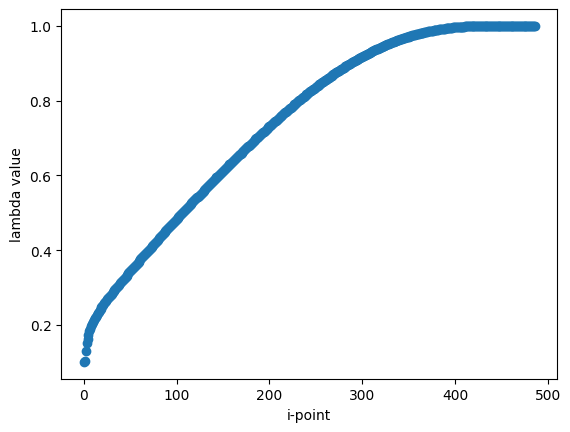

In [ ]:
fig, ax = plt.subplots()
nums = list(range(len(exp_var)))
ax.scatter(nums, cum_exp_var);
ax.set_xlabel('i-point');
ax.set_ylabel('lambda value');

In [ ]:
var_mask = cum_exp_var <= 0.95
sing_values = svd.singular_values_[var_mask]
n_components = sing_values.shape[0]
n_components

327

In [ ]:
svd_with_pc = TruncatedSVD(n_components=n_components)
X_train_reduced = svd_with_pc.fit_transform(X_train)
X_val_reduced = svd_with_pc.transform(X_val)

In [ ]:
params = {
    'subsample': 0.48748724047206654,
    'learning_rate': 0.033840417964290125,
    'colsample_bytree': 0.5782285251273777,
    'reg_alpha': 0.1351536043430544,
    'reg_lambda': 0.31900045174209063,
    'scale_pos_weight': 5,
    'num_leaves': 27,
    'max_depth': 9,
    'min_child_samples': 99
}

light_boosting_reduced = LGBMClassifier(**params, random_seed=42).fit(X=X_train_reduced, y=y_train,
                                                    eval_set=[(X_val_reduced, y_val)],
                                                    eval_metric='auc')

y_pred_lb_reduced = light_boosting_reduced.predict_proba(X_val_reduced)
print(f'ROC-AUC: {roc_auc_score(y_val, y_pred_lb_reduced[:, 1])}')

ROC-AUC: 0.7109074844280875


# Предсказание для тестовых данных



## Baseline model

Получим предсказание на тестовых данных

In [ ]:
# Обучим модель на полных тренировочных данных
gbdt_clf = HistGradientBoostingClassifier(min_samples_leaf=1,
                                          max_depth=20,
                                          max_iter=125,
                                          random_state=42).fit(X, y)

# Для предсказания используем тестовый датасет с исключенным признаком smpl
y_test_pred = gbdt_clf.predict_proba(data_test.drop(['smpl'], axis=1))

# Переведем предсказание в формат Series
y_test_pred = pd.Series(y_test_pred[:, 1])

# Добавим данные предсказания к датасету
data_test['target'] = y_test_pred

# Сохраним итоговые данные об id и предсказаниях в формате csv
data_test[['id', 'target']].to_csv('baseline_submission_case1.csv', index=False)

## Our models

### вариант 1 - LightGBM, лучший trial, сырые данные

In [ ]:
params = {
    'subsample': 0.48748724047206654,
    'learning_rate': 0.033840417964290125,
    'colsample_bytree': 0.5782285251273777,
    'reg_alpha': 0.1351536043430544,
    'reg_lambda': 0.31900045174209063,
    'scale_pos_weight': 5,
    'num_leaves': 27,
    'max_depth': 9,
    'min_child_samples': 99
}

# Обучим модель на полных тренировочных данных
final_model = LGBMClassifier(**params, random_seed=42).fit(X=X, y=y,
                                                    eval_metric='auc')

# Для предсказания используем тестовый датасет с исключенным признаком smpl
y_test_pred = final_model.predict_proba(data_test.drop(['smpl'], axis=1))

# Переведем предсказание в формат Series
y_test_pred = pd.Series(y_test_pred[:, 1])

# Добавим данные предсказания к датасету
data_test['target'] = y_test_pred

# Сохраним итоговые данные об id и предсказаниях в формате csv
data_test[['id', 'target']].to_csv('baseline_submission_case1.csv', index=False)

### вариант 2: лучшая модель - LightGBM, лучший trial, датасет с удалением нерелевантных

In [ ]:
train_corr_only_whole = pd.read_csv('/content/drive/MyDrive/Хакатон Альфа-банка. Кейс 1/full train processed/corr_only.csv').drop('Unnamed: 0', axis=1)
test_corr_only_whole = pd.read_csv('/content/drive/MyDrive/Хакатон Альфа-банка. Кейс 1/full test processed/test_corr_only.csv').drop('Unnamed: 0', axis=1)

In [ ]:
train_corr_only_whole

,target,smpl,id,feature_4,feature_5,feature_7,feature_11,feature_16,feature_19,feature_25,...,feature_372_3.0,feature_372_4.0,feature_375_0.0,feature_375_1.0,feature_375_2.0,feature_375_3.0,feature_375_4.0,feature_375_5.0,feature_396_1.0,feature_396_2.0
0,0,train,11619,-0.147178,-1.135569,-0.688879,-0.007343,-0.778399,-0.786005,-1.664981,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,train,11620,0.087665,0.316779,-0.143202,-0.507839,0.447524,-0.213129,-1.443812,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,train,11621,3.117520,-1.767073,1.596354,-1.045164,1.782435,1.131342,1.367568,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,train,11622,-0.946474,0.288386,1.049859,0.782964,0.740996,1.055638,-1.362752,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0,train,11623,-0.039862,0.305150,-0.157288,0.435065,-0.041253,-0.410871,-0.182347,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38726,0,train,3868,0.113818,-0.709053,0.812546,0.863412,-0.422811,0.116343,0.586546,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38727,0,train,3869,0.940327,-0.465618,0.099768,0.966629,0.103572,-0.116668,0.748177,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38728,0,train,3870,1.212203,0.301982,0.598599,-1.568323,-0.034069,0.086741,-0.393952,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38729,0,train,3871,-0.258802,-0.343323,0.772228,2.008930,-0.338831,-0.099098,-0.245905,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
test_corr_only_whole

,smpl,id,feature_4,feature_5,feature_7,feature_11,feature_16,feature_19,feature_25,feature_26,...,feature_372_3.0,feature_372_4.0,feature_375_0.0,feature_375_1.0,feature_375_2.0,feature_375_3.0,feature_375_4.0,feature_375_5.0,feature_396_1.0,feature_396_2.0
0,test,48641,-1.950657,-1.069576,-0.901771,-1.604580,-0.943408,-1.273246,-1.329137,-0.649004,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,test,48642,0.116074,0.220002,0.497531,0.624547,0.075499,-1.197486,-1.114676,1.538252,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,test,48643,-0.000365,1.486131,1.074513,0.489753,-0.139380,-1.095204,-0.614853,1.105422,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,test,48644,-1.761253,-1.098213,-0.934671,-0.273109,-0.736389,-1.041397,-0.392141,-0.237954,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,test,48645,2.761329,0.607158,0.392070,0.037941,0.769784,1.177009,0.308806,0.665137,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19821,test,56564,2.433253,0.789014,1.929220,0.531505,1.610211,1.353327,2.718256,2.328821,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
19822,test,56565,1.148273,0.279905,-0.392127,-0.526794,1.493749,0.818961,-1.536704,1.488625,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
19823,test,56566,-0.241779,-1.099969,-1.535987,-0.447923,-0.514434,-1.464160,-1.993976,-2.022411,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
19824,test,56567,-0.728617,-1.042950,-0.778764,-0.997434,-2.624413,-0.134382,-0.263567,-0.265624,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
X_train_corr_only_whole = train_corr_only_whole.drop(['id', 'target', 'smpl'], axis=1)
y_train_corr_only_whole = train_corr_only_whole['target']
X_test_corr_only_whole = test_corr_only_whole.drop(['id', 'smpl'], axis=1)

In [ ]:
params = {
    'subsample': 0.48748724047206654,
    'learning_rate': 0.033840417964290125,
    'colsample_bytree': 0.5782285251273777,
    'reg_alpha': 0.1351536043430544,
    'reg_lambda': 0.31900045174209063,
    'scale_pos_weight': 5,
    'num_leaves': 27,
    'max_depth': 9,
    'min_child_samples': 99
}

final_model = LGBMClassifier(**params, random_seed=42).fit(X=X_train_corr_only_whole, y=y_train_corr_only_whole,
                                                    eval_metric='auc')

y_test_pred = final_model.predict_proba(X_test_corr_only_whole)

test_corr_only_whole['target'] = pd.Series(y_test_pred[:, 1])

test_corr_only_whole[['id', 'target']].to_csv('submission_case1_corr_only.csv', index=False)

[LightGBM] [Info] Number of positive: 843, number of negative: 37888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.222235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27953
[LightGBM] [Info] Number of data points in the train set: 38731, number of used features: 188
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.021766 -> initscore=-3.805423
[LightGBM] [Info] Start training from score -3.805423
